In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader

import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt
import os


print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.13.1+cu117


### Get the path for various directories.

In [2]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, 'Airfoil')
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')

In [3]:
print("dataset_dir {}".format(dataset_dir))

dataset_dir F:\GNNsim2\Airfoil


### Import libraries involved in loading the dataset

In [4]:
import numpy as np
import torch
import h5py
import tensorflow.compat.v1 as tf
import functools
import json
from torch_geometric.data import Data
import enum

### Lets Look at the metadata about with Airfoil dataset

In [5]:
with open(os.path.join(root_dir, 'airfoil/meta.json')) as f:
    metadata = json.load(f)

In [27]:
metadata

{'simulator': 'su2',
 'dt': 0.0002,
 'collision_radius': None,
 'features': {'node_type': {'type': 'static',
   'shape': [1, 5233, 1],
   'dtype': 'int32'},
  'cells': {'type': 'static', 'shape': [1, 10216, 3], 'dtype': 'int32'},
  'mesh_pos': {'type': 'static', 'shape': [1, 5233, 2], 'dtype': 'float32'},
  'density': {'type': 'dynamic', 'shape': [601, 5233, 1], 'dtype': 'float32'},
  'pressure': {'type': 'dynamic', 'shape': [601, 5233, 1], 'dtype': 'float32'},
  'velocity': {'type': 'dynamic',
   'shape': [601, 5233, 2],
   'dtype': 'float32'}},
 'field_names': ['node_type',
  'cells',
  'mesh_pos',
  'density',
  'pressure',
  'velocity'],
 'trajectory_length': 601}

### Load the dataset!

In [ ]:
def _parse(proto, meta):
  """Parses a trajectory from tf.Example."""
  feature_lists = {k: tf.io.VarLenFeature(tf.string)
                   for k in meta['field_names']}
  features = tf.io.parse_single_example(proto, feature_lists)
  out = {}
  for key, field in meta['features'].items():
    data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
    data = tf.reshape(data, field['shape'])
    if field['type'] == 'static':
      data = tf.tile(data, [meta['trajectory_length'], 1, 1])
    elif field['type'] == 'dynamic_varlen':
      length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
      length = tf.reshape(length, [-1])
      data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
    elif field['type'] != 'dynamic':
      raise ValueError('invalid data format')
    out[key] = data
  return out


def load_dataset(split):
  """Load dataset."""
  with open(os.path.join(root_dir, 'Airfoil/meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(root_dir, 'Airfoil/'+split+'.tfrecord'))
  ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
  ds = ds.prefetch(1)
  return ds

In [ ]:
# Fetch the data to a list variable 'l'
ds = load_dataset('test')
ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)
l = list(ds.prefetch(0))

In [54]:
l[0]

{'node_type': <tf.Tensor: shape=(5233, 1), dtype=int32, numpy=
 array([[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]])>,
 'cells': <tf.Tensor: shape=(10216, 3), dtype=int32, numpy=
 array([[ 417,   69,  311],
        [ 302,   55,   56],
        [ 405,  159,  384],
        ...,
        [5105, 5061, 5029],
        [5134, 5106, 5097],
        [5122, 5109, 5075]])>,
 'mesh_pos': <tf.Tensor: shape=(5233, 2), dtype=float32, numpy=
 array([[ 9.9975002e-01, -3.6328966e-05],
        [ 9.9900001e-01, -1.4525375e-04],
        [ 9.9776000e-01, -3.2511118e-04],
        ...,
        [ 1.7549320e+01,  3.0887530e+00],
        [ 1.1416820e+01,  1.4055120e+01],
        [ 1.7193159e+01,  7.9130592e+00]], dtype=float32)>,
 'density': <tf.Tensor: shape=(5233, 1), dtype=float32, numpy=
 array([[1.226993 ],
        [1.2110808],
        [1.2060925],
        ...,
        [1.2249781],
        [1.2249781],
        [1.2249781]], dtype=float32)>,
 'pressure': <tf.Tensor: shape=(

In [18]:
#The length of data is:
len(l)

60100

### Utility functions 

Here we define the functions that are needed for assisting in data processing.

triangle_to_edges:  decomposes 2D triangular meshes to edges and returns the undirected graph nodes. 

NodeType: is subclass of enum with unique and unchanging integer valued attributes over instances in order to make sure values are unchanged

In [6]:
#Utility functions, provided in the release of the code from the original MeshGraphNets study:
#https://github.com/deepmind/deepmind-research/tree/master/meshgraphnets

def triangles_to_edges(faces):
  """Computes mesh edges from triangles.
     Note that this triangles_to_edges method was provided as part of the
     code release for the MeshGraphNets paper by DeepMind, available here:
     https://github.com/deepmind/deepmind-research/tree/master/meshgraphnets
  """
  # collect edges from triangles
  edges = tf.concat([faces[:, 0:2],
                     faces[:, 1:3],
                     tf.stack([faces[:, 2], faces[:, 0]], axis=1)], axis=0)
  # those edges are sometimes duplicated (within the mesh) and sometimes
  # single (at the mesh boundary).
  # sort & pack edges as single tf.int64
  receivers = tf.reduce_min(edges, axis=1)
  senders = tf.reduce_max(edges, axis=1)
  packed_edges = tf.bitcast(tf.stack([senders, receivers], axis=1), tf.int64)
  # remove duplicates and unpack
  unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
  senders, receivers = tf.unstack(unique_edges, axis=1)
  # create two-way connectivity
  return (tf.concat([senders, receivers], axis=0),
          tf.concat([receivers, senders], axis=0))



class NodeType(enum.IntEnum):
    """
    Define the code for the one-hot vector representing the node types.
    Note that this is consistent with the codes provided in the original
    MeshGraphNets study: 
    https://github.com/deepmind/deepmind-research/tree/master/meshgraphnets
    """
    NORMAL = 0
    OBSTACLE = 1
    AIRFOIL = 2
    HANDLE = 3
    INFLOW = 4
    OUTFLOW = 5
    WALL_BOUNDARY = 6
    SIZE = 9

### Represent Features to create torch graph data

In [7]:
#number of trajectories to train on.
number_trajectories = 5

#Splitting the dataset list to list of 100 trajectories of 601 trajectory length!
data = [l[:601+i*601] for i in range(100)]

# The time interval is 0.002s
dt = metadata['dt']

#data_list consists of all the pytorch graph data of 
data_list = []
for i in range(100):
    
    if(i==number_trajectories):
        break
    print("Trajectory: ",i)

    #We iterate over all the time steps to produce an example graph except
    #for the last one, which does not have a following time step to produce
    #node output values
    for ts in range(600):
        #Get node features
        #Note that it's faster to convert to numpy then to torch than to
        #import to torch from h5 format directly
        
        
        # Concat velocity and node type to construct node features in pytorch tensor!
        momentum = torch.tensor(np.array(data[i][ts]['velocity']))
        node_type = torch.tensor(np.array(tf.one_hot(data[i][0]['node_type'], NodeType.SIZE))).squeeze(1)
        x = torch.cat((momentum,node_type),dim=-1).type(torch.float)
        
        
        # Get edge indices in torch tensor!
        b = data[i][ts]['cells']
        #look at function triangles_to_edges
        edges = triangles_to_edges(tf.convert_to_tensor(np.array(b)))
#         print(edges)
        edge_index = torch.cat( (torch.tensor(edges[0].numpy()).unsqueeze(0) ,
                     torch.tensor(edges[1].numpy()).unsqueeze(0)), dim=0).type(torch.long)
#         print(edge_index[0])

        # Get edge features       
        # Edge feature for each node pairs in edge_index
        u_i=torch.tensor(np.array(data[i][ts]['mesh_pos']))[edge_index[0]]
        u_j=torch.tensor(np.array(data[i][ts]['mesh_pos']))[edge_index[1]]
        u_ij=u_i-u_j
        u_ij_norm = torch.norm(u_ij,p=2,dim=1,keepdim=True)
        edge_attr = torch.cat((u_ij,u_ij_norm),dim=-1).type(torch.float)

        #Node outputs, for training (velocity)
        v_t=torch.tensor(np.array(data[i][ts]['velocity']))
        v_tp1=torch.tensor(np.array(data[i][ts+1]['velocity']))
        y=((v_tp1-v_t)/dt).type(torch.float)

        #Node outputs, for testing integrator (pressure)
        p=torch.tensor(np.array(data[i][ts]['pressure']))
        #Node outputs, for density
        d=torch.tensor(np.array(data[i][ts]['density']))

        #Data needed for visualization code
        cells=torch.tensor(np.array(data[i][ts]['cells']))
        mesh_pos=torch.tensor(np.array(data[i][ts]['mesh_pos']))

        data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y,p=p,d=d,
                              cells=cells,mesh_pos=mesh_pos))

NameError: name 'l' is not defined

In [26]:
#data_list constists of 3000 torch_geometric graph data
len(data_list)

3000

In [27]:
data_list[2]

Data(x=[5233, 11], edge_index=[2, 30898], edge_attr=[30898, 3], y=[5233, 2], p=[5233, 1], cells=[10216, 3], mesh_pos=[5233, 2])

### Save and Load the dataset

In [33]:
print("Done collecting data!")
torch.save(data_list[:3000],os.path.join(dataset_dir + '/test_processed_airfoil_set.pt'))
print("Done saving data!")


Done collecting data!
Done saving data!


In [121]:
file_path = os.path.join(dataset_dir + '/test_processed_airfoil_set.pt')


### Data (un)normalization Code

In [9]:
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list, 
    calculates the mean and standard deviation for the node features, edge features, 
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to 
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the 
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

# MeshGraphNet Model

In [10]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type + node_position
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr, pressure = data.x, data.edge_index, data.edge_attr, data.p

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)

    def loss(self, pred, inputs,mean_vec_y,std_vec_y):
        #Define the node types that we calculate loss for
        normal=torch.tensor(0)
        outflow=torch.tensor(5)

        #Get the loss mask for the nodes of the types we calculate loss for
        loss_mask=torch.logical_or((torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(0)),
                                   (torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(5)))

        #Normalize labels with dataset statistics
        labels = normalize(inputs.y,mean_vec_y,std_vec_y)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[loss_mask]))
        
        return loss

In [11]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

### Building the Optimizer

In [12]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Training and Testing

In [13]:

def train(dataset, device, stats_list, args):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving 
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    loader = DataLoader(dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 2 # the dynamic variables have the shape of 2 (velocity)

    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(device)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_losses = []
    velo_val_losses = []
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        print("Entered epoch :",epoch)
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss = model.loss(pred,batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_velo_val):
                # save velocity evaluation
                test_loss, velo_val_rmse = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)
                velo_val_losses.append(velo_val_rmse.item())
            else:
                test_loss, _ = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            df = df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': velo_val_losses[-1]}, ignore_index=True)
        else:
            df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))


            if(args.save_best_model):

                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader

def test(loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y, is_validation,
          delta_t=metadata['dt'], save_model_preds=False, model_type=None):
  
    '''
    Calculates test set losses and validation set errors.
    '''

    loss=0
    velo_rmse = 0
    num_loops=0

    for data in loader:
        data=data.to(device)
        with torch.no_grad():

            #calculate the loss for the model given the test set
            pred = test_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss += test_model.loss(pred, data,mean_vec_y,std_vec_y)

            #calculate validation error if asked to
            if (is_validation):

                #Like for the MeshGraphNets model, calculate the mask over which we calculate
                #flow loss and add this calculated RMSE value to our val error
                normal = torch.tensor(0)
                outflow = torch.tensor(5)
                loss_mask = torch.logical_or((torch.argmax(data.x[:, 2:], dim=1) == torch.tensor(0)),
                                             (torch.argmax(data.x[:, 2:], dim=1) == torch.tensor(5)))

                eval_velo = data.x[:, 0:2] + unnormalize( pred[:], mean_vec_y, std_vec_y ) * delta_t
                gs_velo = data.x[:, 0:2] + data.y[:] * delta_t
                
                error = torch.sum((eval_velo - gs_velo) ** 2, axis=1)
                velo_rmse += torch.sqrt(torch.mean(error[loss_mask]))

        num_loops+=1
        # if velocity is evaluated, return velo_rmse as 0
    return loss/num_loops, velo_rmse/num_loops

### Defining Hyper-parameters

In [14]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',  
         'num_layers': 10,
         'batch_size': 16, 
         'hidden_dim': 10, 
         'epochs': 2000,
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'train_size': 45, 
         'test_size': 10, 
         'device':'cuda',
         'shuffle': True, 
         'save_velo_val': True,
         'save_best_model': True, 
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [122]:
# dataset = torch.load(file_path)[:(args.train_size+args.test_size)]

dataset = torch.load(file_path)[:600]

In [16]:
if(args.shuffle):
  random.shuffle(dataset)

stats_list = get_stats(dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cuda


In [126]:
stats_list = get_stats(dataset[100:150])

In [17]:
path = args.checkpoint_dir+ '/model_nl10_bs16_hd10_ep2000_wd0.0005_lr0.001_shuff_True_tr45_te10.pt'

# build model
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 2 # the dynamic variables have the shape of 2 (velocity)


best_model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(device)

best_model.load_state_dict(torch.load(path))
best_model.eval()

MeshGraphNet(
  (node_encoder): Sequential(
    (0): Linear(in_features=11, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  )
  (processor): ModuleList(
    (0): ProcessorLayer()
    (1): ProcessorLayer()
    (2): ProcessorLayer()
    (3): ProcessorLayer()
    (4): ProcessorLayer()
    (5): ProcessorLayer()
    (6): ProcessorLayer()
    (7): ProcessorLayer()
    (8): ProcessorLayer()
    (9): ProcessorLayer()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

### Train and Test Loop

In [47]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader = train(dataset, device, stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

F:\GNNsim2\.venv\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|                                                                           | 0/2000 [00:00<?, ?Epochs/s]

Entered epoch : 0


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],


train loss 1.85 test loss 1.57 velo loss 71.10171


Training:   0%|                                                                | 1/2000 [01:24<46:40:11, 84.05s/Epochs]

Entered epoch : 1


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|                                                                | 2/2000 [01:26<19:53:29, 35.84s/Epochs]

Entered epoch : 2


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|                                                                | 3/2000 [01:28<11:16:27, 20.32s/Epochs]

Entered epoch : 3


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▏                                                                | 4/2000 [01:29<7:13:38, 13.04s/Epochs]

Entered epoch : 4


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▏                                                                | 5/2000 [01:31<4:59:28,  9.01s/Epochs]

Entered epoch : 5


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▏                                                                | 6/2000 [01:33<3:38:40,  6.58s/Epochs]

Entered epoch : 6


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▏                                                                | 7/2000 [01:35<2:47:22,  5.04s/Epochs]

Entered epoch : 7


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▎                                                                | 8/2000 [01:37<2:14:06,  4.04s/Epochs]

Entered epoch : 8


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▎                                                                | 9/2000 [01:39<1:51:31,  3.36s/Epochs]

Entered epoch : 9


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   0%|▎                                                               | 10/2000 [01:41<1:36:11,  2.90s/Epochs]

Entered epoch : 10


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▎                                                               | 11/2000 [01:43<1:30:22,  2.73s/Epochs]

Entered epoch : 11


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▍                                                               | 12/2000 [01:45<1:25:33,  2.58s/Epochs]

Entered epoch : 12


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▍                                                               | 13/2000 [01:47<1:20:36,  2.43s/Epochs]

Entered epoch : 13


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▍                                                               | 14/2000 [01:49<1:14:56,  2.26s/Epochs]

Entered epoch : 14


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▍                                                               | 15/2000 [01:51<1:14:16,  2.25s/Epochs]

Entered epoch : 15


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▌                                                               | 16/2000 [01:53<1:11:36,  2.17s/Epochs]

Entered epoch : 16


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▌                                                               | 17/2000 [01:55<1:11:29,  2.16s/Epochs]

Entered epoch : 17


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▌                                                               | 18/2000 [01:57<1:08:34,  2.08s/Epochs]

Entered epoch : 18


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▌                                                               | 19/2000 [01:59<1:06:34,  2.02s/Epochs]

Entered epoch : 19


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▋                                                               | 20/2000 [02:01<1:05:12,  1.98s/Epochs]

Entered epoch : 20


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▋                                                               | 21/2000 [02:03<1:07:16,  2.04s/Epochs]

Entered epoch : 21


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▋                                                               | 22/2000 [02:06<1:09:19,  2.10s/Epochs]

Entered epoch : 22


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▋                                                               | 23/2000 [02:07<1:07:03,  2.04s/Epochs]

Entered epoch : 23


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▊                                                               | 24/2000 [02:10<1:08:12,  2.07s/Epochs]

Entered epoch : 24


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▊                                                               | 25/2000 [02:11<1:06:16,  2.01s/Epochs]

Entered epoch : 25


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▊                                                               | 26/2000 [02:13<1:04:55,  1.97s/Epochs]

Entered epoch : 26


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▊                                                               | 27/2000 [02:15<1:04:00,  1.95s/Epochs]

Entered epoch : 27


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▉                                                               | 28/2000 [02:17<1:03:21,  1.93s/Epochs]

Entered epoch : 28


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   1%|▉                                                               | 29/2000 [02:19<1:02:51,  1.91s/Epochs]

Entered epoch : 29


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|▉                                                               | 30/2000 [02:21<1:02:34,  1.91s/Epochs]

Entered epoch : 30


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|▉                                                               | 31/2000 [02:23<1:06:16,  2.02s/Epochs]

Entered epoch : 31


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█                                                               | 32/2000 [02:25<1:07:45,  2.07s/Epochs]

Entered epoch : 32


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█                                                               | 33/2000 [02:27<1:05:59,  2.01s/Epochs]

Entered epoch : 33


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█                                                               | 34/2000 [02:29<1:04:45,  1.98s/Epochs]

Entered epoch : 34


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█                                                               | 35/2000 [02:31<1:03:54,  1.95s/Epochs]

Entered epoch : 35


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▏                                                              | 36/2000 [02:33<1:03:17,  1.93s/Epochs]

Entered epoch : 36


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▏                                                              | 37/2000 [02:35<1:02:51,  1.92s/Epochs]

Entered epoch : 37


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▏                                                              | 38/2000 [02:37<1:02:29,  1.91s/Epochs]

Entered epoch : 38


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▏                                                              | 39/2000 [02:39<1:02:18,  1.91s/Epochs]

Entered epoch : 39


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▎                                                              | 40/2000 [02:40<1:02:09,  1.90s/Epochs]

Entered epoch : 40


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▎                                                              | 41/2000 [02:43<1:06:00,  2.02s/Epochs]

Entered epoch : 41


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▎                                                              | 42/2000 [02:45<1:07:37,  2.07s/Epochs]

Entered epoch : 42


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▍                                                              | 43/2000 [02:47<1:05:50,  2.02s/Epochs]

Entered epoch : 43


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▍                                                              | 44/2000 [02:49<1:04:32,  1.98s/Epochs]

Entered epoch : 44


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▍                                                              | 45/2000 [02:51<1:03:43,  1.96s/Epochs]

Entered epoch : 45


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▍                                                              | 46/2000 [02:53<1:03:07,  1.94s/Epochs]

Entered epoch : 46


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▌                                                              | 47/2000 [02:54<1:02:38,  1.92s/Epochs]

Entered epoch : 47


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▌                                                              | 48/2000 [02:56<1:02:29,  1.92s/Epochs]

Entered epoch : 48


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▌                                                              | 49/2000 [02:58<1:02:20,  1.92s/Epochs]

Entered epoch : 49


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   2%|█▌                                                              | 50/2000 [03:00<1:02:13,  1.91s/Epochs]

Entered epoch : 50


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▋                                                              | 51/2000 [03:02<1:05:10,  2.01s/Epochs]

Entered epoch : 51


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▋                                                              | 52/2000 [03:04<1:04:09,  1.98s/Epochs]

Entered epoch : 52


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▋                                                              | 53/2000 [03:06<1:03:27,  1.96s/Epochs]

Entered epoch : 53


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▋                                                              | 54/2000 [03:08<1:02:58,  1.94s/Epochs]

Entered epoch : 54


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▊                                                              | 55/2000 [03:10<1:02:35,  1.93s/Epochs]

Entered epoch : 55


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▊                                                              | 56/2000 [03:12<1:02:19,  1.92s/Epochs]

Entered epoch : 56


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▊                                                              | 57/2000 [03:14<1:02:08,  1.92s/Epochs]

Entered epoch : 57


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▊                                                              | 58/2000 [03:16<1:01:57,  1.91s/Epochs]

Entered epoch : 58


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▉                                                              | 59/2000 [03:18<1:01:53,  1.91s/Epochs]

Entered epoch : 59


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▉                                                              | 60/2000 [03:20<1:01:48,  1.91s/Epochs]

Entered epoch : 60


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▉                                                              | 61/2000 [03:22<1:04:44,  2.00s/Epochs]

Entered epoch : 61


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|█▉                                                              | 62/2000 [03:24<1:03:45,  1.97s/Epochs]

Entered epoch : 62


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██                                                              | 63/2000 [03:26<1:03:04,  1.95s/Epochs]

Entered epoch : 63


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██                                                              | 64/2000 [03:28<1:02:36,  1.94s/Epochs]

Entered epoch : 64


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██                                                              | 65/2000 [03:29<1:02:18,  1.93s/Epochs]

Entered epoch : 65


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██                                                              | 66/2000 [03:31<1:02:00,  1.92s/Epochs]

Entered epoch : 66


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██▏                                                             | 67/2000 [03:33<1:01:50,  1.92s/Epochs]

Entered epoch : 67


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██▏                                                             | 68/2000 [03:35<1:01:40,  1.92s/Epochs]

Entered epoch : 68


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   3%|██▏                                                             | 69/2000 [03:37<1:01:36,  1.91s/Epochs]

Entered epoch : 69


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▏                                                             | 70/2000 [03:39<1:01:32,  1.91s/Epochs]

Entered epoch : 70


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▎                                                             | 71/2000 [03:41<1:04:26,  2.00s/Epochs]

Entered epoch : 71


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▎                                                             | 72/2000 [03:43<1:03:30,  1.98s/Epochs]

Entered epoch : 72


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▎                                                             | 73/2000 [03:45<1:02:49,  1.96s/Epochs]

Entered epoch : 73


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▎                                                             | 74/2000 [03:47<1:02:18,  1.94s/Epochs]

Entered epoch : 74


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▍                                                             | 75/2000 [03:49<1:01:58,  1.93s/Epochs]

Entered epoch : 75


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▍                                                             | 76/2000 [03:51<1:01:42,  1.92s/Epochs]

Entered epoch : 76


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▍                                                             | 77/2000 [03:53<1:01:35,  1.92s/Epochs]

Entered epoch : 77


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▍                                                             | 78/2000 [03:55<1:01:31,  1.92s/Epochs]

Entered epoch : 78


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▌                                                             | 79/2000 [03:56<1:01:30,  1.92s/Epochs]

Entered epoch : 79


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▌                                                             | 80/2000 [03:58<1:01:23,  1.92s/Epochs]

Entered epoch : 80


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▌                                                             | 81/2000 [04:01<1:05:15,  2.04s/Epochs]

Entered epoch : 81


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▌                                                             | 82/2000 [04:03<1:06:39,  2.09s/Epochs]

Entered epoch : 82


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▋                                                             | 83/2000 [04:05<1:04:55,  2.03s/Epochs]

Entered epoch : 83


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▋                                                             | 84/2000 [04:07<1:03:44,  2.00s/Epochs]

Entered epoch : 84


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▋                                                             | 85/2000 [04:09<1:02:59,  1.97s/Epochs]

Entered epoch : 85


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▊                                                             | 86/2000 [04:11<1:02:22,  1.96s/Epochs]

Entered epoch : 86


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▊                                                             | 87/2000 [04:12<1:02:01,  1.95s/Epochs]

Entered epoch : 87


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▊                                                             | 88/2000 [04:14<1:01:42,  1.94s/Epochs]

Entered epoch : 88


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▊                                                             | 89/2000 [04:16<1:01:33,  1.93s/Epochs]

Entered epoch : 89


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   4%|██▉                                                             | 90/2000 [04:18<1:01:23,  1.93s/Epochs]

Entered epoch : 90


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|██▉                                                             | 91/2000 [04:21<1:04:40,  2.03s/Epochs]

Entered epoch : 91


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|██▉                                                             | 92/2000 [04:22<1:03:46,  2.01s/Epochs]

Entered epoch : 92


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|██▉                                                             | 93/2000 [04:24<1:02:55,  1.98s/Epochs]

Entered epoch : 93


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███                                                             | 94/2000 [04:26<1:02:16,  1.96s/Epochs]

Entered epoch : 94


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███                                                             | 95/2000 [04:28<1:01:53,  1.95s/Epochs]

Entered epoch : 95


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███                                                             | 96/2000 [04:30<1:01:37,  1.94s/Epochs]

Entered epoch : 96


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███                                                             | 97/2000 [04:32<1:01:25,  1.94s/Epochs]

Entered epoch : 97


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                            | 98/2000 [04:34<1:01:13,  1.93s/Epochs]

Entered epoch : 98


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                            | 99/2000 [04:36<1:01:06,  1.93s/Epochs]

Entered epoch : 99


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                           | 100/2000 [04:38<1:00:59,  1.93s/Epochs]

Entered epoch : 100


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                           | 101/2000 [04:40<1:04:10,  2.03s/Epochs]

train loss 1.07 test loss 1.26 velo loss 56.91212
Entered epoch : 101


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                           | 102/2000 [04:42<1:03:11,  2.00s/Epochs]

Entered epoch : 102


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▏                                                           | 103/2000 [04:44<1:02:31,  1.98s/Epochs]

Entered epoch : 103


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▎                                                           | 104/2000 [04:46<1:01:58,  1.96s/Epochs]

Entered epoch : 104


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▎                                                           | 105/2000 [04:48<1:01:39,  1.95s/Epochs]

Entered epoch : 105


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▎                                                           | 106/2000 [04:50<1:01:40,  1.95s/Epochs]

Entered epoch : 106


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▎                                                           | 107/2000 [04:52<1:01:24,  1.95s/Epochs]

Entered epoch : 107


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▍                                                           | 108/2000 [04:54<1:01:10,  1.94s/Epochs]

Entered epoch : 108


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   5%|███▍                                                           | 109/2000 [04:56<1:01:05,  1.94s/Epochs]

Entered epoch : 109


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▍                                                           | 110/2000 [04:58<1:01:23,  1.95s/Epochs]

Entered epoch : 110


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▍                                                           | 111/2000 [05:00<1:04:13,  2.04s/Epochs]

Entered epoch : 111


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▌                                                           | 112/2000 [05:02<1:03:12,  2.01s/Epochs]

Entered epoch : 112


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▌                                                           | 113/2000 [05:04<1:02:31,  1.99s/Epochs]

Entered epoch : 113


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▌                                                           | 114/2000 [05:06<1:02:03,  1.97s/Epochs]

Entered epoch : 114


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▌                                                           | 115/2000 [05:08<1:01:44,  1.97s/Epochs]

Entered epoch : 115


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▋                                                           | 116/2000 [05:09<1:01:32,  1.96s/Epochs]

Entered epoch : 116


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▋                                                           | 117/2000 [05:11<1:01:15,  1.95s/Epochs]

Entered epoch : 117


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▋                                                           | 118/2000 [05:13<1:01:11,  1.95s/Epochs]

Entered epoch : 118


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▋                                                           | 119/2000 [05:15<1:01:05,  1.95s/Epochs]

Entered epoch : 119


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▊                                                           | 120/2000 [05:17<1:01:00,  1.95s/Epochs]

Entered epoch : 120


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▊                                                           | 121/2000 [05:20<1:04:25,  2.06s/Epochs]

Entered epoch : 121


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▊                                                           | 122/2000 [05:21<1:03:11,  2.02s/Epochs]

Entered epoch : 122


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▊                                                           | 123/2000 [05:23<1:02:30,  2.00s/Epochs]

Entered epoch : 123


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▉                                                           | 124/2000 [05:25<1:01:56,  1.98s/Epochs]

Entered epoch : 124


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▉                                                           | 125/2000 [05:27<1:01:48,  1.98s/Epochs]

Entered epoch : 125


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|███▉                                                           | 126/2000 [05:29<1:01:44,  1.98s/Epochs]

Entered epoch : 126


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|████                                                           | 127/2000 [05:31<1:01:23,  1.97s/Epochs]

Entered epoch : 127


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|████                                                           | 128/2000 [05:33<1:01:03,  1.96s/Epochs]

Entered epoch : 128


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|████                                                           | 129/2000 [05:35<1:00:55,  1.95s/Epochs]

Entered epoch : 129


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   6%|████                                                           | 130/2000 [05:37<1:00:45,  1.95s/Epochs]

Entered epoch : 130


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▏                                                          | 131/2000 [05:39<1:03:33,  2.04s/Epochs]

Entered epoch : 131


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▏                                                          | 132/2000 [05:41<1:03:46,  2.05s/Epochs]

Entered epoch : 132


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▏                                                          | 133/2000 [05:43<1:02:55,  2.02s/Epochs]

Entered epoch : 133


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▏                                                          | 134/2000 [05:45<1:02:10,  2.00s/Epochs]

Entered epoch : 134


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▎                                                          | 135/2000 [05:47<1:01:47,  1.99s/Epochs]

Entered epoch : 135


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▎                                                          | 136/2000 [05:49<1:01:31,  1.98s/Epochs]

Entered epoch : 136


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▎                                                          | 137/2000 [05:51<1:01:17,  1.97s/Epochs]

Entered epoch : 137


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▎                                                          | 138/2000 [05:53<1:01:10,  1.97s/Epochs]

Entered epoch : 138


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▍                                                          | 139/2000 [05:55<1:01:02,  1.97s/Epochs]

Entered epoch : 139


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▍                                                          | 140/2000 [05:57<1:00:53,  1.96s/Epochs]

Entered epoch : 140


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▍                                                          | 141/2000 [05:59<1:03:45,  2.06s/Epochs]

Entered epoch : 141


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▍                                                          | 142/2000 [06:01<1:02:51,  2.03s/Epochs]

Entered epoch : 142


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▌                                                          | 143/2000 [06:03<1:02:09,  2.01s/Epochs]

Entered epoch : 143


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▌                                                          | 144/2000 [06:05<1:01:42,  1.99s/Epochs]

Entered epoch : 144


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▌                                                          | 145/2000 [06:07<1:01:22,  1.99s/Epochs]

Entered epoch : 145


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▌                                                          | 146/2000 [06:09<1:01:04,  1.98s/Epochs]

Entered epoch : 146


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▋                                                          | 147/2000 [06:11<1:00:56,  1.97s/Epochs]

Entered epoch : 147


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▋                                                          | 148/2000 [06:13<1:00:50,  1.97s/Epochs]

Entered epoch : 148


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   7%|████▋                                                          | 149/2000 [06:15<1:00:40,  1.97s/Epochs]

Entered epoch : 149


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▋                                                          | 150/2000 [06:17<1:00:36,  1.97s/Epochs]

Entered epoch : 150


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▊                                                          | 151/2000 [06:19<1:03:28,  2.06s/Epochs]

Entered epoch : 151


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▊                                                          | 152/2000 [06:21<1:02:30,  2.03s/Epochs]

Entered epoch : 152


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▊                                                          | 153/2000 [06:23<1:02:01,  2.01s/Epochs]

Entered epoch : 153


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▊                                                          | 154/2000 [06:25<1:01:53,  2.01s/Epochs]

Entered epoch : 154


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▉                                                          | 155/2000 [06:27<1:01:45,  2.01s/Epochs]

Entered epoch : 155


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▉                                                          | 156/2000 [06:29<1:01:23,  2.00s/Epochs]

Entered epoch : 156


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▉                                                          | 157/2000 [06:31<1:01:09,  1.99s/Epochs]

Entered epoch : 157


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|████▉                                                          | 158/2000 [06:33<1:00:58,  1.99s/Epochs]

Entered epoch : 158


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████                                                          | 159/2000 [06:35<1:00:47,  1.98s/Epochs]

Entered epoch : 159


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████                                                          | 160/2000 [06:37<1:00:38,  1.98s/Epochs]

Entered epoch : 160


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████                                                          | 161/2000 [06:39<1:03:45,  2.08s/Epochs]

Entered epoch : 161


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████                                                          | 162/2000 [06:41<1:02:37,  2.04s/Epochs]

Entered epoch : 162


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▏                                                         | 163/2000 [06:43<1:01:53,  2.02s/Epochs]

Entered epoch : 163


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▏                                                         | 164/2000 [06:45<1:01:22,  2.01s/Epochs]

Entered epoch : 164


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▏                                                         | 165/2000 [06:47<1:00:55,  1.99s/Epochs]

Entered epoch : 165


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▏                                                         | 166/2000 [06:49<1:00:37,  1.98s/Epochs]

Entered epoch : 166


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▎                                                         | 167/2000 [06:51<1:00:25,  1.98s/Epochs]

Entered epoch : 167


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▎                                                         | 168/2000 [06:53<1:00:14,  1.97s/Epochs]

Entered epoch : 168


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▎                                                         | 169/2000 [06:55<1:00:07,  1.97s/Epochs]

Entered epoch : 169


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   8%|█████▎                                                         | 170/2000 [06:57<1:00:03,  1.97s/Epochs]

Entered epoch : 170


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▍                                                         | 171/2000 [06:59<1:02:49,  2.06s/Epochs]

Entered epoch : 171


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▍                                                         | 172/2000 [07:01<1:01:51,  2.03s/Epochs]

Entered epoch : 172


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▍                                                         | 173/2000 [07:03<1:01:16,  2.01s/Epochs]

Entered epoch : 173


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▍                                                         | 174/2000 [07:05<1:00:49,  2.00s/Epochs]

Entered epoch : 174


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▌                                                         | 175/2000 [07:07<1:00:29,  1.99s/Epochs]

Entered epoch : 175


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▌                                                         | 176/2000 [07:09<1:00:12,  1.98s/Epochs]

Entered epoch : 176


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▌                                                         | 177/2000 [07:11<1:00:04,  1.98s/Epochs]

Entered epoch : 177


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                           | 178/2000 [07:13<59:57,  1.97s/Epochs]

Entered epoch : 178


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                           | 179/2000 [07:15<59:50,  1.97s/Epochs]

Entered epoch : 179


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                           | 180/2000 [07:17<59:44,  1.97s/Epochs]

Entered epoch : 180


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▋                                                         | 181/2000 [07:19<1:02:41,  2.07s/Epochs]

Entered epoch : 181


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▋                                                         | 182/2000 [07:21<1:01:43,  2.04s/Epochs]

Entered epoch : 182


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                         | 183/2000 [07:23<1:01:00,  2.01s/Epochs]

Entered epoch : 183


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                         | 184/2000 [07:25<1:00:31,  2.00s/Epochs]

Entered epoch : 184


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                         | 185/2000 [07:27<1:00:13,  1.99s/Epochs]

Entered epoch : 185


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|█████▊                                                         | 186/2000 [07:29<1:00:01,  1.99s/Epochs]

Entered epoch : 186


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|██████                                                           | 187/2000 [07:31<59:46,  1.98s/Epochs]

Entered epoch : 187


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|██████                                                           | 188/2000 [07:33<59:37,  1.97s/Epochs]

Entered epoch : 188


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:   9%|██████▏                                                          | 189/2000 [07:35<59:32,  1.97s/Epochs]

Entered epoch : 189


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▏                                                          | 190/2000 [07:37<59:27,  1.97s/Epochs]

Entered epoch : 190


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████                                                         | 191/2000 [07:39<1:02:11,  2.06s/Epochs]

Entered epoch : 191


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████                                                         | 192/2000 [07:41<1:01:21,  2.04s/Epochs]

Entered epoch : 192


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████                                                         | 193/2000 [07:43<1:00:41,  2.02s/Epochs]

Entered epoch : 193


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████                                                         | 194/2000 [07:45<1:00:12,  2.00s/Epochs]

Entered epoch : 194


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▏                                                        | 195/2000 [07:47<1:00:03,  2.00s/Epochs]

Entered epoch : 195


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▎                                                          | 196/2000 [07:49<59:46,  1.99s/Epochs]

Entered epoch : 196


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▍                                                          | 197/2000 [07:51<59:33,  1.98s/Epochs]

Entered epoch : 197


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▍                                                          | 198/2000 [07:53<59:22,  1.98s/Epochs]

Entered epoch : 198


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▍                                                          | 199/2000 [07:55<59:16,  1.97s/Epochs]

Entered epoch : 199


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▌                                                          | 200/2000 [07:57<59:11,  1.97s/Epochs]

Entered epoch : 200


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▎                                                        | 201/2000 [07:59<1:02:18,  2.08s/Epochs]

train loss 1.07 test loss 1.26 velo loss 56.81559
Entered epoch : 201


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▎                                                        | 202/2000 [08:01<1:01:13,  2.04s/Epochs]

Entered epoch : 202


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▍                                                        | 203/2000 [08:03<1:00:27,  2.02s/Epochs]

Entered epoch : 203


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▋                                                          | 204/2000 [08:05<59:55,  2.00s/Epochs]

Entered epoch : 204


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▋                                                          | 205/2000 [08:07<59:34,  1.99s/Epochs]

Entered epoch : 205


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▋                                                          | 206/2000 [08:09<59:19,  1.98s/Epochs]

Entered epoch : 206


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▋                                                          | 207/2000 [08:11<59:06,  1.98s/Epochs]

Entered epoch : 207


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▊                                                          | 208/2000 [08:13<58:58,  1.97s/Epochs]

Entered epoch : 208


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▊                                                          | 209/2000 [08:15<58:54,  1.97s/Epochs]

Entered epoch : 209


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  10%|██████▊                                                          | 210/2000 [08:17<58:44,  1.97s/Epochs]

Entered epoch : 210


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▋                                                        | 211/2000 [08:19<1:01:27,  2.06s/Epochs]

Entered epoch : 211


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▋                                                        | 212/2000 [08:21<1:00:34,  2.03s/Epochs]

Entered epoch : 212


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▉                                                          | 213/2000 [08:23<59:53,  2.01s/Epochs]

Entered epoch : 213


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▉                                                          | 214/2000 [08:25<59:27,  2.00s/Epochs]

Entered epoch : 214


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▉                                                          | 215/2000 [08:27<58:45,  1.97s/Epochs]

Entered epoch : 215


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████                                                          | 216/2000 [08:29<58:14,  1.96s/Epochs]

Entered epoch : 216


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████                                                          | 217/2000 [08:31<57:58,  1.95s/Epochs]

Entered epoch : 217


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████                                                          | 218/2000 [08:33<57:39,  1.94s/Epochs]

Entered epoch : 218


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████                                                          | 219/2000 [08:35<57:26,  1.94s/Epochs]

Entered epoch : 219


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▏                                                         | 220/2000 [08:37<57:29,  1.94s/Epochs]

Entered epoch : 220


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|██████▉                                                        | 221/2000 [08:39<1:00:12,  2.03s/Epochs]

Entered epoch : 221


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▏                                                         | 222/2000 [08:41<59:11,  2.00s/Epochs]

Entered epoch : 222


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▏                                                         | 223/2000 [08:43<58:56,  1.99s/Epochs]

Entered epoch : 223


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▎                                                         | 224/2000 [08:45<58:30,  1.98s/Epochs]

Entered epoch : 224


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▎                                                         | 225/2000 [08:47<58:12,  1.97s/Epochs]

Entered epoch : 225


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▎                                                         | 226/2000 [08:49<58:02,  1.96s/Epochs]

Entered epoch : 226


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▍                                                         | 227/2000 [08:51<57:51,  1.96s/Epochs]

Entered epoch : 227


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▍                                                         | 228/2000 [08:53<57:45,  1.96s/Epochs]

Entered epoch : 228


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  11%|███████▍                                                         | 229/2000 [08:55<58:05,  1.97s/Epochs]

Entered epoch : 229


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▍                                                         | 230/2000 [08:57<58:02,  1.97s/Epochs]

Entered epoch : 230


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▎                                                       | 231/2000 [08:59<1:00:42,  2.06s/Epochs]

Entered epoch : 231


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▌                                                         | 232/2000 [09:01<59:53,  2.03s/Epochs]

Entered epoch : 232


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▌                                                         | 233/2000 [09:03<59:15,  2.01s/Epochs]

Entered epoch : 233


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▌                                                         | 234/2000 [09:05<58:52,  2.00s/Epochs]

Entered epoch : 234


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▋                                                         | 235/2000 [09:07<58:37,  1.99s/Epochs]

Entered epoch : 235


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▋                                                         | 236/2000 [09:09<58:24,  1.99s/Epochs]

Entered epoch : 236


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▋                                                         | 237/2000 [09:11<58:09,  1.98s/Epochs]

Entered epoch : 237


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▋                                                         | 238/2000 [09:13<58:01,  1.98s/Epochs]

Entered epoch : 238


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▊                                                         | 239/2000 [09:15<57:58,  1.98s/Epochs]

Entered epoch : 239


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▊                                                         | 240/2000 [09:17<57:52,  1.97s/Epochs]

Entered epoch : 240


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▌                                                       | 241/2000 [09:19<1:00:28,  2.06s/Epochs]

Entered epoch : 241


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▊                                                         | 242/2000 [09:21<59:38,  2.04s/Epochs]

Entered epoch : 242


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▉                                                         | 243/2000 [09:23<58:58,  2.01s/Epochs]

Entered epoch : 243


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▉                                                         | 244/2000 [09:25<58:33,  2.00s/Epochs]

Entered epoch : 244


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▉                                                         | 245/2000 [09:27<58:48,  2.01s/Epochs]

Entered epoch : 245


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|███████▉                                                         | 246/2000 [09:29<58:55,  2.02s/Epochs]

Entered epoch : 246


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|████████                                                         | 247/2000 [09:31<58:45,  2.01s/Epochs]

Entered epoch : 247


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|████████                                                         | 248/2000 [09:33<58:41,  2.01s/Epochs]

Entered epoch : 248


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|████████                                                         | 249/2000 [09:35<58:31,  2.01s/Epochs]

Entered epoch : 249


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  12%|████████▏                                                        | 250/2000 [09:37<58:15,  2.00s/Epochs]

Entered epoch : 250


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|███████▉                                                       | 251/2000 [09:39<1:00:47,  2.09s/Epochs]

Entered epoch : 251


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▏                                                        | 252/2000 [09:41<59:47,  2.05s/Epochs]

Entered epoch : 252


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▏                                                        | 253/2000 [09:43<59:05,  2.03s/Epochs]

Entered epoch : 253


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▎                                                        | 254/2000 [09:45<58:33,  2.01s/Epochs]

Entered epoch : 254


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▎                                                        | 255/2000 [09:47<58:06,  2.00s/Epochs]

Entered epoch : 255


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▎                                                        | 256/2000 [09:49<57:45,  1.99s/Epochs]

Entered epoch : 256


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▎                                                        | 257/2000 [09:51<57:30,  1.98s/Epochs]

Entered epoch : 257


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▍                                                        | 258/2000 [09:53<57:24,  1.98s/Epochs]

Entered epoch : 258


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▍                                                        | 259/2000 [09:55<57:15,  1.97s/Epochs]

Entered epoch : 259


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▍                                                        | 260/2000 [09:57<57:09,  1.97s/Epochs]

Entered epoch : 260


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▍                                                        | 261/2000 [09:59<59:47,  2.06s/Epochs]

Entered epoch : 261


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▌                                                        | 262/2000 [10:01<58:54,  2.03s/Epochs]

Entered epoch : 262


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▌                                                        | 263/2000 [10:03<58:21,  2.02s/Epochs]

Entered epoch : 263


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▌                                                        | 264/2000 [10:05<57:53,  2.00s/Epochs]

Entered epoch : 264


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▌                                                        | 265/2000 [10:07<57:34,  1.99s/Epochs]

Entered epoch : 265


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▋                                                        | 266/2000 [10:09<57:19,  1.98s/Epochs]

Entered epoch : 266


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▋                                                        | 267/2000 [10:11<57:07,  1.98s/Epochs]

Entered epoch : 267


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▋                                                        | 268/2000 [10:13<56:59,  1.97s/Epochs]

Entered epoch : 268


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  13%|████████▋                                                        | 269/2000 [10:15<56:54,  1.97s/Epochs]

Entered epoch : 269


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▊                                                        | 270/2000 [10:17<56:45,  1.97s/Epochs]

Entered epoch : 270


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▊                                                        | 271/2000 [10:19<59:22,  2.06s/Epochs]

Entered epoch : 271


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▊                                                        | 272/2000 [10:21<58:29,  2.03s/Epochs]

Entered epoch : 272


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▊                                                        | 273/2000 [10:23<57:52,  2.01s/Epochs]

Entered epoch : 273


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▉                                                        | 274/2000 [10:25<57:27,  2.00s/Epochs]

Entered epoch : 274


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▉                                                        | 275/2000 [10:27<57:09,  1.99s/Epochs]

Entered epoch : 275


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|████████▉                                                        | 276/2000 [10:29<56:57,  1.98s/Epochs]

Entered epoch : 276


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████                                                        | 277/2000 [10:31<56:43,  1.98s/Epochs]

Entered epoch : 277


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████                                                        | 278/2000 [10:33<56:37,  1.97s/Epochs]

Entered epoch : 278


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████                                                        | 279/2000 [10:35<56:32,  1.97s/Epochs]

Entered epoch : 279


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████                                                        | 280/2000 [10:37<56:26,  1.97s/Epochs]

Entered epoch : 280


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▏                                                       | 281/2000 [10:39<59:01,  2.06s/Epochs]

Entered epoch : 281


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▏                                                       | 282/2000 [10:41<58:10,  2.03s/Epochs]

Entered epoch : 282


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▏                                                       | 283/2000 [10:43<57:34,  2.01s/Epochs]

Entered epoch : 283


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▏                                                       | 284/2000 [10:45<57:07,  2.00s/Epochs]

Entered epoch : 284


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▎                                                       | 285/2000 [10:47<56:48,  1.99s/Epochs]

Entered epoch : 285


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▎                                                       | 286/2000 [10:49<56:38,  1.98s/Epochs]

Entered epoch : 286


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▎                                                       | 287/2000 [10:51<56:25,  1.98s/Epochs]

Entered epoch : 287


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▎                                                       | 288/2000 [10:53<56:18,  1.97s/Epochs]

Entered epoch : 288


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▍                                                       | 289/2000 [10:55<56:14,  1.97s/Epochs]

Entered epoch : 289


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  14%|█████████▍                                                       | 290/2000 [10:57<56:08,  1.97s/Epochs]

Entered epoch : 290


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▍                                                       | 291/2000 [10:59<58:41,  2.06s/Epochs]

Entered epoch : 291


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▍                                                       | 292/2000 [11:01<57:49,  2.03s/Epochs]

Entered epoch : 292


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▌                                                       | 293/2000 [11:03<57:12,  2.01s/Epochs]

Entered epoch : 293


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▌                                                       | 294/2000 [11:05<56:48,  2.00s/Epochs]

Entered epoch : 294


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▌                                                       | 295/2000 [11:07<56:36,  1.99s/Epochs]

Entered epoch : 295


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▌                                                       | 296/2000 [11:09<56:24,  1.99s/Epochs]

Entered epoch : 296


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▋                                                       | 297/2000 [11:11<56:19,  1.98s/Epochs]

Entered epoch : 297


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▋                                                       | 298/2000 [11:13<56:12,  1.98s/Epochs]

Entered epoch : 298


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▋                                                       | 299/2000 [11:15<56:04,  1.98s/Epochs]

Entered epoch : 299


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▊                                                       | 300/2000 [11:17<56:01,  1.98s/Epochs]

Entered epoch : 300


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▊                                                       | 301/2000 [11:19<58:50,  2.08s/Epochs]

train loss 1.07 test loss 1.26 velo loss 56.71396
Entered epoch : 301


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▊                                                       | 302/2000 [11:21<57:55,  2.05s/Epochs]

Entered epoch : 302


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▊                                                       | 303/2000 [11:23<57:22,  2.03s/Epochs]

Entered epoch : 303


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▉                                                       | 304/2000 [11:25<56:51,  2.01s/Epochs]

Entered epoch : 304


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▉                                                       | 305/2000 [11:27<56:26,  2.00s/Epochs]

Entered epoch : 305


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▉                                                       | 306/2000 [11:29<56:13,  1.99s/Epochs]

Entered epoch : 306


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|█████████▉                                                       | 307/2000 [11:31<56:05,  1.99s/Epochs]

Entered epoch : 307


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|██████████                                                       | 308/2000 [11:33<55:54,  1.98s/Epochs]

Entered epoch : 308


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  15%|██████████                                                       | 309/2000 [11:35<55:48,  1.98s/Epochs]

Entered epoch : 309


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████                                                       | 310/2000 [11:37<55:41,  1.98s/Epochs]

Entered epoch : 310


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████                                                       | 311/2000 [11:39<58:18,  2.07s/Epochs]

Entered epoch : 311


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▏                                                      | 312/2000 [11:41<57:21,  2.04s/Epochs]

Entered epoch : 312


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▏                                                      | 313/2000 [11:43<56:41,  2.02s/Epochs]

Entered epoch : 313


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▏                                                      | 314/2000 [11:45<56:14,  2.00s/Epochs]

Entered epoch : 314


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▏                                                      | 315/2000 [11:47<55:53,  1.99s/Epochs]

Entered epoch : 315


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▎                                                      | 316/2000 [11:49<55:37,  1.98s/Epochs]

Entered epoch : 316


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▎                                                      | 317/2000 [11:51<55:27,  1.98s/Epochs]

Entered epoch : 317


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▎                                                      | 318/2000 [11:53<55:19,  1.97s/Epochs]

Entered epoch : 318


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▎                                                      | 319/2000 [11:55<55:11,  1.97s/Epochs]

Entered epoch : 319


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▍                                                      | 320/2000 [11:57<55:06,  1.97s/Epochs]

Entered epoch : 320


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▍                                                      | 321/2000 [11:59<57:40,  2.06s/Epochs]

Entered epoch : 321


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▍                                                      | 322/2000 [12:01<56:52,  2.03s/Epochs]

Entered epoch : 322


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▍                                                      | 323/2000 [12:03<56:16,  2.01s/Epochs]

Entered epoch : 323


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▌                                                      | 324/2000 [12:05<55:51,  2.00s/Epochs]

Entered epoch : 324


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▌                                                      | 325/2000 [12:07<55:32,  1.99s/Epochs]

Entered epoch : 325


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▌                                                      | 326/2000 [12:09<55:19,  1.98s/Epochs]

Entered epoch : 326


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▋                                                      | 327/2000 [12:11<55:09,  1.98s/Epochs]

Entered epoch : 327


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▋                                                      | 328/2000 [12:13<55:04,  1.98s/Epochs]

Entered epoch : 328


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▋                                                      | 329/2000 [12:15<55:00,  1.98s/Epochs]

Entered epoch : 329


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  16%|██████████▋                                                      | 330/2000 [12:17<55:00,  1.98s/Epochs]

Entered epoch : 330


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▊                                                      | 331/2000 [12:19<57:55,  2.08s/Epochs]

Entered epoch : 331


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▊                                                      | 332/2000 [12:21<57:13,  2.06s/Epochs]

Entered epoch : 332


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▊                                                      | 333/2000 [12:23<56:41,  2.04s/Epochs]

Entered epoch : 333


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▊                                                      | 334/2000 [12:25<56:20,  2.03s/Epochs]

Entered epoch : 334


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▉                                                      | 335/2000 [12:27<56:01,  2.02s/Epochs]

Entered epoch : 335


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▉                                                      | 336/2000 [12:29<55:42,  2.01s/Epochs]

Entered epoch : 336


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▉                                                      | 337/2000 [12:31<55:30,  2.00s/Epochs]

Entered epoch : 337


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|██████████▉                                                      | 338/2000 [12:33<55:21,  2.00s/Epochs]

Entered epoch : 338


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████                                                      | 339/2000 [12:35<55:10,  1.99s/Epochs]

Entered epoch : 339


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████                                                      | 340/2000 [12:37<55:14,  2.00s/Epochs]

Entered epoch : 340


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████                                                      | 341/2000 [12:39<57:41,  2.09s/Epochs]

Entered epoch : 341


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████                                                      | 342/2000 [12:41<56:46,  2.05s/Epochs]

Entered epoch : 342


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▏                                                     | 343/2000 [12:43<56:07,  2.03s/Epochs]

Entered epoch : 343


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▏                                                     | 344/2000 [12:46<58:35,  2.12s/Epochs]

Entered epoch : 344


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▏                                                     | 345/2000 [12:48<59:34,  2.16s/Epochs]

Entered epoch : 345


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▏                                                     | 346/2000 [12:50<58:15,  2.11s/Epochs]

Entered epoch : 346


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▎                                                     | 347/2000 [12:52<57:11,  2.08s/Epochs]

Entered epoch : 347


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▎                                                     | 348/2000 [12:54<56:14,  2.04s/Epochs]

Entered epoch : 348


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  17%|███████████▎                                                     | 349/2000 [12:56<55:32,  2.02s/Epochs]

Entered epoch : 349


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▍                                                     | 350/2000 [12:58<55:03,  2.00s/Epochs]

Entered epoch : 350


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▍                                                     | 351/2000 [13:00<57:16,  2.08s/Epochs]

Entered epoch : 351


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▍                                                     | 352/2000 [13:02<56:13,  2.05s/Epochs]

Entered epoch : 352


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▍                                                     | 353/2000 [13:04<55:33,  2.02s/Epochs]

Entered epoch : 353


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▌                                                     | 354/2000 [13:06<55:01,  2.01s/Epochs]

Entered epoch : 354


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▌                                                     | 355/2000 [13:08<54:36,  1.99s/Epochs]

Entered epoch : 355


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▌                                                     | 356/2000 [13:10<54:20,  1.98s/Epochs]

Entered epoch : 356


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▌                                                     | 357/2000 [13:12<54:11,  1.98s/Epochs]

Entered epoch : 357


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▋                                                     | 358/2000 [13:14<54:01,  1.97s/Epochs]

Entered epoch : 358


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▋                                                     | 359/2000 [13:16<53:52,  1.97s/Epochs]

Entered epoch : 359


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▋                                                     | 360/2000 [13:18<53:49,  1.97s/Epochs]

Entered epoch : 360


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▋                                                     | 361/2000 [13:20<56:41,  2.08s/Epochs]

Entered epoch : 361


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▊                                                     | 362/2000 [13:22<55:45,  2.04s/Epochs]

Entered epoch : 362


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▊                                                     | 363/2000 [13:24<55:05,  2.02s/Epochs]

Entered epoch : 363


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▊                                                     | 364/2000 [13:26<54:38,  2.00s/Epochs]

Entered epoch : 364


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▊                                                     | 365/2000 [13:28<54:19,  1.99s/Epochs]

Entered epoch : 365


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▉                                                     | 366/2000 [13:30<54:01,  1.98s/Epochs]

Entered epoch : 366


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▉                                                     | 367/2000 [13:32<53:49,  1.98s/Epochs]

Entered epoch : 367


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▉                                                     | 368/2000 [13:34<53:41,  1.97s/Epochs]

Entered epoch : 368


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|███████████▉                                                     | 369/2000 [13:36<53:42,  1.98s/Epochs]

Entered epoch : 369


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  18%|████████████                                                     | 370/2000 [13:38<53:34,  1.97s/Epochs]

Entered epoch : 370


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████                                                     | 371/2000 [13:40<56:01,  2.06s/Epochs]

Entered epoch : 371


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████                                                     | 372/2000 [13:42<55:15,  2.04s/Epochs]

Entered epoch : 372


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████                                                     | 373/2000 [13:44<55:01,  2.03s/Epochs]

Entered epoch : 373


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▏                                                    | 374/2000 [13:46<54:45,  2.02s/Epochs]

Entered epoch : 374


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▏                                                    | 375/2000 [13:48<54:47,  2.02s/Epochs]

Entered epoch : 375


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▏                                                    | 376/2000 [13:50<54:34,  2.02s/Epochs]

Entered epoch : 376


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▎                                                    | 377/2000 [13:52<54:26,  2.01s/Epochs]

Entered epoch : 377


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▎                                                    | 378/2000 [13:54<54:11,  2.00s/Epochs]

Entered epoch : 378


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▎                                                    | 379/2000 [13:56<53:58,  2.00s/Epochs]

Entered epoch : 379


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▎                                                    | 380/2000 [13:58<53:45,  1.99s/Epochs]

Entered epoch : 380


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▍                                                    | 381/2000 [14:00<56:08,  2.08s/Epochs]

Entered epoch : 381


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▍                                                    | 382/2000 [14:02<55:13,  2.05s/Epochs]

Entered epoch : 382


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▍                                                    | 383/2000 [14:04<54:32,  2.02s/Epochs]

Entered epoch : 383


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▍                                                    | 384/2000 [14:06<54:04,  2.01s/Epochs]

Entered epoch : 384


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▌                                                    | 385/2000 [14:08<54:00,  2.01s/Epochs]

Entered epoch : 385


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▌                                                    | 386/2000 [14:10<53:43,  2.00s/Epochs]

Entered epoch : 386


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▌                                                    | 387/2000 [14:12<53:30,  1.99s/Epochs]

Entered epoch : 387


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▌                                                    | 388/2000 [14:14<53:23,  1.99s/Epochs]

Entered epoch : 388


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  19%|████████████▋                                                    | 389/2000 [14:16<53:17,  1.98s/Epochs]

Entered epoch : 389


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▋                                                    | 390/2000 [14:18<53:12,  1.98s/Epochs]

Entered epoch : 390


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▋                                                    | 391/2000 [14:20<55:33,  2.07s/Epochs]

Entered epoch : 391


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▋                                                    | 392/2000 [14:22<54:39,  2.04s/Epochs]

Entered epoch : 392


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▊                                                    | 393/2000 [14:24<54:05,  2.02s/Epochs]

Entered epoch : 393


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▊                                                    | 394/2000 [14:26<53:47,  2.01s/Epochs]

Entered epoch : 394


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▊                                                    | 395/2000 [14:28<53:36,  2.00s/Epochs]

Entered epoch : 395


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▊                                                    | 396/2000 [14:30<53:27,  2.00s/Epochs]

Entered epoch : 396


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▉                                                    | 397/2000 [14:32<53:15,  1.99s/Epochs]

Entered epoch : 397


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▉                                                    | 398/2000 [14:34<53:03,  1.99s/Epochs]

Entered epoch : 398


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|████████████▉                                                    | 399/2000 [14:36<52:51,  1.98s/Epochs]

Entered epoch : 399


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████                                                    | 400/2000 [14:38<52:45,  1.98s/Epochs]

Entered epoch : 400


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████                                                    | 401/2000 [14:41<55:20,  2.08s/Epochs]

train loss 1.07 test loss 1.26 velo loss 56.67613
Entered epoch : 401


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████                                                    | 402/2000 [14:42<54:23,  2.04s/Epochs]

Entered epoch : 402


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████                                                    | 403/2000 [14:44<53:49,  2.02s/Epochs]

Entered epoch : 403


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▏                                                   | 404/2000 [14:46<53:23,  2.01s/Epochs]

Entered epoch : 404


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▏                                                   | 405/2000 [14:48<53:02,  2.00s/Epochs]

Entered epoch : 405


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▏                                                   | 406/2000 [14:50<52:48,  1.99s/Epochs]

Entered epoch : 406


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▏                                                   | 407/2000 [14:52<52:39,  1.98s/Epochs]

Entered epoch : 407


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▎                                                   | 408/2000 [14:54<52:33,  1.98s/Epochs]

Entered epoch : 408


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▎                                                   | 409/2000 [14:56<52:25,  1.98s/Epochs]

Entered epoch : 409


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  20%|█████████████▎                                                   | 410/2000 [14:58<52:19,  1.97s/Epochs]

Entered epoch : 410


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▎                                                   | 411/2000 [15:01<54:41,  2.06s/Epochs]

Entered epoch : 411


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▍                                                   | 412/2000 [15:02<53:50,  2.03s/Epochs]

Entered epoch : 412


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▍                                                   | 413/2000 [15:04<53:15,  2.01s/Epochs]

Entered epoch : 413


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▍                                                   | 414/2000 [15:06<52:56,  2.00s/Epochs]

Entered epoch : 414


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▍                                                   | 415/2000 [15:08<52:43,  2.00s/Epochs]

Entered epoch : 415


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▌                                                   | 416/2000 [15:10<52:29,  1.99s/Epochs]

Entered epoch : 416


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▌                                                   | 417/2000 [15:12<52:17,  1.98s/Epochs]

Entered epoch : 417


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▌                                                   | 418/2000 [15:14<52:12,  1.98s/Epochs]

Entered epoch : 418


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▌                                                   | 419/2000 [15:16<52:09,  1.98s/Epochs]

Entered epoch : 419


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▋                                                   | 420/2000 [15:18<52:03,  1.98s/Epochs]

Entered epoch : 420


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▋                                                   | 421/2000 [15:21<55:37,  2.11s/Epochs]

Entered epoch : 421


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▋                                                   | 422/2000 [15:23<55:49,  2.12s/Epochs]

Entered epoch : 422


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▋                                                   | 423/2000 [15:25<54:35,  2.08s/Epochs]

Entered epoch : 423


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▊                                                   | 424/2000 [15:27<54:27,  2.07s/Epochs]

Entered epoch : 424


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▊                                                   | 425/2000 [15:29<55:08,  2.10s/Epochs]

Entered epoch : 425


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▊                                                   | 426/2000 [15:31<54:03,  2.06s/Epochs]

Entered epoch : 426


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▉                                                   | 427/2000 [15:33<53:15,  2.03s/Epochs]

Entered epoch : 427


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▉                                                   | 428/2000 [15:35<52:42,  2.01s/Epochs]

Entered epoch : 428


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  21%|█████████████▉                                                   | 429/2000 [15:37<52:19,  2.00s/Epochs]

Entered epoch : 429


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|█████████████▉                                                   | 430/2000 [15:39<52:03,  1.99s/Epochs]

Entered epoch : 430


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████                                                   | 431/2000 [15:41<54:41,  2.09s/Epochs]

Entered epoch : 431


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████                                                   | 432/2000 [15:43<53:48,  2.06s/Epochs]

Entered epoch : 432


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████                                                   | 433/2000 [15:45<53:12,  2.04s/Epochs]

Entered epoch : 433


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████                                                   | 434/2000 [15:47<52:38,  2.02s/Epochs]

Entered epoch : 434


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▏                                                  | 435/2000 [15:49<52:15,  2.00s/Epochs]

Entered epoch : 435


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▏                                                  | 436/2000 [15:51<52:10,  2.00s/Epochs]

Entered epoch : 436


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▏                                                  | 437/2000 [15:53<51:51,  1.99s/Epochs]

Entered epoch : 437


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▏                                                  | 438/2000 [15:55<51:38,  1.98s/Epochs]

Entered epoch : 438


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▎                                                  | 439/2000 [15:57<51:44,  1.99s/Epochs]

Entered epoch : 439


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▎                                                  | 440/2000 [15:59<51:33,  1.98s/Epochs]

Entered epoch : 440


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▎                                                  | 441/2000 [16:01<54:25,  2.09s/Epochs]

Entered epoch : 441


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▎                                                  | 442/2000 [16:04<55:14,  2.13s/Epochs]

Entered epoch : 442


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▍                                                  | 443/2000 [16:06<53:57,  2.08s/Epochs]

Entered epoch : 443


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▍                                                  | 444/2000 [16:08<53:01,  2.04s/Epochs]

Entered epoch : 444


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▍                                                  | 445/2000 [16:09<52:21,  2.02s/Epochs]

Entered epoch : 445


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▍                                                  | 446/2000 [16:11<51:54,  2.00s/Epochs]

Entered epoch : 446


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▌                                                  | 447/2000 [16:13<51:37,  1.99s/Epochs]

Entered epoch : 447


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▌                                                  | 448/2000 [16:15<51:21,  1.99s/Epochs]

Entered epoch : 448


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▌                                                  | 449/2000 [16:17<51:10,  1.98s/Epochs]

Entered epoch : 449


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  22%|██████████████▋                                                  | 450/2000 [16:19<51:04,  1.98s/Epochs]

Entered epoch : 450


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▋                                                  | 451/2000 [16:22<53:31,  2.07s/Epochs]

Entered epoch : 451


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▋                                                  | 452/2000 [16:24<52:39,  2.04s/Epochs]

Entered epoch : 452


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▋                                                  | 453/2000 [16:26<52:12,  2.02s/Epochs]

Entered epoch : 453


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▊                                                  | 454/2000 [16:28<51:49,  2.01s/Epochs]

Entered epoch : 454


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▊                                                  | 455/2000 [16:30<51:29,  2.00s/Epochs]

Entered epoch : 455


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▊                                                  | 456/2000 [16:32<51:14,  1.99s/Epochs]

Entered epoch : 456


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▊                                                  | 457/2000 [16:33<51:02,  1.98s/Epochs]

Entered epoch : 457


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▉                                                  | 458/2000 [16:35<50:55,  1.98s/Epochs]

Entered epoch : 458


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▉                                                  | 459/2000 [16:37<50:49,  1.98s/Epochs]

Entered epoch : 459


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▉                                                  | 460/2000 [16:39<50:42,  1.98s/Epochs]

Entered epoch : 460


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|██████████████▉                                                  | 461/2000 [16:42<53:11,  2.07s/Epochs]

Entered epoch : 461


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████                                                  | 462/2000 [16:44<52:22,  2.04s/Epochs]

Entered epoch : 462


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████                                                  | 463/2000 [16:46<51:48,  2.02s/Epochs]

Entered epoch : 463


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████                                                  | 464/2000 [16:48<51:21,  2.01s/Epochs]

Entered epoch : 464


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████                                                  | 465/2000 [16:50<51:05,  2.00s/Epochs]

Entered epoch : 465


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████▏                                                 | 466/2000 [16:52<50:57,  1.99s/Epochs]

Entered epoch : 466


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████▏                                                 | 467/2000 [16:54<50:45,  1.99s/Epochs]

Entered epoch : 467


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████▏                                                 | 468/2000 [16:56<52:15,  2.05s/Epochs]

Entered epoch : 468


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  23%|███████████████▏                                                 | 469/2000 [16:58<52:58,  2.08s/Epochs]

Entered epoch : 469


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▎                                                 | 470/2000 [17:00<52:05,  2.04s/Epochs]

Entered epoch : 470


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▎                                                 | 471/2000 [17:02<54:42,  2.15s/Epochs]

Entered epoch : 471


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▎                                                 | 472/2000 [17:04<54:22,  2.14s/Epochs]

Entered epoch : 472


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▎                                                 | 473/2000 [17:06<53:04,  2.09s/Epochs]

Entered epoch : 473


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▍                                                 | 474/2000 [17:08<52:05,  2.05s/Epochs]

Entered epoch : 474


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▍                                                 | 475/2000 [17:10<51:25,  2.02s/Epochs]

Entered epoch : 475


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▍                                                 | 476/2000 [17:12<50:58,  2.01s/Epochs]

Entered epoch : 476


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▌                                                 | 477/2000 [17:14<50:37,  1.99s/Epochs]

Entered epoch : 477


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▌                                                 | 478/2000 [17:16<50:24,  1.99s/Epochs]

Entered epoch : 478


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▌                                                 | 479/2000 [17:18<50:13,  1.98s/Epochs]

Entered epoch : 479


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▌                                                 | 480/2000 [17:20<50:05,  1.98s/Epochs]

Entered epoch : 480


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▋                                                 | 481/2000 [17:22<52:32,  2.08s/Epochs]

Entered epoch : 481


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▋                                                 | 482/2000 [17:24<51:38,  2.04s/Epochs]

Entered epoch : 482


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▋                                                 | 483/2000 [17:26<51:05,  2.02s/Epochs]

Entered epoch : 483


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▋                                                 | 484/2000 [17:28<50:42,  2.01s/Epochs]

Entered epoch : 484


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▊                                                 | 485/2000 [17:30<50:22,  1.99s/Epochs]

Entered epoch : 485


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▊                                                 | 486/2000 [17:32<50:08,  1.99s/Epochs]

Entered epoch : 486


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▊                                                 | 487/2000 [17:34<49:58,  1.98s/Epochs]

Entered epoch : 487


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▊                                                 | 488/2000 [17:36<49:51,  1.98s/Epochs]

Entered epoch : 488


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▉                                                 | 489/2000 [17:38<49:52,  1.98s/Epochs]

Entered epoch : 489


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  24%|███████████████▉                                                 | 490/2000 [17:40<49:43,  1.98s/Epochs]

Entered epoch : 490


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|███████████████▉                                                 | 491/2000 [17:42<52:20,  2.08s/Epochs]

Entered epoch : 491


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|███████████████▉                                                 | 492/2000 [17:44<51:26,  2.05s/Epochs]

Entered epoch : 492


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████                                                 | 493/2000 [17:46<51:03,  2.03s/Epochs]

Entered epoch : 493


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████                                                 | 494/2000 [17:48<50:41,  2.02s/Epochs]

Entered epoch : 494


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████                                                 | 495/2000 [17:50<50:16,  2.00s/Epochs]

Entered epoch : 495


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████                                                 | 496/2000 [17:52<49:56,  1.99s/Epochs]

Entered epoch : 496


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▏                                                | 497/2000 [17:54<49:43,  1.98s/Epochs]

Entered epoch : 497


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▏                                                | 498/2000 [17:56<49:35,  1.98s/Epochs]

Entered epoch : 498


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▏                                                | 499/2000 [17:58<49:25,  1.98s/Epochs]

Entered epoch : 499


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▎                                                | 500/2000 [18:00<49:19,  1.97s/Epochs]

Entered epoch : 500


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▎                                                | 501/2000 [18:03<53:13,  2.13s/Epochs]

train loss 1.07 test loss 1.25 velo loss 56.2305
Entered epoch : 501


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▎                                                | 502/2000 [18:05<54:12,  2.17s/Epochs]

Entered epoch : 502


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▎                                                | 503/2000 [18:07<54:37,  2.19s/Epochs]

Entered epoch : 503


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▍                                                | 504/2000 [18:09<52:55,  2.12s/Epochs]

Entered epoch : 504


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▍                                                | 505/2000 [18:11<51:42,  2.07s/Epochs]

Entered epoch : 505


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▍                                                | 506/2000 [18:13<50:50,  2.04s/Epochs]

Entered epoch : 506


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▍                                                | 507/2000 [18:15<50:17,  2.02s/Epochs]

Entered epoch : 507


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▌                                                | 508/2000 [18:17<49:51,  2.00s/Epochs]

Entered epoch : 508


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  25%|████████████████▌                                                | 509/2000 [18:19<49:30,  1.99s/Epochs]

Entered epoch : 509


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▌                                                | 510/2000 [18:21<49:16,  1.98s/Epochs]

Entered epoch : 510


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▌                                                | 511/2000 [18:23<51:25,  2.07s/Epochs]

Entered epoch : 511


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▋                                                | 512/2000 [18:25<50:32,  2.04s/Epochs]

Entered epoch : 512


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▋                                                | 513/2000 [18:27<49:58,  2.02s/Epochs]

Entered epoch : 513


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▋                                                | 514/2000 [18:29<50:16,  2.03s/Epochs]

Entered epoch : 514


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▋                                                | 515/2000 [18:31<50:53,  2.06s/Epochs]

Entered epoch : 515


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▊                                                | 516/2000 [18:33<50:11,  2.03s/Epochs]

Entered epoch : 516


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▊                                                | 517/2000 [18:35<49:39,  2.01s/Epochs]

Entered epoch : 517


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▊                                                | 518/2000 [18:37<49:18,  2.00s/Epochs]

Entered epoch : 518


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▊                                                | 519/2000 [18:39<49:02,  1.99s/Epochs]

Entered epoch : 519


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▉                                                | 520/2000 [18:41<48:51,  1.98s/Epochs]

Entered epoch : 520


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▉                                                | 521/2000 [18:43<51:01,  2.07s/Epochs]

Entered epoch : 521


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▉                                                | 522/2000 [18:45<50:13,  2.04s/Epochs]

Entered epoch : 522


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|████████████████▉                                                | 523/2000 [18:47<49:40,  2.02s/Epochs]

Entered epoch : 523


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████                                                | 524/2000 [18:49<49:14,  2.00s/Epochs]

Entered epoch : 524


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████                                                | 525/2000 [18:51<48:56,  1.99s/Epochs]

Entered epoch : 525


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████                                                | 526/2000 [18:53<48:44,  1.98s/Epochs]

Entered epoch : 526


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████▏                                               | 527/2000 [18:55<48:34,  1.98s/Epochs]

Entered epoch : 527


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████▏                                               | 528/2000 [18:57<48:25,  1.97s/Epochs]

Entered epoch : 528


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████▏                                               | 529/2000 [18:59<48:19,  1.97s/Epochs]

Entered epoch : 529


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  26%|█████████████████▏                                               | 530/2000 [19:01<48:18,  1.97s/Epochs]

Entered epoch : 530


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▎                                               | 531/2000 [19:04<51:26,  2.10s/Epochs]

Entered epoch : 531


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▎                                               | 532/2000 [19:06<52:32,  2.15s/Epochs]

Entered epoch : 532


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▎                                               | 533/2000 [19:08<53:09,  2.17s/Epochs]

Entered epoch : 533


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▎                                               | 534/2000 [19:10<51:43,  2.12s/Epochs]

Entered epoch : 534


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▍                                               | 535/2000 [19:12<50:48,  2.08s/Epochs]

Entered epoch : 535


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▍                                               | 536/2000 [19:14<50:00,  2.05s/Epochs]

Entered epoch : 536


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▍                                               | 537/2000 [19:16<49:38,  2.04s/Epochs]

Entered epoch : 537


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▍                                               | 538/2000 [19:18<49:27,  2.03s/Epochs]

Entered epoch : 538


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▌                                               | 539/2000 [19:20<49:13,  2.02s/Epochs]

Entered epoch : 539


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▌                                               | 540/2000 [19:22<49:00,  2.01s/Epochs]

Entered epoch : 540


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▌                                               | 541/2000 [19:24<51:21,  2.11s/Epochs]

Entered epoch : 541


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▌                                               | 542/2000 [19:27<51:59,  2.14s/Epochs]

Entered epoch : 542


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▋                                               | 543/2000 [19:29<50:50,  2.09s/Epochs]

Entered epoch : 543


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▋                                               | 544/2000 [19:31<50:02,  2.06s/Epochs]

Entered epoch : 544


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▋                                               | 545/2000 [19:33<49:32,  2.04s/Epochs]

Entered epoch : 545


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▋                                               | 546/2000 [19:35<49:08,  2.03s/Epochs]

Entered epoch : 546


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▊                                               | 547/2000 [19:37<49:04,  2.03s/Epochs]

Entered epoch : 547


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▊                                               | 548/2000 [19:39<48:50,  2.02s/Epochs]

Entered epoch : 548


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  27%|█████████████████▊                                               | 549/2000 [19:41<48:54,  2.02s/Epochs]

Entered epoch : 549


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|█████████████████▉                                               | 550/2000 [19:43<48:42,  2.02s/Epochs]

Entered epoch : 550


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|█████████████████▉                                               | 551/2000 [19:45<51:45,  2.14s/Epochs]

Entered epoch : 551


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|█████████████████▉                                               | 552/2000 [19:47<52:41,  2.18s/Epochs]

Entered epoch : 552


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|█████████████████▉                                               | 553/2000 [19:49<51:14,  2.13s/Epochs]

Entered epoch : 553


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████                                               | 554/2000 [19:51<50:21,  2.09s/Epochs]

Entered epoch : 554


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████                                               | 555/2000 [19:53<49:40,  2.06s/Epochs]

Entered epoch : 555


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████                                               | 556/2000 [19:55<49:11,  2.04s/Epochs]

Entered epoch : 556


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████                                               | 557/2000 [19:57<48:54,  2.03s/Epochs]

Entered epoch : 557


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▏                                              | 558/2000 [19:59<48:43,  2.03s/Epochs]

Entered epoch : 558


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▏                                              | 559/2000 [20:01<48:32,  2.02s/Epochs]

Entered epoch : 559


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▏                                              | 560/2000 [20:03<48:28,  2.02s/Epochs]

Entered epoch : 560


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▏                                              | 561/2000 [20:06<50:41,  2.11s/Epochs]

Entered epoch : 561


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▎                                              | 562/2000 [20:08<50:01,  2.09s/Epochs]

Entered epoch : 562


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▎                                              | 563/2000 [20:10<49:30,  2.07s/Epochs]

Entered epoch : 563


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▎                                              | 564/2000 [20:12<48:56,  2.05s/Epochs]

Entered epoch : 564


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▎                                              | 565/2000 [20:14<48:36,  2.03s/Epochs]

Entered epoch : 565


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▍                                              | 566/2000 [20:16<48:37,  2.03s/Epochs]

Entered epoch : 566


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▍                                              | 567/2000 [20:18<48:37,  2.04s/Epochs]

Entered epoch : 567


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▍                                              | 568/2000 [20:20<48:36,  2.04s/Epochs]

Entered epoch : 568


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▍                                              | 569/2000 [20:22<48:34,  2.04s/Epochs]

Entered epoch : 569


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  28%|██████████████████▌                                              | 570/2000 [20:24<48:28,  2.03s/Epochs]

Entered epoch : 570


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▌                                              | 571/2000 [20:26<51:11,  2.15s/Epochs]

Entered epoch : 571


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▌                                              | 572/2000 [20:28<50:16,  2.11s/Epochs]

Entered epoch : 572


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▌                                              | 573/2000 [20:30<49:33,  2.08s/Epochs]

Entered epoch : 573


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▋                                              | 574/2000 [20:32<49:01,  2.06s/Epochs]

Entered epoch : 574


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▋                                              | 575/2000 [20:34<48:45,  2.05s/Epochs]

Entered epoch : 575


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▋                                              | 576/2000 [20:36<48:55,  2.06s/Epochs]

Entered epoch : 576


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▊                                              | 577/2000 [20:38<48:35,  2.05s/Epochs]

Entered epoch : 577


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▊                                              | 578/2000 [20:41<48:29,  2.05s/Epochs]

Entered epoch : 578


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▊                                              | 579/2000 [20:43<50:04,  2.11s/Epochs]

Entered epoch : 579


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▊                                              | 580/2000 [20:45<49:34,  2.09s/Epochs]

Entered epoch : 580


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▉                                              | 581/2000 [20:47<51:25,  2.17s/Epochs]

Entered epoch : 581


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▉                                              | 582/2000 [20:49<50:15,  2.13s/Epochs]

Entered epoch : 582


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▉                                              | 583/2000 [20:51<49:26,  2.09s/Epochs]

Entered epoch : 583


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|██████████████████▉                                              | 584/2000 [20:53<48:52,  2.07s/Epochs]

Entered epoch : 584


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|███████████████████                                              | 585/2000 [20:55<48:31,  2.06s/Epochs]

Entered epoch : 585


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|███████████████████                                              | 586/2000 [20:57<48:07,  2.04s/Epochs]

Entered epoch : 586


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|███████████████████                                              | 587/2000 [20:59<47:47,  2.03s/Epochs]

Entered epoch : 587


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|███████████████████                                              | 588/2000 [21:01<47:32,  2.02s/Epochs]

Entered epoch : 588


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  29%|███████████████████▏                                             | 589/2000 [21:03<47:20,  2.01s/Epochs]

Entered epoch : 589


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▏                                             | 590/2000 [21:05<47:11,  2.01s/Epochs]

Entered epoch : 590


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▏                                             | 591/2000 [21:08<49:26,  2.11s/Epochs]

Entered epoch : 591


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▏                                             | 592/2000 [21:10<48:40,  2.07s/Epochs]

Entered epoch : 592


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▎                                             | 593/2000 [21:12<48:08,  2.05s/Epochs]

Entered epoch : 593


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▎                                             | 594/2000 [21:14<47:44,  2.04s/Epochs]

Entered epoch : 594


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▎                                             | 595/2000 [21:16<47:23,  2.02s/Epochs]

Entered epoch : 595


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▎                                             | 596/2000 [21:18<47:10,  2.02s/Epochs]

Entered epoch : 596


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▍                                             | 597/2000 [21:20<46:59,  2.01s/Epochs]

Entered epoch : 597


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▍                                             | 598/2000 [21:22<46:56,  2.01s/Epochs]

Entered epoch : 598


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▍                                             | 599/2000 [21:24<46:52,  2.01s/Epochs]

Entered epoch : 599


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▌                                             | 600/2000 [21:26<46:49,  2.01s/Epochs]

Entered epoch : 600


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▌                                             | 601/2000 [21:28<49:26,  2.12s/Epochs]

train loss 1.06 test loss 1.24 velo loss 55.89861
Entered epoch : 601


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▌                                             | 602/2000 [21:30<48:32,  2.08s/Epochs]

Entered epoch : 602


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▌                                             | 603/2000 [21:32<47:52,  2.06s/Epochs]

Entered epoch : 603


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▋                                             | 604/2000 [21:34<47:23,  2.04s/Epochs]

Entered epoch : 604


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▋                                             | 605/2000 [21:36<47:09,  2.03s/Epochs]

Entered epoch : 605


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▋                                             | 606/2000 [21:38<46:46,  2.01s/Epochs]

Entered epoch : 606


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▋                                             | 607/2000 [21:40<46:32,  2.00s/Epochs]

Entered epoch : 607


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▊                                             | 608/2000 [21:42<46:26,  2.00s/Epochs]

Entered epoch : 608


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▊                                             | 609/2000 [21:44<46:24,  2.00s/Epochs]

Entered epoch : 609


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  30%|███████████████████▊                                             | 610/2000 [21:46<46:12,  1.99s/Epochs]

Entered epoch : 610


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|███████████████████▊                                             | 611/2000 [21:48<48:33,  2.10s/Epochs]

Entered epoch : 611


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|███████████████████▉                                             | 612/2000 [21:50<47:39,  2.06s/Epochs]

Entered epoch : 612


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|███████████████████▉                                             | 613/2000 [21:52<47:12,  2.04s/Epochs]

Entered epoch : 613


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|███████████████████▉                                             | 614/2000 [21:54<46:50,  2.03s/Epochs]

Entered epoch : 614


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|███████████████████▉                                             | 615/2000 [21:56<46:24,  2.01s/Epochs]

Entered epoch : 615


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████                                             | 616/2000 [21:58<46:04,  2.00s/Epochs]

Entered epoch : 616


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████                                             | 617/2000 [22:00<45:55,  1.99s/Epochs]

Entered epoch : 617


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████                                             | 618/2000 [22:02<45:50,  1.99s/Epochs]

Entered epoch : 618


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████                                             | 619/2000 [22:04<45:46,  1.99s/Epochs]

Entered epoch : 619


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▏                                            | 620/2000 [22:06<45:41,  1.99s/Epochs]

Entered epoch : 620


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▏                                            | 621/2000 [22:08<48:04,  2.09s/Epochs]

Entered epoch : 621


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▏                                            | 622/2000 [22:10<47:15,  2.06s/Epochs]

Entered epoch : 622


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▏                                            | 623/2000 [22:12<46:42,  2.04s/Epochs]

Entered epoch : 623


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▎                                            | 624/2000 [22:14<46:17,  2.02s/Epochs]

Entered epoch : 624


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▎                                            | 625/2000 [22:16<46:04,  2.01s/Epochs]

Entered epoch : 625


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▎                                            | 626/2000 [22:18<45:46,  2.00s/Epochs]

Entered epoch : 626


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▍                                            | 627/2000 [22:20<45:31,  1.99s/Epochs]

Entered epoch : 627


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▍                                            | 628/2000 [22:22<45:21,  1.98s/Epochs]

Entered epoch : 628


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  31%|████████████████████▍                                            | 629/2000 [22:24<45:18,  1.98s/Epochs]

Entered epoch : 629


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▍                                            | 630/2000 [22:26<45:22,  1.99s/Epochs]

Entered epoch : 630


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▌                                            | 631/2000 [22:29<48:18,  2.12s/Epochs]

Entered epoch : 631


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▌                                            | 632/2000 [22:31<48:51,  2.14s/Epochs]

Entered epoch : 632


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▌                                            | 633/2000 [22:33<47:37,  2.09s/Epochs]

Entered epoch : 633


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▌                                            | 634/2000 [22:35<46:42,  2.05s/Epochs]

Entered epoch : 634


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▋                                            | 635/2000 [22:37<46:05,  2.03s/Epochs]

Entered epoch : 635


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▋                                            | 636/2000 [22:39<45:40,  2.01s/Epochs]

Entered epoch : 636


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▋                                            | 637/2000 [22:41<45:34,  2.01s/Epochs]

Entered epoch : 637


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▋                                            | 638/2000 [22:43<45:47,  2.02s/Epochs]

Entered epoch : 638


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▊                                            | 639/2000 [22:45<45:33,  2.01s/Epochs]

Entered epoch : 639


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▊                                            | 640/2000 [22:47<45:40,  2.01s/Epochs]

Entered epoch : 640


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▊                                            | 641/2000 [22:49<48:19,  2.13s/Epochs]

Entered epoch : 641


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▊                                            | 642/2000 [22:51<47:26,  2.10s/Epochs]

Entered epoch : 642


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▉                                            | 643/2000 [22:53<47:04,  2.08s/Epochs]

Entered epoch : 643


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▉                                            | 644/2000 [22:55<46:53,  2.07s/Epochs]

Entered epoch : 644


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▉                                            | 645/2000 [22:57<46:42,  2.07s/Epochs]

Entered epoch : 645


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|████████████████████▉                                            | 646/2000 [22:59<46:26,  2.06s/Epochs]

Entered epoch : 646


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|█████████████████████                                            | 647/2000 [23:01<46:08,  2.05s/Epochs]

Entered epoch : 647


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|█████████████████████                                            | 648/2000 [23:03<46:08,  2.05s/Epochs]

Entered epoch : 648


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|█████████████████████                                            | 649/2000 [23:06<45:57,  2.04s/Epochs]

Entered epoch : 649


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  32%|█████████████████████▏                                           | 650/2000 [23:08<45:45,  2.03s/Epochs]

Entered epoch : 650


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▏                                           | 651/2000 [23:10<48:08,  2.14s/Epochs]

Entered epoch : 651


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▏                                           | 652/2000 [23:12<47:27,  2.11s/Epochs]

Entered epoch : 652


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▏                                           | 653/2000 [23:14<46:48,  2.09s/Epochs]

Entered epoch : 653


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▎                                           | 654/2000 [23:16<46:29,  2.07s/Epochs]

Entered epoch : 654


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▎                                           | 655/2000 [23:18<46:06,  2.06s/Epochs]

Entered epoch : 655


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▎                                           | 656/2000 [23:21<48:55,  2.18s/Epochs]

Entered epoch : 656


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▎                                           | 657/2000 [23:23<47:37,  2.13s/Epochs]

Entered epoch : 657


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▍                                           | 658/2000 [23:25<46:50,  2.09s/Epochs]

Entered epoch : 658


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▍                                           | 659/2000 [23:27<46:37,  2.09s/Epochs]

Entered epoch : 659


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▍                                           | 660/2000 [23:29<46:15,  2.07s/Epochs]

Entered epoch : 660


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▍                                           | 661/2000 [23:31<48:15,  2.16s/Epochs]

Entered epoch : 661


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▌                                           | 662/2000 [23:33<47:23,  2.13s/Epochs]

Entered epoch : 662


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▌                                           | 663/2000 [23:35<46:38,  2.09s/Epochs]

Entered epoch : 663


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▌                                           | 664/2000 [23:37<46:00,  2.07s/Epochs]

Entered epoch : 664


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▌                                           | 665/2000 [23:39<45:38,  2.05s/Epochs]

Entered epoch : 665


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▋                                           | 666/2000 [23:41<45:31,  2.05s/Epochs]

Entered epoch : 666


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▋                                           | 667/2000 [23:43<45:23,  2.04s/Epochs]

Entered epoch : 667


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▋                                           | 668/2000 [23:45<45:14,  2.04s/Epochs]

Entered epoch : 668


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  33%|█████████████████████▋                                           | 669/2000 [23:47<45:05,  2.03s/Epochs]

Entered epoch : 669


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▊                                           | 670/2000 [23:49<45:03,  2.03s/Epochs]

Entered epoch : 670


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▊                                           | 671/2000 [23:52<47:30,  2.14s/Epochs]

Entered epoch : 671


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▊                                           | 672/2000 [23:54<46:41,  2.11s/Epochs]

Entered epoch : 672


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▊                                           | 673/2000 [23:56<46:08,  2.09s/Epochs]

Entered epoch : 673


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▉                                           | 674/2000 [23:58<45:41,  2.07s/Epochs]

Entered epoch : 674


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▉                                           | 675/2000 [24:00<45:20,  2.05s/Epochs]

Entered epoch : 675


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|█████████████████████▉                                           | 676/2000 [24:02<45:04,  2.04s/Epochs]

Entered epoch : 676


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████                                           | 677/2000 [24:04<44:52,  2.03s/Epochs]

Entered epoch : 677


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████                                           | 678/2000 [24:06<44:43,  2.03s/Epochs]

Entered epoch : 678


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████                                           | 679/2000 [24:08<44:35,  2.03s/Epochs]

Entered epoch : 679


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████                                           | 680/2000 [24:10<44:33,  2.03s/Epochs]

Entered epoch : 680


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▏                                          | 681/2000 [24:12<47:54,  2.18s/Epochs]

Entered epoch : 681


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▏                                          | 682/2000 [24:15<48:26,  2.21s/Epochs]

Entered epoch : 682


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▏                                          | 683/2000 [24:17<47:02,  2.14s/Epochs]

Entered epoch : 683


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▏                                          | 684/2000 [24:19<46:09,  2.10s/Epochs]

Entered epoch : 684


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▎                                          | 685/2000 [24:21<45:40,  2.08s/Epochs]

Entered epoch : 685


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▎                                          | 686/2000 [24:23<45:17,  2.07s/Epochs]

Entered epoch : 686


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▎                                          | 687/2000 [24:25<44:56,  2.05s/Epochs]

Entered epoch : 687


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▎                                          | 688/2000 [24:27<44:39,  2.04s/Epochs]

Entered epoch : 688


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▍                                          | 689/2000 [24:29<44:37,  2.04s/Epochs]

Entered epoch : 689


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  34%|██████████████████████▍                                          | 690/2000 [24:31<44:37,  2.04s/Epochs]

Entered epoch : 690


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▍                                          | 691/2000 [24:33<47:27,  2.18s/Epochs]

Entered epoch : 691


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▍                                          | 692/2000 [24:36<48:16,  2.21s/Epochs]

Entered epoch : 692


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▌                                          | 693/2000 [24:38<46:55,  2.15s/Epochs]

Entered epoch : 693


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▌                                          | 694/2000 [24:40<46:00,  2.11s/Epochs]

Entered epoch : 694


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▌                                          | 695/2000 [24:42<45:19,  2.08s/Epochs]

Entered epoch : 695


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▌                                          | 696/2000 [24:44<45:04,  2.07s/Epochs]

Entered epoch : 696


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▋                                          | 697/2000 [24:46<44:44,  2.06s/Epochs]

Entered epoch : 697


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▋                                          | 698/2000 [24:48<44:24,  2.05s/Epochs]

Entered epoch : 698


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▋                                          | 699/2000 [24:50<44:15,  2.04s/Epochs]

Entered epoch : 699


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▊                                          | 700/2000 [24:52<44:04,  2.03s/Epochs]

Entered epoch : 700


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▊                                          | 701/2000 [24:54<46:58,  2.17s/Epochs]

train loss 0.99 test loss 1.13 velo loss 51.27962
Entered epoch : 701


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▊                                          | 702/2000 [24:56<46:51,  2.17s/Epochs]

Entered epoch : 702


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▊                                          | 703/2000 [24:59<47:58,  2.22s/Epochs]

Entered epoch : 703


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▉                                          | 704/2000 [25:01<46:38,  2.16s/Epochs]

Entered epoch : 704


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▉                                          | 705/2000 [25:03<45:47,  2.12s/Epochs]

Entered epoch : 705


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▉                                          | 706/2000 [25:05<44:59,  2.09s/Epochs]

Entered epoch : 706


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|██████████████████████▉                                          | 707/2000 [25:07<44:44,  2.08s/Epochs]

Entered epoch : 707


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|███████████████████████                                          | 708/2000 [25:09<44:17,  2.06s/Epochs]

Entered epoch : 708


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  35%|███████████████████████                                          | 709/2000 [25:11<44:00,  2.05s/Epochs]

Entered epoch : 709


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████                                          | 710/2000 [25:13<43:44,  2.03s/Epochs]

Entered epoch : 710


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████                                          | 711/2000 [25:15<46:28,  2.16s/Epochs]

Entered epoch : 711


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▏                                         | 712/2000 [25:18<46:41,  2.17s/Epochs]

Entered epoch : 712


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▏                                         | 713/2000 [25:20<45:41,  2.13s/Epochs]

Entered epoch : 713


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▏                                         | 714/2000 [25:22<44:58,  2.10s/Epochs]

Entered epoch : 714


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▏                                         | 715/2000 [25:24<44:33,  2.08s/Epochs]

Entered epoch : 715


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▎                                         | 716/2000 [25:26<44:12,  2.07s/Epochs]

Entered epoch : 716


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▎                                         | 717/2000 [25:28<43:56,  2.05s/Epochs]

Entered epoch : 717


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▎                                         | 718/2000 [25:30<43:35,  2.04s/Epochs]

Entered epoch : 718


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▎                                         | 719/2000 [25:32<43:36,  2.04s/Epochs]

Entered epoch : 719


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▍                                         | 720/2000 [25:34<43:32,  2.04s/Epochs]

Entered epoch : 720


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▍                                         | 721/2000 [25:36<45:31,  2.14s/Epochs]

Entered epoch : 721


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▍                                         | 722/2000 [25:38<44:41,  2.10s/Epochs]

Entered epoch : 722


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▍                                         | 723/2000 [25:40<44:07,  2.07s/Epochs]

Entered epoch : 723


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▌                                         | 724/2000 [25:42<43:55,  2.07s/Epochs]

Entered epoch : 724


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▌                                         | 725/2000 [25:44<43:39,  2.05s/Epochs]

Entered epoch : 725


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▌                                         | 726/2000 [25:46<43:33,  2.05s/Epochs]

Entered epoch : 726


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▋                                         | 727/2000 [25:48<43:15,  2.04s/Epochs]

Entered epoch : 727


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▋                                         | 728/2000 [25:50<43:12,  2.04s/Epochs]

Entered epoch : 728


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▋                                         | 729/2000 [25:52<43:13,  2.04s/Epochs]

Entered epoch : 729


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  36%|███████████████████████▋                                         | 730/2000 [25:55<43:07,  2.04s/Epochs]

Entered epoch : 730


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▊                                         | 731/2000 [25:57<46:01,  2.18s/Epochs]

Entered epoch : 731


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▊                                         | 732/2000 [26:00<48:21,  2.29s/Epochs]

Entered epoch : 732


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▊                                         | 733/2000 [26:02<46:28,  2.20s/Epochs]

Entered epoch : 733


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▊                                         | 734/2000 [26:04<45:18,  2.15s/Epochs]

Entered epoch : 734


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▉                                         | 735/2000 [26:06<44:35,  2.12s/Epochs]

Entered epoch : 735


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▉                                         | 736/2000 [26:08<43:58,  2.09s/Epochs]

Entered epoch : 736


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▉                                         | 737/2000 [26:10<43:29,  2.07s/Epochs]

Entered epoch : 737


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|███████████████████████▉                                         | 738/2000 [26:12<43:08,  2.05s/Epochs]

Entered epoch : 738


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████                                         | 739/2000 [26:14<42:52,  2.04s/Epochs]

Entered epoch : 739


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████                                         | 740/2000 [26:16<42:39,  2.03s/Epochs]

Entered epoch : 740


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████                                         | 741/2000 [26:18<45:17,  2.16s/Epochs]

Entered epoch : 741


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████                                         | 742/2000 [26:20<44:48,  2.14s/Epochs]

Entered epoch : 742


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▏                                        | 743/2000 [26:22<44:00,  2.10s/Epochs]

Entered epoch : 743


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▏                                        | 744/2000 [26:24<43:30,  2.08s/Epochs]

Entered epoch : 744


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▏                                        | 745/2000 [26:26<43:06,  2.06s/Epochs]

Entered epoch : 745


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▏                                        | 746/2000 [26:28<42:46,  2.05s/Epochs]

Entered epoch : 746


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▎                                        | 747/2000 [26:30<42:34,  2.04s/Epochs]

Entered epoch : 747


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▎                                        | 748/2000 [26:32<42:30,  2.04s/Epochs]

Entered epoch : 748


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  37%|████████████████████████▎                                        | 749/2000 [26:34<42:25,  2.03s/Epochs]

Entered epoch : 749


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▍                                        | 750/2000 [26:36<42:22,  2.03s/Epochs]

Entered epoch : 750


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▍                                        | 751/2000 [26:39<44:46,  2.15s/Epochs]

Entered epoch : 751


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▍                                        | 752/2000 [26:41<43:58,  2.11s/Epochs]

Entered epoch : 752


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▍                                        | 753/2000 [26:43<43:24,  2.09s/Epochs]

Entered epoch : 753


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▌                                        | 754/2000 [26:45<42:56,  2.07s/Epochs]

Entered epoch : 754


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▌                                        | 755/2000 [26:47<42:36,  2.05s/Epochs]

Entered epoch : 755


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▌                                        | 756/2000 [26:49<42:28,  2.05s/Epochs]

Entered epoch : 756


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▌                                        | 757/2000 [26:51<42:17,  2.04s/Epochs]

Entered epoch : 757


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▋                                        | 758/2000 [26:53<42:10,  2.04s/Epochs]

Entered epoch : 758


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▋                                        | 759/2000 [26:55<41:57,  2.03s/Epochs]

Entered epoch : 759


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▋                                        | 760/2000 [26:57<42:08,  2.04s/Epochs]

Entered epoch : 760


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▋                                        | 761/2000 [26:59<43:59,  2.13s/Epochs]

Entered epoch : 761


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▊                                        | 762/2000 [27:02<43:25,  2.10s/Epochs]

Entered epoch : 762


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▊                                        | 763/2000 [27:04<42:57,  2.08s/Epochs]

Entered epoch : 763


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▊                                        | 764/2000 [27:06<42:30,  2.06s/Epochs]

Entered epoch : 764


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▊                                        | 765/2000 [27:08<42:11,  2.05s/Epochs]

Entered epoch : 765


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▉                                        | 766/2000 [27:10<41:57,  2.04s/Epochs]

Entered epoch : 766


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▉                                        | 767/2000 [27:12<41:52,  2.04s/Epochs]

Entered epoch : 767


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▉                                        | 768/2000 [27:14<41:47,  2.04s/Epochs]

Entered epoch : 768


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|████████████████████████▉                                        | 769/2000 [27:16<41:38,  2.03s/Epochs]

Entered epoch : 769


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  38%|█████████████████████████                                        | 770/2000 [27:18<41:37,  2.03s/Epochs]

Entered epoch : 770


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████                                        | 771/2000 [27:20<43:32,  2.13s/Epochs]

Entered epoch : 771


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████                                        | 772/2000 [27:22<42:54,  2.10s/Epochs]

Entered epoch : 772


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████                                        | 773/2000 [27:24<42:26,  2.08s/Epochs]

Entered epoch : 773


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▏                                       | 774/2000 [27:26<42:13,  2.07s/Epochs]

Entered epoch : 774


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▏                                       | 775/2000 [27:28<41:59,  2.06s/Epochs]

Entered epoch : 775


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▏                                       | 776/2000 [27:30<41:48,  2.05s/Epochs]

Entered epoch : 776


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▎                                       | 777/2000 [27:32<41:36,  2.04s/Epochs]

Entered epoch : 777


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▎                                       | 778/2000 [27:34<41:32,  2.04s/Epochs]

Entered epoch : 778


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▎                                       | 779/2000 [27:36<41:27,  2.04s/Epochs]

Entered epoch : 779


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▎                                       | 780/2000 [27:38<41:20,  2.03s/Epochs]

Entered epoch : 780


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▍                                       | 781/2000 [27:41<43:34,  2.14s/Epochs]

Entered epoch : 781


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▍                                       | 782/2000 [27:43<42:50,  2.11s/Epochs]

Entered epoch : 782


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▍                                       | 783/2000 [27:45<42:20,  2.09s/Epochs]

Entered epoch : 783


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▍                                       | 784/2000 [27:47<42:02,  2.07s/Epochs]

Entered epoch : 784


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▌                                       | 785/2000 [27:49<41:43,  2.06s/Epochs]

Entered epoch : 785


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▌                                       | 786/2000 [27:51<41:28,  2.05s/Epochs]

Entered epoch : 786


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▌                                       | 787/2000 [27:53<41:19,  2.04s/Epochs]

Entered epoch : 787


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▌                                       | 788/2000 [27:55<41:11,  2.04s/Epochs]

Entered epoch : 788


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  39%|█████████████████████████▋                                       | 789/2000 [27:57<41:03,  2.03s/Epochs]

Entered epoch : 789


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▋                                       | 790/2000 [27:59<40:56,  2.03s/Epochs]

Entered epoch : 790


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▋                                       | 791/2000 [28:01<42:52,  2.13s/Epochs]

Entered epoch : 791


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▋                                       | 792/2000 [28:03<42:13,  2.10s/Epochs]

Entered epoch : 792


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▊                                       | 793/2000 [28:05<41:44,  2.07s/Epochs]

Entered epoch : 793


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▊                                       | 794/2000 [28:07<41:23,  2.06s/Epochs]

Entered epoch : 794


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▊                                       | 795/2000 [28:09<41:11,  2.05s/Epochs]

Entered epoch : 795


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▊                                       | 796/2000 [28:11<41:02,  2.05s/Epochs]

Entered epoch : 796


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▉                                       | 797/2000 [28:14<40:53,  2.04s/Epochs]

Entered epoch : 797


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▉                                       | 798/2000 [28:16<40:49,  2.04s/Epochs]

Entered epoch : 798


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|█████████████████████████▉                                       | 799/2000 [28:18<40:36,  2.03s/Epochs]

Entered epoch : 799


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████                                       | 800/2000 [28:20<40:32,  2.03s/Epochs]

Entered epoch : 800


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████                                       | 801/2000 [28:22<42:30,  2.13s/Epochs]

train loss 0.95 test loss 1.04 velo loss 46.96513
Entered epoch : 801


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████                                       | 802/2000 [28:24<42:51,  2.15s/Epochs]

Entered epoch : 802


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████                                       | 803/2000 [28:26<41:56,  2.10s/Epochs]

Entered epoch : 803


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▏                                      | 804/2000 [28:28<41:32,  2.08s/Epochs]

Entered epoch : 804


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▏                                      | 805/2000 [28:30<41:07,  2.06s/Epochs]

Entered epoch : 805


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▏                                      | 806/2000 [28:32<40:48,  2.05s/Epochs]

Entered epoch : 806


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▏                                      | 807/2000 [28:34<40:36,  2.04s/Epochs]

Entered epoch : 807


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▎                                      | 808/2000 [28:36<40:24,  2.03s/Epochs]

Entered epoch : 808


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▎                                      | 809/2000 [28:38<40:12,  2.03s/Epochs]

Entered epoch : 809


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  40%|██████████████████████████▎                                      | 810/2000 [28:40<40:08,  2.02s/Epochs]

Entered epoch : 810


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▎                                      | 811/2000 [28:43<42:05,  2.12s/Epochs]

Entered epoch : 811


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▍                                      | 812/2000 [28:45<41:25,  2.09s/Epochs]

Entered epoch : 812


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▍                                      | 813/2000 [28:47<40:55,  2.07s/Epochs]

Entered epoch : 813


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▍                                      | 814/2000 [28:49<40:34,  2.05s/Epochs]

Entered epoch : 814


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▍                                      | 815/2000 [28:51<40:20,  2.04s/Epochs]

Entered epoch : 815


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▌                                      | 816/2000 [28:53<40:05,  2.03s/Epochs]

Entered epoch : 816


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▌                                      | 817/2000 [28:55<39:59,  2.03s/Epochs]

Entered epoch : 817


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▌                                      | 818/2000 [28:57<39:51,  2.02s/Epochs]

Entered epoch : 818


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▌                                      | 819/2000 [28:59<39:45,  2.02s/Epochs]

Entered epoch : 819


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▋                                      | 820/2000 [29:01<39:41,  2.02s/Epochs]

Entered epoch : 820


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▋                                      | 821/2000 [29:03<42:00,  2.14s/Epochs]

Entered epoch : 821


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▋                                      | 822/2000 [29:05<41:24,  2.11s/Epochs]

Entered epoch : 822


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▋                                      | 823/2000 [29:07<40:52,  2.08s/Epochs]

Entered epoch : 823


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▊                                      | 824/2000 [29:09<40:29,  2.07s/Epochs]

Entered epoch : 824


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▊                                      | 825/2000 [29:11<40:14,  2.05s/Epochs]

Entered epoch : 825


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▊                                      | 826/2000 [29:13<40:01,  2.05s/Epochs]

Entered epoch : 826


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▉                                      | 827/2000 [29:15<39:51,  2.04s/Epochs]

Entered epoch : 827


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▉                                      | 828/2000 [29:17<39:44,  2.03s/Epochs]

Entered epoch : 828


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  41%|██████████████████████████▉                                      | 829/2000 [29:19<39:38,  2.03s/Epochs]

Entered epoch : 829


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|██████████████████████████▉                                      | 830/2000 [29:21<39:31,  2.03s/Epochs]

Entered epoch : 830


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████                                      | 831/2000 [29:24<41:35,  2.13s/Epochs]

Entered epoch : 831


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████                                      | 832/2000 [29:26<40:57,  2.10s/Epochs]

Entered epoch : 832


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████                                      | 833/2000 [29:28<40:37,  2.09s/Epochs]

Entered epoch : 833


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████                                      | 834/2000 [29:30<40:06,  2.06s/Epochs]

Entered epoch : 834


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▏                                     | 835/2000 [29:32<39:53,  2.05s/Epochs]

Entered epoch : 835


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▏                                     | 836/2000 [29:34<39:44,  2.05s/Epochs]

Entered epoch : 836


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▏                                     | 837/2000 [29:36<39:30,  2.04s/Epochs]

Entered epoch : 837


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▏                                     | 838/2000 [29:38<39:16,  2.03s/Epochs]

Entered epoch : 838


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▎                                     | 839/2000 [29:40<39:19,  2.03s/Epochs]

Entered epoch : 839


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▎                                     | 840/2000 [29:42<39:17,  2.03s/Epochs]

Entered epoch : 840


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▎                                     | 841/2000 [29:44<41:02,  2.12s/Epochs]

Entered epoch : 841


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▎                                     | 842/2000 [29:46<40:31,  2.10s/Epochs]

Entered epoch : 842


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▍                                     | 843/2000 [29:48<40:04,  2.08s/Epochs]

Entered epoch : 843


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▍                                     | 844/2000 [29:50<39:39,  2.06s/Epochs]

Entered epoch : 844


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▍                                     | 845/2000 [29:53<39:28,  2.05s/Epochs]

Entered epoch : 845


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▍                                     | 846/2000 [29:55<39:13,  2.04s/Epochs]

Entered epoch : 846


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▌                                     | 847/2000 [29:57<39:00,  2.03s/Epochs]

Entered epoch : 847


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▌                                     | 848/2000 [29:59<38:51,  2.02s/Epochs]

Entered epoch : 848


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▌                                     | 849/2000 [30:01<38:50,  2.02s/Epochs]

Entered epoch : 849


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  42%|███████████████████████████▋                                     | 850/2000 [30:03<38:46,  2.02s/Epochs]

Entered epoch : 850


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▋                                     | 851/2000 [30:05<40:42,  2.13s/Epochs]

Entered epoch : 851


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▋                                     | 852/2000 [30:07<40:03,  2.09s/Epochs]

Entered epoch : 852


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▋                                     | 853/2000 [30:09<39:31,  2.07s/Epochs]

Entered epoch : 853


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▊                                     | 854/2000 [30:11<39:11,  2.05s/Epochs]

Entered epoch : 854


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▊                                     | 855/2000 [30:13<38:57,  2.04s/Epochs]

Entered epoch : 855


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▊                                     | 856/2000 [30:15<38:46,  2.03s/Epochs]

Entered epoch : 856


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▊                                     | 857/2000 [30:17<38:45,  2.03s/Epochs]

Entered epoch : 857


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▉                                     | 858/2000 [30:19<38:45,  2.04s/Epochs]

Entered epoch : 858


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▉                                     | 859/2000 [30:21<38:44,  2.04s/Epochs]

Entered epoch : 859


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▉                                     | 860/2000 [30:23<38:41,  2.04s/Epochs]

Entered epoch : 860


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|███████████████████████████▉                                     | 861/2000 [30:26<40:44,  2.15s/Epochs]

Entered epoch : 861


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████                                     | 862/2000 [30:28<40:01,  2.11s/Epochs]

Entered epoch : 862


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████                                     | 863/2000 [30:30<39:30,  2.09s/Epochs]

Entered epoch : 863


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████                                     | 864/2000 [30:32<39:00,  2.06s/Epochs]

Entered epoch : 864


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████                                     | 865/2000 [30:34<38:44,  2.05s/Epochs]

Entered epoch : 865


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████▏                                    | 866/2000 [30:36<38:32,  2.04s/Epochs]

Entered epoch : 866


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████▏                                    | 867/2000 [30:38<38:19,  2.03s/Epochs]

Entered epoch : 867


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████▏                                    | 868/2000 [30:40<38:17,  2.03s/Epochs]

Entered epoch : 868


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  43%|████████████████████████████▏                                    | 869/2000 [30:42<38:09,  2.02s/Epochs]

Entered epoch : 869


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▎                                    | 870/2000 [30:44<38:02,  2.02s/Epochs]

Entered epoch : 870


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▎                                    | 871/2000 [30:46<39:56,  2.12s/Epochs]

Entered epoch : 871


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▎                                    | 872/2000 [30:48<39:15,  2.09s/Epochs]

Entered epoch : 872


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▎                                    | 873/2000 [30:50<38:47,  2.07s/Epochs]

Entered epoch : 873


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▍                                    | 874/2000 [30:52<38:28,  2.05s/Epochs]

Entered epoch : 874


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▍                                    | 875/2000 [30:54<38:12,  2.04s/Epochs]

Entered epoch : 875


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▍                                    | 876/2000 [30:56<38:10,  2.04s/Epochs]

Entered epoch : 876


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▌                                    | 877/2000 [30:58<38:01,  2.03s/Epochs]

Entered epoch : 877


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▌                                    | 878/2000 [31:00<37:53,  2.03s/Epochs]

Entered epoch : 878


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▌                                    | 879/2000 [31:02<37:57,  2.03s/Epochs]

Entered epoch : 879


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▌                                    | 880/2000 [31:04<37:55,  2.03s/Epochs]

Entered epoch : 880


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▋                                    | 881/2000 [31:07<40:07,  2.15s/Epochs]

Entered epoch : 881


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▋                                    | 882/2000 [31:09<39:38,  2.13s/Epochs]

Entered epoch : 882


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▋                                    | 883/2000 [31:11<39:10,  2.10s/Epochs]

Entered epoch : 883


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▋                                    | 884/2000 [31:13<38:52,  2.09s/Epochs]

Entered epoch : 884


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▊                                    | 885/2000 [31:15<38:35,  2.08s/Epochs]

Entered epoch : 885


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▊                                    | 886/2000 [31:17<38:21,  2.07s/Epochs]

Entered epoch : 886


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▊                                    | 887/2000 [31:19<38:10,  2.06s/Epochs]

Entered epoch : 887


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▊                                    | 888/2000 [31:21<38:17,  2.07s/Epochs]

Entered epoch : 888


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▉                                    | 889/2000 [31:23<38:13,  2.06s/Epochs]

Entered epoch : 889


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  44%|████████████████████████████▉                                    | 890/2000 [31:25<38:11,  2.06s/Epochs]

Entered epoch : 890


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|████████████████████████████▉                                    | 891/2000 [31:28<40:35,  2.20s/Epochs]

Entered epoch : 891


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|████████████████████████████▉                                    | 892/2000 [31:30<40:27,  2.19s/Epochs]

Entered epoch : 892


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████                                    | 893/2000 [31:32<39:34,  2.14s/Epochs]

Entered epoch : 893


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████                                    | 894/2000 [31:34<38:57,  2.11s/Epochs]

Entered epoch : 894


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████                                    | 895/2000 [31:36<38:38,  2.10s/Epochs]

Entered epoch : 895


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████                                    | 896/2000 [31:38<38:11,  2.08s/Epochs]

Entered epoch : 896


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▏                                   | 897/2000 [31:40<38:01,  2.07s/Epochs]

Entered epoch : 897


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▏                                   | 898/2000 [31:42<37:47,  2.06s/Epochs]

Entered epoch : 898


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▏                                   | 899/2000 [31:44<37:36,  2.05s/Epochs]

Entered epoch : 899


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▎                                   | 900/2000 [31:46<37:28,  2.04s/Epochs]

Entered epoch : 900


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▎                                   | 901/2000 [31:49<39:21,  2.15s/Epochs]

train loss 0.92 test loss 0.98 velo loss 44.6497
Entered epoch : 901


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▎                                   | 902/2000 [31:51<38:39,  2.11s/Epochs]

Entered epoch : 902


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▎                                   | 903/2000 [31:53<38:07,  2.09s/Epochs]

Entered epoch : 903


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▍                                   | 904/2000 [31:55<37:43,  2.07s/Epochs]

Entered epoch : 904


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▍                                   | 905/2000 [31:57<37:27,  2.05s/Epochs]

Entered epoch : 905


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▍                                   | 906/2000 [31:59<37:17,  2.05s/Epochs]

Entered epoch : 906


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▍                                   | 907/2000 [32:01<37:09,  2.04s/Epochs]

Entered epoch : 907


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▌                                   | 908/2000 [32:03<37:01,  2.03s/Epochs]

Entered epoch : 908


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  45%|█████████████████████████████▌                                   | 909/2000 [32:05<36:56,  2.03s/Epochs]

Entered epoch : 909


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▌                                   | 910/2000 [32:07<36:53,  2.03s/Epochs]

Entered epoch : 910


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▌                                   | 911/2000 [32:09<38:39,  2.13s/Epochs]

Entered epoch : 911


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▋                                   | 912/2000 [32:11<38:03,  2.10s/Epochs]

Entered epoch : 912


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▋                                   | 913/2000 [32:13<37:35,  2.07s/Epochs]

Entered epoch : 913


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▋                                   | 914/2000 [32:15<37:11,  2.05s/Epochs]

Entered epoch : 914


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▋                                   | 915/2000 [32:17<36:58,  2.04s/Epochs]

Entered epoch : 915


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▊                                   | 916/2000 [32:19<36:51,  2.04s/Epochs]

Entered epoch : 916


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▊                                   | 917/2000 [32:21<36:40,  2.03s/Epochs]

Entered epoch : 917


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▊                                   | 918/2000 [32:23<36:33,  2.03s/Epochs]

Entered epoch : 918


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▊                                   | 919/2000 [32:25<36:30,  2.03s/Epochs]

Entered epoch : 919


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▉                                   | 920/2000 [32:27<36:25,  2.02s/Epochs]

Entered epoch : 920


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▉                                   | 921/2000 [32:30<38:07,  2.12s/Epochs]

Entered epoch : 921


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▉                                   | 922/2000 [32:32<37:29,  2.09s/Epochs]

Entered epoch : 922


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|█████████████████████████████▉                                   | 923/2000 [32:34<37:06,  2.07s/Epochs]

Entered epoch : 923


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████                                   | 924/2000 [32:36<36:52,  2.06s/Epochs]

Entered epoch : 924


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████                                   | 925/2000 [32:38<36:37,  2.04s/Epochs]

Entered epoch : 925


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████                                   | 926/2000 [32:40<36:25,  2.04s/Epochs]

Entered epoch : 926


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████▏                                  | 927/2000 [32:42<36:16,  2.03s/Epochs]

Entered epoch : 927


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████▏                                  | 928/2000 [32:44<36:12,  2.03s/Epochs]

Entered epoch : 928


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████▏                                  | 929/2000 [32:46<36:06,  2.02s/Epochs]

Entered epoch : 929


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  46%|██████████████████████████████▏                                  | 930/2000 [32:48<36:01,  2.02s/Epochs]

Entered epoch : 930


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▎                                  | 931/2000 [32:50<37:41,  2.12s/Epochs]

Entered epoch : 931


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▎                                  | 932/2000 [32:52<37:05,  2.08s/Epochs]

Entered epoch : 932


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▎                                  | 933/2000 [32:54<36:40,  2.06s/Epochs]

Entered epoch : 933


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▎                                  | 934/2000 [32:56<36:24,  2.05s/Epochs]

Entered epoch : 934


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▍                                  | 935/2000 [32:58<36:12,  2.04s/Epochs]

Entered epoch : 935


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▍                                  | 936/2000 [33:00<36:09,  2.04s/Epochs]

Entered epoch : 936


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▍                                  | 937/2000 [33:02<36:07,  2.04s/Epochs]

Entered epoch : 937


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▍                                  | 938/2000 [33:04<35:55,  2.03s/Epochs]

Entered epoch : 938


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▌                                  | 939/2000 [33:06<35:46,  2.02s/Epochs]

Entered epoch : 939


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▌                                  | 940/2000 [33:08<35:38,  2.02s/Epochs]

Entered epoch : 940


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▌                                  | 941/2000 [33:11<37:18,  2.11s/Epochs]

Entered epoch : 941


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▌                                  | 942/2000 [33:13<36:48,  2.09s/Epochs]

Entered epoch : 942


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▋                                  | 943/2000 [33:15<36:30,  2.07s/Epochs]

Entered epoch : 943


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▋                                  | 944/2000 [33:17<36:13,  2.06s/Epochs]

Entered epoch : 944


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▋                                  | 945/2000 [33:19<35:56,  2.04s/Epochs]

Entered epoch : 945


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▋                                  | 946/2000 [33:21<36:56,  2.10s/Epochs]

Entered epoch : 946


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▊                                  | 947/2000 [33:23<36:25,  2.08s/Epochs]

Entered epoch : 947


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▊                                  | 948/2000 [33:25<36:11,  2.06s/Epochs]

Entered epoch : 948


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  47%|██████████████████████████████▊                                  | 949/2000 [33:27<36:00,  2.06s/Epochs]

Entered epoch : 949


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|██████████████████████████████▉                                  | 950/2000 [33:29<35:54,  2.05s/Epochs]

Entered epoch : 950


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|██████████████████████████████▉                                  | 951/2000 [33:32<37:38,  2.15s/Epochs]

Entered epoch : 951


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|██████████████████████████████▉                                  | 952/2000 [33:34<36:56,  2.11s/Epochs]

Entered epoch : 952


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|██████████████████████████████▉                                  | 953/2000 [33:36<36:34,  2.10s/Epochs]

Entered epoch : 953


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████                                  | 954/2000 [33:38<36:13,  2.08s/Epochs]

Entered epoch : 954


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████                                  | 955/2000 [33:40<36:00,  2.07s/Epochs]

Entered epoch : 955


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████                                  | 956/2000 [33:42<35:42,  2.05s/Epochs]

Entered epoch : 956


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████                                  | 957/2000 [33:44<35:24,  2.04s/Epochs]

Entered epoch : 957


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▏                                 | 958/2000 [33:46<35:14,  2.03s/Epochs]

Entered epoch : 958


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▏                                 | 959/2000 [33:48<35:12,  2.03s/Epochs]

Entered epoch : 959


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▏                                 | 960/2000 [33:50<35:04,  2.02s/Epochs]

Entered epoch : 960


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▏                                 | 961/2000 [33:52<36:50,  2.13s/Epochs]

Entered epoch : 961


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▎                                 | 962/2000 [33:54<36:09,  2.09s/Epochs]

Entered epoch : 962


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▎                                 | 963/2000 [33:56<35:50,  2.07s/Epochs]

Entered epoch : 963


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▎                                 | 964/2000 [33:58<35:37,  2.06s/Epochs]

Entered epoch : 964


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▎                                 | 965/2000 [34:00<35:25,  2.05s/Epochs]

Entered epoch : 965


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▍                                 | 966/2000 [34:02<35:11,  2.04s/Epochs]

Entered epoch : 966


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▍                                 | 967/2000 [34:04<35:05,  2.04s/Epochs]

Entered epoch : 967


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▍                                 | 968/2000 [34:06<35:02,  2.04s/Epochs]

Entered epoch : 968


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▍                                 | 969/2000 [34:08<34:59,  2.04s/Epochs]

Entered epoch : 969


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  48%|███████████████████████████████▌                                 | 970/2000 [34:10<34:57,  2.04s/Epochs]

Entered epoch : 970


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▌                                 | 971/2000 [34:13<36:48,  2.15s/Epochs]

Entered epoch : 971


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▌                                 | 972/2000 [34:15<36:07,  2.11s/Epochs]

Entered epoch : 972


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▌                                 | 973/2000 [34:17<35:39,  2.08s/Epochs]

Entered epoch : 973


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▋                                 | 974/2000 [34:19<35:18,  2.06s/Epochs]

Entered epoch : 974


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▋                                 | 975/2000 [34:21<35:11,  2.06s/Epochs]

Entered epoch : 975


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▋                                 | 976/2000 [34:23<34:58,  2.05s/Epochs]

Entered epoch : 976


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▊                                 | 977/2000 [34:25<34:46,  2.04s/Epochs]

Entered epoch : 977


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▊                                 | 978/2000 [34:27<34:39,  2.04s/Epochs]

Entered epoch : 978


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▊                                 | 979/2000 [34:29<34:32,  2.03s/Epochs]

Entered epoch : 979


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▊                                 | 980/2000 [34:31<34:28,  2.03s/Epochs]

Entered epoch : 980


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▉                                 | 981/2000 [34:33<36:04,  2.12s/Epochs]

Entered epoch : 981


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▉                                 | 982/2000 [34:35<35:32,  2.09s/Epochs]

Entered epoch : 982


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▉                                 | 983/2000 [34:37<35:08,  2.07s/Epochs]

Entered epoch : 983


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|███████████████████████████████▉                                 | 984/2000 [34:39<34:52,  2.06s/Epochs]

Entered epoch : 984


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|████████████████████████████████                                 | 985/2000 [34:41<34:41,  2.05s/Epochs]

Entered epoch : 985


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|████████████████████████████████                                 | 986/2000 [34:44<34:33,  2.04s/Epochs]

Entered epoch : 986


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|████████████████████████████████                                 | 987/2000 [34:46<34:24,  2.04s/Epochs]

Entered epoch : 987


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|████████████████████████████████                                 | 988/2000 [34:48<34:17,  2.03s/Epochs]

Entered epoch : 988


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  49%|████████████████████████████████▏                                | 989/2000 [34:50<34:10,  2.03s/Epochs]

Entered epoch : 989


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                                | 990/2000 [34:52<34:05,  2.02s/Epochs]

Entered epoch : 990


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                                | 991/2000 [34:54<35:36,  2.12s/Epochs]

Entered epoch : 991


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                                | 992/2000 [34:56<35:03,  2.09s/Epochs]

Entered epoch : 992


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                                | 993/2000 [34:58<34:40,  2.07s/Epochs]

Entered epoch : 993


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                                | 994/2000 [35:00<34:22,  2.05s/Epochs]

Entered epoch : 994


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                                | 995/2000 [35:02<34:08,  2.04s/Epochs]

Entered epoch : 995


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                                | 996/2000 [35:04<33:59,  2.03s/Epochs]

Entered epoch : 996


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▍                                | 997/2000 [35:06<33:54,  2.03s/Epochs]

Entered epoch : 997


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▍                                | 998/2000 [35:08<33:46,  2.02s/Epochs]

Entered epoch : 998


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▍                                | 999/2000 [35:10<33:41,  2.02s/Epochs]

Entered epoch : 999


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████                                | 1000/2000 [35:12<33:36,  2.02s/Epochs]

Entered epoch : 1000


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████                                | 1001/2000 [35:14<35:29,  2.13s/Epochs]

train loss 0.83 test loss 0.91 velo loss 41.16729
Entered epoch : 1001


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████                                | 1002/2000 [35:16<34:51,  2.10s/Epochs]

Entered epoch : 1002


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████                                | 1003/2000 [35:18<34:23,  2.07s/Epochs]

Entered epoch : 1003


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                               | 1004/2000 [35:20<34:05,  2.05s/Epochs]

Entered epoch : 1004


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                               | 1005/2000 [35:23<33:52,  2.04s/Epochs]

Entered epoch : 1005


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                               | 1006/2000 [35:25<33:42,  2.04s/Epochs]

Entered epoch : 1006


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▏                               | 1007/2000 [35:27<33:35,  2.03s/Epochs]

Entered epoch : 1007


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                               | 1008/2000 [35:29<33:27,  2.02s/Epochs]

Entered epoch : 1008


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                               | 1009/2000 [35:31<33:21,  2.02s/Epochs]

Entered epoch : 1009


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  50%|████████████████████████████████▎                               | 1010/2000 [35:33<33:17,  2.02s/Epochs]

Entered epoch : 1010


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▎                               | 1011/2000 [35:35<35:08,  2.13s/Epochs]

Entered epoch : 1011


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▍                               | 1012/2000 [35:37<34:29,  2.09s/Epochs]

Entered epoch : 1012


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▍                               | 1013/2000 [35:39<34:02,  2.07s/Epochs]

Entered epoch : 1013


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▍                               | 1014/2000 [35:41<33:40,  2.05s/Epochs]

Entered epoch : 1014


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▍                               | 1015/2000 [35:43<33:28,  2.04s/Epochs]

Entered epoch : 1015


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▌                               | 1016/2000 [35:45<33:17,  2.03s/Epochs]

Entered epoch : 1016


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▌                               | 1017/2000 [35:47<33:09,  2.02s/Epochs]

Entered epoch : 1017


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▌                               | 1018/2000 [35:49<33:04,  2.02s/Epochs]

Entered epoch : 1018


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▌                               | 1019/2000 [35:51<33:00,  2.02s/Epochs]

Entered epoch : 1019


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▋                               | 1020/2000 [35:53<32:55,  2.02s/Epochs]

Entered epoch : 1020


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▋                               | 1021/2000 [35:55<34:29,  2.11s/Epochs]

Entered epoch : 1021


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▋                               | 1022/2000 [35:57<33:57,  2.08s/Epochs]

Entered epoch : 1022


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▋                               | 1023/2000 [35:59<33:35,  2.06s/Epochs]

Entered epoch : 1023


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▊                               | 1024/2000 [36:01<33:18,  2.05s/Epochs]

Entered epoch : 1024


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▊                               | 1025/2000 [36:03<33:06,  2.04s/Epochs]

Entered epoch : 1025


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▊                               | 1026/2000 [36:05<32:59,  2.03s/Epochs]

Entered epoch : 1026


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▊                               | 1027/2000 [36:07<32:51,  2.03s/Epochs]

Entered epoch : 1027


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▉                               | 1028/2000 [36:10<32:46,  2.02s/Epochs]

Entered epoch : 1028


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  51%|████████████████████████████████▉                               | 1029/2000 [36:12<32:43,  2.02s/Epochs]

Entered epoch : 1029


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|████████████████████████████████▉                               | 1030/2000 [36:14<32:40,  2.02s/Epochs]

Entered epoch : 1030


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|████████████████████████████████▉                               | 1031/2000 [36:16<34:13,  2.12s/Epochs]

Entered epoch : 1031


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████                               | 1032/2000 [36:18<33:46,  2.09s/Epochs]

Entered epoch : 1032


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████                               | 1033/2000 [36:20<33:23,  2.07s/Epochs]

Entered epoch : 1033


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████                               | 1034/2000 [36:22<33:05,  2.06s/Epochs]

Entered epoch : 1034


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████                               | 1035/2000 [36:24<32:49,  2.04s/Epochs]

Entered epoch : 1035


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▏                              | 1036/2000 [36:26<32:41,  2.03s/Epochs]

Entered epoch : 1036


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▏                              | 1037/2000 [36:28<33:17,  2.07s/Epochs]

Entered epoch : 1037


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▏                              | 1038/2000 [36:30<32:58,  2.06s/Epochs]

Entered epoch : 1038


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▏                              | 1039/2000 [36:32<32:44,  2.04s/Epochs]

Entered epoch : 1039


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▎                              | 1040/2000 [36:34<32:40,  2.04s/Epochs]

Entered epoch : 1040


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▎                              | 1041/2000 [36:37<34:11,  2.14s/Epochs]

Entered epoch : 1041


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▎                              | 1042/2000 [36:39<33:42,  2.11s/Epochs]

Entered epoch : 1042


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▍                              | 1043/2000 [36:41<33:17,  2.09s/Epochs]

Entered epoch : 1043


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▍                              | 1044/2000 [36:43<33:02,  2.07s/Epochs]

Entered epoch : 1044


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▍                              | 1045/2000 [36:45<32:47,  2.06s/Epochs]

Entered epoch : 1045


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▍                              | 1046/2000 [36:47<32:31,  2.05s/Epochs]

Entered epoch : 1046


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▌                              | 1047/2000 [36:49<32:18,  2.03s/Epochs]

Entered epoch : 1047


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▌                              | 1048/2000 [36:51<32:16,  2.03s/Epochs]

Entered epoch : 1048


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▌                              | 1049/2000 [36:53<32:17,  2.04s/Epochs]

Entered epoch : 1049


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  52%|█████████████████████████████████▌                              | 1050/2000 [36:55<32:10,  2.03s/Epochs]

Entered epoch : 1050


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▋                              | 1051/2000 [36:57<33:47,  2.14s/Epochs]

Entered epoch : 1051


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▋                              | 1052/2000 [36:59<33:09,  2.10s/Epochs]

Entered epoch : 1052


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▋                              | 1053/2000 [37:01<32:45,  2.08s/Epochs]

Entered epoch : 1053


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▋                              | 1054/2000 [37:03<32:26,  2.06s/Epochs]

Entered epoch : 1054


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▊                              | 1055/2000 [37:05<32:12,  2.05s/Epochs]

Entered epoch : 1055


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▊                              | 1056/2000 [37:07<32:02,  2.04s/Epochs]

Entered epoch : 1056


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▊                              | 1057/2000 [37:09<31:56,  2.03s/Epochs]

Entered epoch : 1057


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▊                              | 1058/2000 [37:11<31:48,  2.03s/Epochs]

Entered epoch : 1058


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▉                              | 1059/2000 [37:13<31:42,  2.02s/Epochs]

Entered epoch : 1059


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▉                              | 1060/2000 [37:15<31:40,  2.02s/Epochs]

Entered epoch : 1060


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▉                              | 1061/2000 [37:18<33:19,  2.13s/Epochs]

Entered epoch : 1061


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|█████████████████████████████████▉                              | 1062/2000 [37:20<32:46,  2.10s/Epochs]

Entered epoch : 1062


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████                              | 1063/2000 [37:22<32:23,  2.07s/Epochs]

Entered epoch : 1063


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████                              | 1064/2000 [37:24<32:05,  2.06s/Epochs]

Entered epoch : 1064


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████                              | 1065/2000 [37:26<31:53,  2.05s/Epochs]

Entered epoch : 1065


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████                              | 1066/2000 [37:28<31:44,  2.04s/Epochs]

Entered epoch : 1066


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████▏                             | 1067/2000 [37:30<31:37,  2.03s/Epochs]

Entered epoch : 1067


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████▏                             | 1068/2000 [37:32<31:30,  2.03s/Epochs]

Entered epoch : 1068


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  53%|██████████████████████████████████▏                             | 1069/2000 [37:34<31:26,  2.03s/Epochs]

Entered epoch : 1069


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▏                             | 1070/2000 [37:36<31:22,  2.02s/Epochs]

Entered epoch : 1070


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▎                             | 1071/2000 [37:38<33:08,  2.14s/Epochs]

Entered epoch : 1071


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▎                             | 1072/2000 [37:40<32:32,  2.10s/Epochs]

Entered epoch : 1072


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▎                             | 1073/2000 [37:42<32:06,  2.08s/Epochs]

Entered epoch : 1073


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▎                             | 1074/2000 [37:44<31:47,  2.06s/Epochs]

Entered epoch : 1074


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▍                             | 1075/2000 [37:46<31:32,  2.05s/Epochs]

Entered epoch : 1075


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▍                             | 1076/2000 [37:48<31:24,  2.04s/Epochs]

Entered epoch : 1076


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▍                             | 1077/2000 [37:50<31:17,  2.03s/Epochs]

Entered epoch : 1077


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▍                             | 1078/2000 [37:53<31:12,  2.03s/Epochs]

Entered epoch : 1078


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▌                             | 1079/2000 [37:55<31:07,  2.03s/Epochs]

Entered epoch : 1079


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▌                             | 1080/2000 [37:57<31:04,  2.03s/Epochs]

Entered epoch : 1080


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▌                             | 1081/2000 [37:59<32:41,  2.13s/Epochs]

Entered epoch : 1081


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▌                             | 1082/2000 [38:01<32:07,  2.10s/Epochs]

Entered epoch : 1082


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▋                             | 1083/2000 [38:03<31:41,  2.07s/Epochs]

Entered epoch : 1083


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▋                             | 1084/2000 [38:05<31:23,  2.06s/Epochs]

Entered epoch : 1084


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▋                             | 1085/2000 [38:07<31:09,  2.04s/Epochs]

Entered epoch : 1085


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▊                             | 1086/2000 [38:09<31:01,  2.04s/Epochs]

Entered epoch : 1086


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▊                             | 1087/2000 [38:11<30:52,  2.03s/Epochs]

Entered epoch : 1087


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▊                             | 1088/2000 [38:13<30:48,  2.03s/Epochs]

Entered epoch : 1088


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  54%|██████████████████████████████████▊                             | 1089/2000 [38:15<30:43,  2.02s/Epochs]

Entered epoch : 1089


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|██████████████████████████████████▉                             | 1090/2000 [38:17<30:39,  2.02s/Epochs]

Entered epoch : 1090


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|██████████████████████████████████▉                             | 1091/2000 [38:19<32:08,  2.12s/Epochs]

Entered epoch : 1091


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|██████████████████████████████████▉                             | 1092/2000 [38:21<31:37,  2.09s/Epochs]

Entered epoch : 1092


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|██████████████████████████████████▉                             | 1093/2000 [38:23<31:20,  2.07s/Epochs]

Entered epoch : 1093


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████                             | 1094/2000 [38:26<31:08,  2.06s/Epochs]

Entered epoch : 1094


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████                             | 1095/2000 [38:28<30:57,  2.05s/Epochs]

Entered epoch : 1095


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████                             | 1096/2000 [38:30<30:52,  2.05s/Epochs]

Entered epoch : 1096


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████                             | 1097/2000 [38:32<30:48,  2.05s/Epochs]

Entered epoch : 1097


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▏                            | 1098/2000 [38:34<30:44,  2.04s/Epochs]

Entered epoch : 1098


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▏                            | 1099/2000 [38:36<30:41,  2.04s/Epochs]

Entered epoch : 1099


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▏                            | 1100/2000 [38:38<30:43,  2.05s/Epochs]

Entered epoch : 1100


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▏                            | 1101/2000 [38:40<33:22,  2.23s/Epochs]

train loss 0.75 test loss 0.85 velo loss 38.3184
Entered epoch : 1101


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▎                            | 1102/2000 [38:42<32:33,  2.18s/Epochs]

Entered epoch : 1102


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▎                            | 1103/2000 [38:45<32:02,  2.14s/Epochs]

Entered epoch : 1103


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▎                            | 1104/2000 [38:47<31:30,  2.11s/Epochs]

Entered epoch : 1104


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▎                            | 1105/2000 [38:49<31:07,  2.09s/Epochs]

Entered epoch : 1105


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▍                            | 1106/2000 [38:51<30:51,  2.07s/Epochs]

Entered epoch : 1106


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▍                            | 1107/2000 [38:53<30:41,  2.06s/Epochs]

Entered epoch : 1107


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▍                            | 1108/2000 [38:55<30:33,  2.06s/Epochs]

Entered epoch : 1108


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  55%|███████████████████████████████████▍                            | 1109/2000 [38:57<30:30,  2.05s/Epochs]

Entered epoch : 1109


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▌                            | 1110/2000 [38:59<30:25,  2.05s/Epochs]

Entered epoch : 1110


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▌                            | 1111/2000 [39:01<32:00,  2.16s/Epochs]

Entered epoch : 1111


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▌                            | 1112/2000 [39:03<31:25,  2.12s/Epochs]

Entered epoch : 1112


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▌                            | 1113/2000 [39:05<31:06,  2.10s/Epochs]

Entered epoch : 1113


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▋                            | 1114/2000 [39:07<30:59,  2.10s/Epochs]

Entered epoch : 1114


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▋                            | 1115/2000 [39:10<30:56,  2.10s/Epochs]

Entered epoch : 1115


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▋                            | 1116/2000 [39:12<30:39,  2.08s/Epochs]

Entered epoch : 1116


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▋                            | 1117/2000 [39:14<30:33,  2.08s/Epochs]

Entered epoch : 1117


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▊                            | 1118/2000 [39:16<30:31,  2.08s/Epochs]

Entered epoch : 1118


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▊                            | 1119/2000 [39:18<30:28,  2.08s/Epochs]

Entered epoch : 1119


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▊                            | 1120/2000 [39:20<30:30,  2.08s/Epochs]

Entered epoch : 1120


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▊                            | 1121/2000 [39:22<31:53,  2.18s/Epochs]

Entered epoch : 1121


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▉                            | 1122/2000 [39:24<31:13,  2.13s/Epochs]

Entered epoch : 1122


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▉                            | 1123/2000 [39:26<30:39,  2.10s/Epochs]

Entered epoch : 1123


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|███████████████████████████████████▉                            | 1124/2000 [39:28<30:17,  2.07s/Epochs]

Entered epoch : 1124


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████                            | 1125/2000 [39:30<30:04,  2.06s/Epochs]

Entered epoch : 1125


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████                            | 1126/2000 [39:32<29:51,  2.05s/Epochs]

Entered epoch : 1126


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████                            | 1127/2000 [39:34<29:43,  2.04s/Epochs]

Entered epoch : 1127


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████                            | 1128/2000 [39:36<29:35,  2.04s/Epochs]

Entered epoch : 1128


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████▏                           | 1129/2000 [39:38<29:28,  2.03s/Epochs]

Entered epoch : 1129


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  56%|████████████████████████████████████▏                           | 1130/2000 [39:40<29:25,  2.03s/Epochs]

Entered epoch : 1130


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▏                           | 1131/2000 [39:43<30:46,  2.12s/Epochs]

Entered epoch : 1131


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▏                           | 1132/2000 [39:45<30:16,  2.09s/Epochs]

Entered epoch : 1132


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▎                           | 1133/2000 [39:47<29:57,  2.07s/Epochs]

Entered epoch : 1133


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▎                           | 1134/2000 [39:49<29:43,  2.06s/Epochs]

Entered epoch : 1134


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▎                           | 1135/2000 [39:51<29:37,  2.05s/Epochs]

Entered epoch : 1135


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▎                           | 1136/2000 [39:53<29:33,  2.05s/Epochs]

Entered epoch : 1136


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▍                           | 1137/2000 [39:55<29:28,  2.05s/Epochs]

Entered epoch : 1137


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▍                           | 1138/2000 [39:57<29:18,  2.04s/Epochs]

Entered epoch : 1138


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▍                           | 1139/2000 [39:59<29:19,  2.04s/Epochs]

Entered epoch : 1139


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▍                           | 1140/2000 [40:01<29:13,  2.04s/Epochs]

Entered epoch : 1140


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▌                           | 1141/2000 [40:03<30:35,  2.14s/Epochs]

Entered epoch : 1141


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▌                           | 1142/2000 [40:06<30:05,  2.10s/Epochs]

Entered epoch : 1142


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▌                           | 1143/2000 [40:08<29:40,  2.08s/Epochs]

Entered epoch : 1143


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▌                           | 1144/2000 [40:10<29:26,  2.06s/Epochs]

Entered epoch : 1144


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▋                           | 1145/2000 [40:12<29:19,  2.06s/Epochs]

Entered epoch : 1145


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▋                           | 1146/2000 [40:14<29:09,  2.05s/Epochs]

Entered epoch : 1146


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▋                           | 1147/2000 [40:16<29:02,  2.04s/Epochs]

Entered epoch : 1147


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▋                           | 1148/2000 [40:18<29:01,  2.04s/Epochs]

Entered epoch : 1148


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▊                           | 1149/2000 [40:20<28:52,  2.04s/Epochs]

Entered epoch : 1149


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  57%|████████████████████████████████████▊                           | 1150/2000 [40:22<28:48,  2.03s/Epochs]

Entered epoch : 1150


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▊                           | 1151/2000 [40:24<30:11,  2.13s/Epochs]

Entered epoch : 1151


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▊                           | 1152/2000 [40:26<29:41,  2.10s/Epochs]

Entered epoch : 1152


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▉                           | 1153/2000 [40:29<30:48,  2.18s/Epochs]

Entered epoch : 1153


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▉                           | 1154/2000 [40:31<30:15,  2.15s/Epochs]

Entered epoch : 1154


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▉                           | 1155/2000 [40:33<29:42,  2.11s/Epochs]

Entered epoch : 1155


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|████████████████████████████████████▉                           | 1156/2000 [40:35<29:18,  2.08s/Epochs]

Entered epoch : 1156


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████                           | 1157/2000 [40:37<28:59,  2.06s/Epochs]

Entered epoch : 1157


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████                           | 1158/2000 [40:39<28:45,  2.05s/Epochs]

Entered epoch : 1158


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████                           | 1159/2000 [40:41<28:33,  2.04s/Epochs]

Entered epoch : 1159


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████                           | 1160/2000 [40:43<28:25,  2.03s/Epochs]

Entered epoch : 1160


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▏                          | 1161/2000 [40:45<29:43,  2.13s/Epochs]

Entered epoch : 1161


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▏                          | 1162/2000 [40:47<29:19,  2.10s/Epochs]

Entered epoch : 1162


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▏                          | 1163/2000 [40:49<28:50,  2.07s/Epochs]

Entered epoch : 1163


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▏                          | 1164/2000 [40:51<28:32,  2.05s/Epochs]

Entered epoch : 1164


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▎                          | 1165/2000 [40:53<28:32,  2.05s/Epochs]

Entered epoch : 1165


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▎                          | 1166/2000 [40:55<28:23,  2.04s/Epochs]

Entered epoch : 1166


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▎                          | 1167/2000 [40:57<28:10,  2.03s/Epochs]

Entered epoch : 1167


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▍                          | 1168/2000 [40:59<28:01,  2.02s/Epochs]

Entered epoch : 1168


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▍                          | 1169/2000 [41:01<28:00,  2.02s/Epochs]

Entered epoch : 1169


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  58%|█████████████████████████████████████▍                          | 1170/2000 [41:03<27:56,  2.02s/Epochs]

Entered epoch : 1170


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▍                          | 1171/2000 [41:06<29:16,  2.12s/Epochs]

Entered epoch : 1171


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▌                          | 1172/2000 [41:08<28:54,  2.09s/Epochs]

Entered epoch : 1172


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▌                          | 1173/2000 [41:10<28:36,  2.08s/Epochs]

Entered epoch : 1173


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▌                          | 1174/2000 [41:12<28:22,  2.06s/Epochs]

Entered epoch : 1174


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▌                          | 1175/2000 [41:14<28:11,  2.05s/Epochs]

Entered epoch : 1175


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▋                          | 1176/2000 [41:16<28:11,  2.05s/Epochs]

Entered epoch : 1176


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▋                          | 1177/2000 [41:18<28:04,  2.05s/Epochs]

Entered epoch : 1177


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▋                          | 1178/2000 [41:20<27:58,  2.04s/Epochs]

Entered epoch : 1178


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▋                          | 1179/2000 [41:22<27:52,  2.04s/Epochs]

Entered epoch : 1179


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▊                          | 1180/2000 [41:24<27:49,  2.04s/Epochs]

Entered epoch : 1180


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▊                          | 1181/2000 [41:26<29:12,  2.14s/Epochs]

Entered epoch : 1181


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▊                          | 1182/2000 [41:28<28:43,  2.11s/Epochs]

Entered epoch : 1182


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▊                          | 1183/2000 [41:30<28:22,  2.08s/Epochs]

Entered epoch : 1183


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▉                          | 1184/2000 [41:32<28:09,  2.07s/Epochs]

Entered epoch : 1184


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▉                          | 1185/2000 [41:34<27:54,  2.06s/Epochs]

Entered epoch : 1185


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▉                          | 1186/2000 [41:36<27:44,  2.05s/Epochs]

Entered epoch : 1186


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|█████████████████████████████████████▉                          | 1187/2000 [41:38<27:37,  2.04s/Epochs]

Entered epoch : 1187


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|██████████████████████████████████████                          | 1188/2000 [41:40<27:30,  2.03s/Epochs]

Entered epoch : 1188


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  59%|██████████████████████████████████████                          | 1189/2000 [41:42<27:25,  2.03s/Epochs]

Entered epoch : 1189


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████                          | 1190/2000 [41:44<27:21,  2.03s/Epochs]

Entered epoch : 1190


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████                          | 1191/2000 [41:47<28:33,  2.12s/Epochs]

Entered epoch : 1191


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▏                         | 1192/2000 [41:49<28:07,  2.09s/Epochs]

Entered epoch : 1192


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▏                         | 1193/2000 [41:51<27:49,  2.07s/Epochs]

Entered epoch : 1193


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▏                         | 1194/2000 [41:53<27:36,  2.05s/Epochs]

Entered epoch : 1194


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▏                         | 1195/2000 [41:55<27:28,  2.05s/Epochs]

Entered epoch : 1195


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▎                         | 1196/2000 [41:57<27:21,  2.04s/Epochs]

Entered epoch : 1196


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▎                         | 1197/2000 [41:59<27:12,  2.03s/Epochs]

Entered epoch : 1197


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▎                         | 1198/2000 [42:01<27:08,  2.03s/Epochs]

Entered epoch : 1198


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▎                         | 1199/2000 [42:03<27:03,  2.03s/Epochs]

Entered epoch : 1199


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▍                         | 1200/2000 [42:05<26:58,  2.02s/Epochs]

Entered epoch : 1200


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▍                         | 1201/2000 [42:07<28:22,  2.13s/Epochs]

train loss 0.88 test loss 0.98 velo loss 44.40308
Entered epoch : 1201


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▍                         | 1202/2000 [42:09<27:51,  2.09s/Epochs]

Entered epoch : 1202


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▍                         | 1203/2000 [42:11<27:27,  2.07s/Epochs]

Entered epoch : 1203


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▌                         | 1204/2000 [42:13<27:15,  2.05s/Epochs]

Entered epoch : 1204


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▌                         | 1205/2000 [42:15<27:07,  2.05s/Epochs]

Entered epoch : 1205


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▌                         | 1206/2000 [42:17<26:59,  2.04s/Epochs]

Entered epoch : 1206


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▌                         | 1207/2000 [42:19<26:55,  2.04s/Epochs]

Entered epoch : 1207


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▋                         | 1208/2000 [42:21<26:48,  2.03s/Epochs]

Entered epoch : 1208


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▋                         | 1209/2000 [42:24<26:48,  2.03s/Epochs]

Entered epoch : 1209


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  60%|██████████████████████████████████████▋                         | 1210/2000 [42:26<26:42,  2.03s/Epochs]

Entered epoch : 1210


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▊                         | 1211/2000 [42:28<27:55,  2.12s/Epochs]

Entered epoch : 1211


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▊                         | 1212/2000 [42:30<27:27,  2.09s/Epochs]

Entered epoch : 1212


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▊                         | 1213/2000 [42:32<27:09,  2.07s/Epochs]

Entered epoch : 1213


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▊                         | 1214/2000 [42:34<26:52,  2.05s/Epochs]

Entered epoch : 1214


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▉                         | 1215/2000 [42:36<26:41,  2.04s/Epochs]

Entered epoch : 1215


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▉                         | 1216/2000 [42:38<26:33,  2.03s/Epochs]

Entered epoch : 1216


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▉                         | 1217/2000 [42:40<26:26,  2.03s/Epochs]

Entered epoch : 1217


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|██████████████████████████████████████▉                         | 1218/2000 [42:42<26:22,  2.02s/Epochs]

Entered epoch : 1218


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████                         | 1219/2000 [42:44<26:18,  2.02s/Epochs]

Entered epoch : 1219


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████                         | 1220/2000 [42:46<26:16,  2.02s/Epochs]

Entered epoch : 1220


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████                         | 1221/2000 [42:48<27:28,  2.12s/Epochs]

Entered epoch : 1221


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████                         | 1222/2000 [42:50<27:03,  2.09s/Epochs]

Entered epoch : 1222


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▏                        | 1223/2000 [42:52<26:44,  2.07s/Epochs]

Entered epoch : 1223


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▏                        | 1224/2000 [42:54<26:31,  2.05s/Epochs]

Entered epoch : 1224


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▏                        | 1225/2000 [42:56<26:20,  2.04s/Epochs]

Entered epoch : 1225


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▏                        | 1226/2000 [42:58<26:10,  2.03s/Epochs]

Entered epoch : 1226


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▎                        | 1227/2000 [43:00<26:09,  2.03s/Epochs]

Entered epoch : 1227


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▎                        | 1228/2000 [43:02<26:03,  2.03s/Epochs]

Entered epoch : 1228


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  61%|███████████████████████████████████████▎                        | 1229/2000 [43:05<25:59,  2.02s/Epochs]

Entered epoch : 1229


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▎                        | 1230/2000 [43:07<25:55,  2.02s/Epochs]

Entered epoch : 1230


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▍                        | 1231/2000 [43:09<27:06,  2.11s/Epochs]

Entered epoch : 1231


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▍                        | 1232/2000 [43:11<26:40,  2.08s/Epochs]

Entered epoch : 1232


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▍                        | 1233/2000 [43:13<26:24,  2.07s/Epochs]

Entered epoch : 1233


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▍                        | 1234/2000 [43:15<26:12,  2.05s/Epochs]

Entered epoch : 1234


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▌                        | 1235/2000 [43:17<25:58,  2.04s/Epochs]

Entered epoch : 1235


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▌                        | 1236/2000 [43:19<25:51,  2.03s/Epochs]

Entered epoch : 1236


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▌                        | 1237/2000 [43:21<25:45,  2.03s/Epochs]

Entered epoch : 1237


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▌                        | 1238/2000 [43:23<25:40,  2.02s/Epochs]

Entered epoch : 1238


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▋                        | 1239/2000 [43:25<25:36,  2.02s/Epochs]

Entered epoch : 1239


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▋                        | 1240/2000 [43:27<25:33,  2.02s/Epochs]

Entered epoch : 1240


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▋                        | 1241/2000 [43:29<26:44,  2.11s/Epochs]

Entered epoch : 1241


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▋                        | 1242/2000 [43:31<26:18,  2.08s/Epochs]

Entered epoch : 1242


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▊                        | 1243/2000 [43:33<26:03,  2.07s/Epochs]

Entered epoch : 1243


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▊                        | 1244/2000 [43:35<25:47,  2.05s/Epochs]

Entered epoch : 1244


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▊                        | 1245/2000 [43:37<25:42,  2.04s/Epochs]

Entered epoch : 1245


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▊                        | 1246/2000 [43:39<25:34,  2.04s/Epochs]

Entered epoch : 1246


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▉                        | 1247/2000 [43:41<25:27,  2.03s/Epochs]

Entered epoch : 1247


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▉                        | 1248/2000 [43:43<25:21,  2.02s/Epochs]

Entered epoch : 1248


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|███████████████████████████████████████▉                        | 1249/2000 [43:45<25:16,  2.02s/Epochs]

Entered epoch : 1249


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  62%|████████████████████████████████████████                        | 1250/2000 [43:47<25:18,  2.02s/Epochs]

Entered epoch : 1250


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████                        | 1251/2000 [43:50<26:26,  2.12s/Epochs]

Entered epoch : 1251


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████                        | 1252/2000 [43:52<26:00,  2.09s/Epochs]

Entered epoch : 1252


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████                        | 1253/2000 [43:54<25:43,  2.07s/Epochs]

Entered epoch : 1253


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▏                       | 1254/2000 [43:56<25:32,  2.05s/Epochs]

Entered epoch : 1254


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▏                       | 1255/2000 [43:58<25:21,  2.04s/Epochs]

Entered epoch : 1255


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▏                       | 1256/2000 [44:00<25:16,  2.04s/Epochs]

Entered epoch : 1256


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▏                       | 1257/2000 [44:02<25:09,  2.03s/Epochs]

Entered epoch : 1257


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▎                       | 1258/2000 [44:04<25:02,  2.03s/Epochs]

Entered epoch : 1258


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▎                       | 1259/2000 [44:06<24:59,  2.02s/Epochs]

Entered epoch : 1259


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▎                       | 1260/2000 [44:08<24:54,  2.02s/Epochs]

Entered epoch : 1260


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▎                       | 1261/2000 [44:10<26:08,  2.12s/Epochs]

Entered epoch : 1261


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▍                       | 1262/2000 [44:12<25:39,  2.09s/Epochs]

Entered epoch : 1262


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▍                       | 1263/2000 [44:14<25:21,  2.06s/Epochs]

Entered epoch : 1263


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▍                       | 1264/2000 [44:16<25:07,  2.05s/Epochs]

Entered epoch : 1264


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▍                       | 1265/2000 [44:18<24:56,  2.04s/Epochs]

Entered epoch : 1265


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▌                       | 1266/2000 [44:20<24:53,  2.03s/Epochs]

Entered epoch : 1266


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▌                       | 1267/2000 [44:22<24:46,  2.03s/Epochs]

Entered epoch : 1267


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▌                       | 1268/2000 [44:24<24:42,  2.03s/Epochs]

Entered epoch : 1268


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  63%|████████████████████████████████████████▌                       | 1269/2000 [44:26<24:36,  2.02s/Epochs]

Entered epoch : 1269


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▋                       | 1270/2000 [44:28<24:27,  2.01s/Epochs]

Entered epoch : 1270


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▋                       | 1271/2000 [44:31<25:51,  2.13s/Epochs]

Entered epoch : 1271


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▋                       | 1272/2000 [44:33<26:01,  2.14s/Epochs]

Entered epoch : 1272


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▋                       | 1273/2000 [44:35<25:40,  2.12s/Epochs]

Entered epoch : 1273


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▊                       | 1274/2000 [44:37<25:09,  2.08s/Epochs]

Entered epoch : 1274


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▊                       | 1275/2000 [44:39<24:50,  2.06s/Epochs]

Entered epoch : 1275


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▊                       | 1276/2000 [44:41<24:34,  2.04s/Epochs]

Entered epoch : 1276


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▊                       | 1277/2000 [44:43<24:33,  2.04s/Epochs]

Entered epoch : 1277


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▉                       | 1278/2000 [44:45<24:26,  2.03s/Epochs]

Entered epoch : 1278


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▉                       | 1279/2000 [44:47<24:19,  2.02s/Epochs]

Entered epoch : 1279


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▉                       | 1280/2000 [44:49<24:11,  2.02s/Epochs]

Entered epoch : 1280


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|████████████████████████████████████████▉                       | 1281/2000 [44:51<25:18,  2.11s/Epochs]

Entered epoch : 1281


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████                       | 1282/2000 [44:53<24:50,  2.08s/Epochs]

Entered epoch : 1282


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████                       | 1283/2000 [44:55<24:37,  2.06s/Epochs]

Entered epoch : 1283


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████                       | 1284/2000 [44:57<24:22,  2.04s/Epochs]

Entered epoch : 1284


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████                       | 1285/2000 [44:59<24:13,  2.03s/Epochs]

Entered epoch : 1285


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████▏                      | 1286/2000 [45:02<24:09,  2.03s/Epochs]

Entered epoch : 1286


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████▏                      | 1287/2000 [45:04<24:03,  2.02s/Epochs]

Entered epoch : 1287


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████▏                      | 1288/2000 [45:06<23:59,  2.02s/Epochs]

Entered epoch : 1288


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████▏                      | 1289/2000 [45:08<23:54,  2.02s/Epochs]

Entered epoch : 1289


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  64%|█████████████████████████████████████████▎                      | 1290/2000 [45:10<23:49,  2.01s/Epochs]

Entered epoch : 1290


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▎                      | 1291/2000 [45:12<24:54,  2.11s/Epochs]

Entered epoch : 1291


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▎                      | 1292/2000 [45:14<24:34,  2.08s/Epochs]

Entered epoch : 1292


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▍                      | 1293/2000 [45:16<24:18,  2.06s/Epochs]

Entered epoch : 1293


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▍                      | 1294/2000 [45:18<24:05,  2.05s/Epochs]

Entered epoch : 1294


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▍                      | 1295/2000 [45:20<23:54,  2.04s/Epochs]

Entered epoch : 1295


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▍                      | 1296/2000 [45:22<23:45,  2.02s/Epochs]

Entered epoch : 1296


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▌                      | 1297/2000 [45:24<23:40,  2.02s/Epochs]

Entered epoch : 1297


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▌                      | 1298/2000 [45:26<23:34,  2.01s/Epochs]

Entered epoch : 1298


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▌                      | 1299/2000 [45:28<23:30,  2.01s/Epochs]

Entered epoch : 1299


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▌                      | 1300/2000 [45:30<23:27,  2.01s/Epochs]

Entered epoch : 1300


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▋                      | 1301/2000 [45:32<24:38,  2.11s/Epochs]

train loss 0.94 test loss 1.04 velo loss 47.25968
Entered epoch : 1301


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▋                      | 1302/2000 [45:34<24:15,  2.09s/Epochs]

Entered epoch : 1302


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▋                      | 1303/2000 [45:36<24:03,  2.07s/Epochs]

Entered epoch : 1303


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▋                      | 1304/2000 [45:38<23:57,  2.07s/Epochs]

Entered epoch : 1304


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▊                      | 1305/2000 [45:40<23:47,  2.05s/Epochs]

Entered epoch : 1305


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▊                      | 1306/2000 [45:42<23:40,  2.05s/Epochs]

Entered epoch : 1306


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▊                      | 1307/2000 [45:44<23:32,  2.04s/Epochs]

Entered epoch : 1307


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▊                      | 1308/2000 [45:46<23:23,  2.03s/Epochs]

Entered epoch : 1308


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  65%|█████████████████████████████████████████▉                      | 1309/2000 [45:49<23:22,  2.03s/Epochs]

Entered epoch : 1309


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|█████████████████████████████████████████▉                      | 1310/2000 [45:51<23:17,  2.03s/Epochs]

Entered epoch : 1310


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|█████████████████████████████████████████▉                      | 1311/2000 [45:53<24:20,  2.12s/Epochs]

Entered epoch : 1311


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|█████████████████████████████████████████▉                      | 1312/2000 [45:55<23:58,  2.09s/Epochs]

Entered epoch : 1312


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████                      | 1313/2000 [45:57<23:39,  2.07s/Epochs]

Entered epoch : 1313


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████                      | 1314/2000 [45:59<23:26,  2.05s/Epochs]

Entered epoch : 1314


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████                      | 1315/2000 [46:01<23:17,  2.04s/Epochs]

Entered epoch : 1315


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████                      | 1316/2000 [46:03<23:09,  2.03s/Epochs]

Entered epoch : 1316


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▏                     | 1317/2000 [46:05<23:07,  2.03s/Epochs]

Entered epoch : 1317


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▏                     | 1318/2000 [46:07<23:01,  2.03s/Epochs]

Entered epoch : 1318


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▏                     | 1319/2000 [46:09<22:56,  2.02s/Epochs]

Entered epoch : 1319


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▏                     | 1320/2000 [46:11<22:52,  2.02s/Epochs]

Entered epoch : 1320


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▎                     | 1321/2000 [46:13<23:58,  2.12s/Epochs]

Entered epoch : 1321


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▎                     | 1322/2000 [46:15<23:41,  2.10s/Epochs]

Entered epoch : 1322


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▎                     | 1323/2000 [46:17<23:24,  2.07s/Epochs]

Entered epoch : 1323


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▎                     | 1324/2000 [46:19<23:09,  2.06s/Epochs]

Entered epoch : 1324


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▍                     | 1325/2000 [46:21<23:02,  2.05s/Epochs]

Entered epoch : 1325


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▍                     | 1326/2000 [46:23<22:52,  2.04s/Epochs]

Entered epoch : 1326


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▍                     | 1327/2000 [46:26<22:47,  2.03s/Epochs]

Entered epoch : 1327


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▍                     | 1328/2000 [46:28<22:40,  2.02s/Epochs]

Entered epoch : 1328


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▌                     | 1329/2000 [46:30<22:37,  2.02s/Epochs]

Entered epoch : 1329


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  66%|██████████████████████████████████████████▌                     | 1330/2000 [46:32<22:34,  2.02s/Epochs]

Entered epoch : 1330


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▌                     | 1331/2000 [46:34<23:40,  2.12s/Epochs]

Entered epoch : 1331


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▌                     | 1332/2000 [46:36<23:16,  2.09s/Epochs]

Entered epoch : 1332


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▋                     | 1333/2000 [46:38<22:59,  2.07s/Epochs]

Entered epoch : 1333


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▋                     | 1334/2000 [46:40<22:47,  2.05s/Epochs]

Entered epoch : 1334


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▋                     | 1335/2000 [46:42<22:36,  2.04s/Epochs]

Entered epoch : 1335


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▊                     | 1336/2000 [46:44<22:30,  2.03s/Epochs]

Entered epoch : 1336


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▊                     | 1337/2000 [46:46<22:24,  2.03s/Epochs]

Entered epoch : 1337


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▊                     | 1338/2000 [46:48<22:19,  2.02s/Epochs]

Entered epoch : 1338


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▊                     | 1339/2000 [46:50<22:17,  2.02s/Epochs]

Entered epoch : 1339


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▉                     | 1340/2000 [46:52<22:14,  2.02s/Epochs]

Entered epoch : 1340


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▉                     | 1341/2000 [46:54<23:16,  2.12s/Epochs]

Entered epoch : 1341


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▉                     | 1342/2000 [46:56<22:53,  2.09s/Epochs]

Entered epoch : 1342


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|██████████████████████████████████████████▉                     | 1343/2000 [46:58<22:36,  2.07s/Epochs]

Entered epoch : 1343


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████                     | 1344/2000 [47:00<22:23,  2.05s/Epochs]

Entered epoch : 1344


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████                     | 1345/2000 [47:02<22:14,  2.04s/Epochs]

Entered epoch : 1345


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████                     | 1346/2000 [47:04<22:07,  2.03s/Epochs]

Entered epoch : 1346


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████                     | 1347/2000 [47:06<22:03,  2.03s/Epochs]

Entered epoch : 1347


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████▏                    | 1348/2000 [47:09<21:58,  2.02s/Epochs]

Entered epoch : 1348


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  67%|███████████████████████████████████████████▏                    | 1349/2000 [47:11<21:55,  2.02s/Epochs]

Entered epoch : 1349


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▏                    | 1350/2000 [47:13<21:51,  2.02s/Epochs]

Entered epoch : 1350


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▏                    | 1351/2000 [47:15<23:00,  2.13s/Epochs]

Entered epoch : 1351


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▎                    | 1352/2000 [47:17<22:40,  2.10s/Epochs]

Entered epoch : 1352


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▎                    | 1353/2000 [47:19<22:22,  2.08s/Epochs]

Entered epoch : 1353


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▎                    | 1354/2000 [47:21<22:08,  2.06s/Epochs]

Entered epoch : 1354


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▎                    | 1355/2000 [47:23<21:57,  2.04s/Epochs]

Entered epoch : 1355


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▍                    | 1356/2000 [47:25<21:51,  2.04s/Epochs]

Entered epoch : 1356


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▍                    | 1357/2000 [47:27<21:43,  2.03s/Epochs]

Entered epoch : 1357


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▍                    | 1358/2000 [47:29<21:38,  2.02s/Epochs]

Entered epoch : 1358


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▍                    | 1359/2000 [47:31<21:35,  2.02s/Epochs]

Entered epoch : 1359


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▌                    | 1360/2000 [47:33<21:32,  2.02s/Epochs]

Entered epoch : 1360


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▌                    | 1361/2000 [47:36<24:10,  2.27s/Epochs]

Entered epoch : 1361


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▌                    | 1362/2000 [47:39<25:09,  2.37s/Epochs]

Entered epoch : 1362


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▌                    | 1363/2000 [47:40<23:53,  2.25s/Epochs]

Entered epoch : 1363


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▋                    | 1364/2000 [47:42<23:00,  2.17s/Epochs]

Entered epoch : 1364


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▋                    | 1365/2000 [47:44<22:22,  2.11s/Epochs]

Entered epoch : 1365


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▋                    | 1366/2000 [47:46<21:59,  2.08s/Epochs]

Entered epoch : 1366


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▋                    | 1367/2000 [47:48<21:40,  2.05s/Epochs]

Entered epoch : 1367


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▊                    | 1368/2000 [47:50<21:28,  2.04s/Epochs]

Entered epoch : 1368


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▊                    | 1369/2000 [47:52<21:17,  2.02s/Epochs]

Entered epoch : 1369


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  68%|███████████████████████████████████████████▊                    | 1370/2000 [47:54<21:12,  2.02s/Epochs]

Entered epoch : 1370


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|███████████████████████████████████████████▊                    | 1371/2000 [47:57<22:24,  2.14s/Epochs]

Entered epoch : 1371


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|███████████████████████████████████████████▉                    | 1372/2000 [47:59<22:31,  2.15s/Epochs]

Entered epoch : 1372


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|███████████████████████████████████████████▉                    | 1373/2000 [48:01<22:00,  2.11s/Epochs]

Entered epoch : 1373


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|███████████████████████████████████████████▉                    | 1374/2000 [48:03<21:40,  2.08s/Epochs]

Entered epoch : 1374


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████                    | 1375/2000 [48:05<21:23,  2.05s/Epochs]

Entered epoch : 1375


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████                    | 1376/2000 [48:07<21:12,  2.04s/Epochs]

Entered epoch : 1376


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████                    | 1377/2000 [48:09<21:05,  2.03s/Epochs]

Entered epoch : 1377


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████                    | 1378/2000 [48:11<20:58,  2.02s/Epochs]

Entered epoch : 1378


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▏                   | 1379/2000 [48:13<20:49,  2.01s/Epochs]

Entered epoch : 1379


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▏                   | 1380/2000 [48:15<20:46,  2.01s/Epochs]

Entered epoch : 1380


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▏                   | 1381/2000 [48:17<21:50,  2.12s/Epochs]

Entered epoch : 1381


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▏                   | 1382/2000 [48:19<21:25,  2.08s/Epochs]

Entered epoch : 1382


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▎                   | 1383/2000 [48:21<21:07,  2.05s/Epochs]

Entered epoch : 1383


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▎                   | 1384/2000 [48:23<20:53,  2.04s/Epochs]

Entered epoch : 1384


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▎                   | 1385/2000 [48:25<20:43,  2.02s/Epochs]

Entered epoch : 1385


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▎                   | 1386/2000 [48:27<20:37,  2.02s/Epochs]

Entered epoch : 1386


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▍                   | 1387/2000 [48:29<20:32,  2.01s/Epochs]

Entered epoch : 1387


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▍                   | 1388/2000 [48:31<20:27,  2.01s/Epochs]

Entered epoch : 1388


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  69%|████████████████████████████████████████████▍                   | 1389/2000 [48:33<20:23,  2.00s/Epochs]

Entered epoch : 1389


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▍                   | 1390/2000 [48:35<20:21,  2.00s/Epochs]

Entered epoch : 1390


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▌                   | 1391/2000 [48:38<21:20,  2.10s/Epochs]

Entered epoch : 1391


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▌                   | 1392/2000 [48:40<20:59,  2.07s/Epochs]

Entered epoch : 1392


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▌                   | 1393/2000 [48:42<20:45,  2.05s/Epochs]

Entered epoch : 1393


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▌                   | 1394/2000 [48:44<20:35,  2.04s/Epochs]

Entered epoch : 1394


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▋                   | 1395/2000 [48:46<20:26,  2.03s/Epochs]

Entered epoch : 1395


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▋                   | 1396/2000 [48:48<20:23,  2.03s/Epochs]

Entered epoch : 1396


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▋                   | 1397/2000 [48:50<20:17,  2.02s/Epochs]

Entered epoch : 1397


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▋                   | 1398/2000 [48:52<20:13,  2.02s/Epochs]

Entered epoch : 1398


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▊                   | 1399/2000 [48:54<20:09,  2.01s/Epochs]

Entered epoch : 1399


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▊                   | 1400/2000 [48:56<20:08,  2.01s/Epochs]

Entered epoch : 1400


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▊                   | 1401/2000 [48:58<21:09,  2.12s/Epochs]

train loss 0.7 test loss 0.82 velo loss 37.24588
Entered epoch : 1401


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▊                   | 1402/2000 [49:00<20:46,  2.08s/Epochs]

Entered epoch : 1402


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▉                   | 1403/2000 [49:02<20:29,  2.06s/Epochs]

Entered epoch : 1403


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▉                   | 1404/2000 [49:04<20:15,  2.04s/Epochs]

Entered epoch : 1404


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▉                   | 1405/2000 [49:06<20:03,  2.02s/Epochs]

Entered epoch : 1405


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|████████████████████████████████████████████▉                   | 1406/2000 [49:08<19:59,  2.02s/Epochs]

Entered epoch : 1406


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|█████████████████████████████████████████████                   | 1407/2000 [49:10<19:57,  2.02s/Epochs]

Entered epoch : 1407


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|█████████████████████████████████████████████                   | 1408/2000 [49:12<19:52,  2.01s/Epochs]

Entered epoch : 1408


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|█████████████████████████████████████████████                   | 1409/2000 [49:14<19:48,  2.01s/Epochs]

Entered epoch : 1409


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  70%|█████████████████████████████████████████████                   | 1410/2000 [49:16<19:44,  2.01s/Epochs]

Entered epoch : 1410


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▏                  | 1411/2000 [49:19<20:38,  2.10s/Epochs]

Entered epoch : 1411


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▏                  | 1412/2000 [49:21<20:18,  2.07s/Epochs]

Entered epoch : 1412


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▏                  | 1413/2000 [49:23<20:03,  2.05s/Epochs]

Entered epoch : 1413


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▏                  | 1414/2000 [49:25<19:54,  2.04s/Epochs]

Entered epoch : 1414


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▎                  | 1415/2000 [49:27<19:46,  2.03s/Epochs]

Entered epoch : 1415


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▎                  | 1416/2000 [49:29<19:40,  2.02s/Epochs]

Entered epoch : 1416


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▎                  | 1417/2000 [49:31<19:36,  2.02s/Epochs]

Entered epoch : 1417


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▍                  | 1418/2000 [49:33<19:31,  2.01s/Epochs]

Entered epoch : 1418


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▍                  | 1419/2000 [49:35<19:27,  2.01s/Epochs]

Entered epoch : 1419


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▍                  | 1420/2000 [49:37<19:23,  2.01s/Epochs]

Entered epoch : 1420


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▍                  | 1421/2000 [49:39<20:24,  2.12s/Epochs]

Entered epoch : 1421


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▌                  | 1422/2000 [49:41<20:01,  2.08s/Epochs]

Entered epoch : 1422


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▌                  | 1423/2000 [49:43<19:46,  2.06s/Epochs]

Entered epoch : 1423


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▌                  | 1424/2000 [49:45<19:34,  2.04s/Epochs]

Entered epoch : 1424


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▌                  | 1425/2000 [49:47<19:26,  2.03s/Epochs]

Entered epoch : 1425


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▋                  | 1426/2000 [49:49<19:17,  2.02s/Epochs]

Entered epoch : 1426


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▋                  | 1427/2000 [49:51<19:12,  2.01s/Epochs]

Entered epoch : 1427


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▋                  | 1428/2000 [49:53<19:08,  2.01s/Epochs]

Entered epoch : 1428


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  71%|█████████████████████████████████████████████▋                  | 1429/2000 [49:55<19:04,  2.00s/Epochs]

Entered epoch : 1429


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▊                  | 1430/2000 [49:57<19:02,  2.00s/Epochs]

Entered epoch : 1430


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▊                  | 1431/2000 [49:59<19:56,  2.10s/Epochs]

Entered epoch : 1431


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▊                  | 1432/2000 [50:01<19:37,  2.07s/Epochs]

Entered epoch : 1432


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▊                  | 1433/2000 [50:03<19:22,  2.05s/Epochs]

Entered epoch : 1433


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▉                  | 1434/2000 [50:05<19:14,  2.04s/Epochs]

Entered epoch : 1434


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▉                  | 1435/2000 [50:07<19:06,  2.03s/Epochs]

Entered epoch : 1435


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▉                  | 1436/2000 [50:09<19:00,  2.02s/Epochs]

Entered epoch : 1436


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|█████████████████████████████████████████████▉                  | 1437/2000 [50:11<18:54,  2.02s/Epochs]

Entered epoch : 1437


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████                  | 1438/2000 [50:13<18:50,  2.01s/Epochs]

Entered epoch : 1438


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████                  | 1439/2000 [50:15<18:47,  2.01s/Epochs]

Entered epoch : 1439


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████                  | 1440/2000 [50:17<18:44,  2.01s/Epochs]

Entered epoch : 1440


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████                  | 1441/2000 [50:20<19:37,  2.11s/Epochs]

Entered epoch : 1441


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▏                 | 1442/2000 [50:22<19:17,  2.07s/Epochs]

Entered epoch : 1442


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▏                 | 1443/2000 [50:24<19:02,  2.05s/Epochs]

Entered epoch : 1443


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▏                 | 1444/2000 [50:26<18:52,  2.04s/Epochs]

Entered epoch : 1444


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▏                 | 1445/2000 [50:28<18:44,  2.03s/Epochs]

Entered epoch : 1445


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▎                 | 1446/2000 [50:30<18:39,  2.02s/Epochs]

Entered epoch : 1446


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▎                 | 1447/2000 [50:32<18:33,  2.01s/Epochs]

Entered epoch : 1447


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▎                 | 1448/2000 [50:34<18:30,  2.01s/Epochs]

Entered epoch : 1448


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▎                 | 1449/2000 [50:36<18:26,  2.01s/Epochs]

Entered epoch : 1449


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  72%|██████████████████████████████████████████████▍                 | 1450/2000 [50:38<18:23,  2.01s/Epochs]

Entered epoch : 1450


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▍                 | 1451/2000 [50:40<19:20,  2.11s/Epochs]

Entered epoch : 1451


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▍                 | 1452/2000 [50:42<19:00,  2.08s/Epochs]

Entered epoch : 1452


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▍                 | 1453/2000 [50:44<18:44,  2.06s/Epochs]

Entered epoch : 1453


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▌                 | 1454/2000 [50:46<18:33,  2.04s/Epochs]

Entered epoch : 1454


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▌                 | 1455/2000 [50:48<18:26,  2.03s/Epochs]

Entered epoch : 1455


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▌                 | 1456/2000 [50:50<18:18,  2.02s/Epochs]

Entered epoch : 1456


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▌                 | 1457/2000 [50:52<18:16,  2.02s/Epochs]

Entered epoch : 1457


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▋                 | 1458/2000 [50:54<18:13,  2.02s/Epochs]

Entered epoch : 1458


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▋                 | 1459/2000 [50:56<18:09,  2.01s/Epochs]

Entered epoch : 1459


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▋                 | 1460/2000 [50:58<18:05,  2.01s/Epochs]

Entered epoch : 1460


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▊                 | 1461/2000 [51:00<19:05,  2.13s/Epochs]

Entered epoch : 1461


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▊                 | 1462/2000 [51:03<19:28,  2.17s/Epochs]

Entered epoch : 1462


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▊                 | 1463/2000 [51:05<19:00,  2.12s/Epochs]

Entered epoch : 1463


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▊                 | 1464/2000 [51:07<18:42,  2.10s/Epochs]

Entered epoch : 1464


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▉                 | 1465/2000 [51:09<18:30,  2.08s/Epochs]

Entered epoch : 1465


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▉                 | 1466/2000 [51:11<18:20,  2.06s/Epochs]

Entered epoch : 1466


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▉                 | 1467/2000 [51:13<18:12,  2.05s/Epochs]

Entered epoch : 1467


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|██████████████████████████████████████████████▉                 | 1468/2000 [51:15<18:06,  2.04s/Epochs]

Entered epoch : 1468


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  73%|███████████████████████████████████████████████                 | 1469/2000 [51:17<18:02,  2.04s/Epochs]

Entered epoch : 1469


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████                 | 1470/2000 [51:19<17:57,  2.03s/Epochs]

Entered epoch : 1470


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████                 | 1471/2000 [51:21<18:45,  2.13s/Epochs]

Entered epoch : 1471


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████                 | 1472/2000 [51:23<18:26,  2.10s/Epochs]

Entered epoch : 1472


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▏                | 1473/2000 [51:25<18:19,  2.09s/Epochs]

Entered epoch : 1473


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▏                | 1474/2000 [51:27<18:12,  2.08s/Epochs]

Entered epoch : 1474


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▏                | 1475/2000 [51:29<18:03,  2.06s/Epochs]

Entered epoch : 1475


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▏                | 1476/2000 [51:31<17:56,  2.05s/Epochs]

Entered epoch : 1476


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▎                | 1477/2000 [51:33<17:49,  2.04s/Epochs]

Entered epoch : 1477


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▎                | 1478/2000 [51:36<17:43,  2.04s/Epochs]

Entered epoch : 1478


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▎                | 1479/2000 [51:38<17:39,  2.03s/Epochs]

Entered epoch : 1479


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▎                | 1480/2000 [51:40<17:36,  2.03s/Epochs]

Entered epoch : 1480


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▍                | 1481/2000 [51:42<18:24,  2.13s/Epochs]

Entered epoch : 1481


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▍                | 1482/2000 [51:44<18:05,  2.09s/Epochs]

Entered epoch : 1482


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▍                | 1483/2000 [51:46<17:51,  2.07s/Epochs]

Entered epoch : 1483


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▍                | 1484/2000 [51:48<17:41,  2.06s/Epochs]

Entered epoch : 1484


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▌                | 1485/2000 [51:50<17:33,  2.04s/Epochs]

Entered epoch : 1485


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▌                | 1486/2000 [51:52<17:27,  2.04s/Epochs]

Entered epoch : 1486


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▌                | 1487/2000 [51:54<17:21,  2.03s/Epochs]

Entered epoch : 1487


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▌                | 1488/2000 [51:56<17:18,  2.03s/Epochs]

Entered epoch : 1488


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▋                | 1489/2000 [51:58<17:14,  2.02s/Epochs]

Entered epoch : 1489


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  74%|███████████████████████████████████████████████▋                | 1490/2000 [52:00<17:11,  2.02s/Epochs]

Entered epoch : 1490


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▋                | 1491/2000 [52:02<17:58,  2.12s/Epochs]

Entered epoch : 1491


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▋                | 1492/2000 [52:04<17:40,  2.09s/Epochs]

Entered epoch : 1492


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▊                | 1493/2000 [52:06<17:27,  2.07s/Epochs]

Entered epoch : 1493


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▊                | 1494/2000 [52:09<17:24,  2.06s/Epochs]

Entered epoch : 1494


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▊                | 1495/2000 [52:11<17:12,  2.04s/Epochs]

Entered epoch : 1495


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▊                | 1496/2000 [52:13<17:04,  2.03s/Epochs]

Entered epoch : 1496


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▉                | 1497/2000 [52:15<16:59,  2.03s/Epochs]

Entered epoch : 1497


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▉                | 1498/2000 [52:17<16:54,  2.02s/Epochs]

Entered epoch : 1498


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|███████████████████████████████████████████████▉                | 1499/2000 [52:19<16:50,  2.02s/Epochs]

Entered epoch : 1499


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████                | 1500/2000 [52:21<16:47,  2.02s/Epochs]

Entered epoch : 1500


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████                | 1501/2000 [52:23<17:39,  2.12s/Epochs]

train loss 1.03 test loss 1.17 velo loss 53.15336
Entered epoch : 1501


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████                | 1502/2000 [52:25<17:20,  2.09s/Epochs]

Entered epoch : 1502


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████                | 1503/2000 [52:27<17:05,  2.06s/Epochs]

Entered epoch : 1503


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▏               | 1504/2000 [52:29<16:55,  2.05s/Epochs]

Entered epoch : 1504


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▏               | 1505/2000 [52:31<16:47,  2.04s/Epochs]

Entered epoch : 1505


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▏               | 1506/2000 [52:33<16:42,  2.03s/Epochs]

Entered epoch : 1506


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▏               | 1507/2000 [52:35<16:37,  2.02s/Epochs]

Entered epoch : 1507


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▎               | 1508/2000 [52:37<16:34,  2.02s/Epochs]

Entered epoch : 1508


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  75%|████████████████████████████████████████████████▎               | 1509/2000 [52:39<16:29,  2.02s/Epochs]

Entered epoch : 1509


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▎               | 1510/2000 [52:41<16:26,  2.01s/Epochs]

Entered epoch : 1510


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▎               | 1511/2000 [52:43<17:20,  2.13s/Epochs]

Entered epoch : 1511


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▍               | 1512/2000 [52:45<16:57,  2.09s/Epochs]

Entered epoch : 1512


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▍               | 1513/2000 [52:47<16:41,  2.06s/Epochs]

Entered epoch : 1513


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▍               | 1514/2000 [52:49<16:31,  2.04s/Epochs]

Entered epoch : 1514


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▍               | 1515/2000 [52:52<17:13,  2.13s/Epochs]

Entered epoch : 1515


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▌               | 1516/2000 [52:54<16:59,  2.11s/Epochs]

Entered epoch : 1516


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▌               | 1517/2000 [52:56<16:48,  2.09s/Epochs]

Entered epoch : 1517


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▌               | 1518/2000 [52:58<16:35,  2.07s/Epochs]

Entered epoch : 1518


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▌               | 1519/2000 [53:00<16:27,  2.05s/Epochs]

Entered epoch : 1519


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▋               | 1520/2000 [53:02<16:19,  2.04s/Epochs]

Entered epoch : 1520


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▋               | 1521/2000 [53:04<17:04,  2.14s/Epochs]

Entered epoch : 1521


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▋               | 1522/2000 [53:06<16:45,  2.10s/Epochs]

Entered epoch : 1522


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▋               | 1523/2000 [53:08<16:31,  2.08s/Epochs]

Entered epoch : 1523


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▊               | 1524/2000 [53:10<16:21,  2.06s/Epochs]

Entered epoch : 1524


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▊               | 1525/2000 [53:12<16:13,  2.05s/Epochs]

Entered epoch : 1525


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▊               | 1526/2000 [53:14<16:04,  2.03s/Epochs]

Entered epoch : 1526


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▊               | 1527/2000 [53:16<15:57,  2.02s/Epochs]

Entered epoch : 1527


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▉               | 1528/2000 [53:18<15:54,  2.02s/Epochs]

Entered epoch : 1528


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▉               | 1529/2000 [53:20<15:51,  2.02s/Epochs]

Entered epoch : 1529


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  76%|████████████████████████████████████████████████▉               | 1530/2000 [53:22<15:49,  2.02s/Epochs]

Entered epoch : 1530


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|████████████████████████████████████████████████▉               | 1531/2000 [53:25<16:33,  2.12s/Epochs]

Entered epoch : 1531


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████               | 1532/2000 [53:27<16:15,  2.08s/Epochs]

Entered epoch : 1532


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████               | 1533/2000 [53:29<16:01,  2.06s/Epochs]

Entered epoch : 1533


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████               | 1534/2000 [53:31<15:52,  2.04s/Epochs]

Entered epoch : 1534


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████               | 1535/2000 [53:33<15:44,  2.03s/Epochs]

Entered epoch : 1535


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▏              | 1536/2000 [53:35<15:39,  2.03s/Epochs]

Entered epoch : 1536


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▏              | 1537/2000 [53:37<15:34,  2.02s/Epochs]

Entered epoch : 1537


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▏              | 1538/2000 [53:39<15:30,  2.01s/Epochs]

Entered epoch : 1538


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▏              | 1539/2000 [53:41<15:27,  2.01s/Epochs]

Entered epoch : 1539


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▎              | 1540/2000 [53:43<15:25,  2.01s/Epochs]

Entered epoch : 1540


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▎              | 1541/2000 [53:45<16:06,  2.11s/Epochs]

Entered epoch : 1541


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▎              | 1542/2000 [53:47<15:50,  2.08s/Epochs]

Entered epoch : 1542


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▍              | 1543/2000 [53:49<15:39,  2.06s/Epochs]

Entered epoch : 1543


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▍              | 1544/2000 [53:51<15:29,  2.04s/Epochs]

Entered epoch : 1544


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▍              | 1545/2000 [53:53<15:22,  2.03s/Epochs]

Entered epoch : 1545


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▍              | 1546/2000 [53:55<15:18,  2.02s/Epochs]

Entered epoch : 1546


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▌              | 1547/2000 [53:57<15:13,  2.02s/Epochs]

Entered epoch : 1547


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▌              | 1548/2000 [53:59<15:10,  2.01s/Epochs]

Entered epoch : 1548


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  77%|█████████████████████████████████████████████████▌              | 1549/2000 [54:01<15:06,  2.01s/Epochs]

Entered epoch : 1549


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▌              | 1550/2000 [54:03<15:02,  2.01s/Epochs]

Entered epoch : 1550


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▋              | 1551/2000 [54:05<15:45,  2.11s/Epochs]

Entered epoch : 1551


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▋              | 1552/2000 [54:07<15:28,  2.07s/Epochs]

Entered epoch : 1552


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▋              | 1553/2000 [54:09<15:15,  2.05s/Epochs]

Entered epoch : 1553


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▋              | 1554/2000 [54:11<15:08,  2.04s/Epochs]

Entered epoch : 1554


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▊              | 1555/2000 [54:13<15:01,  2.03s/Epochs]

Entered epoch : 1555


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▊              | 1556/2000 [54:15<14:57,  2.02s/Epochs]

Entered epoch : 1556


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▊              | 1557/2000 [54:17<14:53,  2.02s/Epochs]

Entered epoch : 1557


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▊              | 1558/2000 [54:19<14:50,  2.02s/Epochs]

Entered epoch : 1558


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▉              | 1559/2000 [54:21<14:47,  2.01s/Epochs]

Entered epoch : 1559


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▉              | 1560/2000 [54:23<14:43,  2.01s/Epochs]

Entered epoch : 1560


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▉              | 1561/2000 [54:26<15:24,  2.11s/Epochs]

Entered epoch : 1561


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|█████████████████████████████████████████████████▉              | 1562/2000 [54:28<15:04,  2.07s/Epochs]

Entered epoch : 1562


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████              | 1563/2000 [54:30<14:56,  2.05s/Epochs]

Entered epoch : 1563


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████              | 1564/2000 [54:32<14:46,  2.03s/Epochs]

Entered epoch : 1564


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████              | 1565/2000 [54:34<14:38,  2.02s/Epochs]

Entered epoch : 1565


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████              | 1566/2000 [54:36<14:34,  2.01s/Epochs]

Entered epoch : 1566


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████▏             | 1567/2000 [54:38<14:29,  2.01s/Epochs]

Entered epoch : 1567


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████▏             | 1568/2000 [54:40<14:25,  2.00s/Epochs]

Entered epoch : 1568


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████▏             | 1569/2000 [54:42<14:20,  2.00s/Epochs]

Entered epoch : 1569


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  78%|██████████████████████████████████████████████████▏             | 1570/2000 [54:44<14:18,  2.00s/Epochs]

Entered epoch : 1570


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▎             | 1571/2000 [54:46<14:57,  2.09s/Epochs]

Entered epoch : 1571


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▎             | 1572/2000 [54:48<14:42,  2.06s/Epochs]

Entered epoch : 1572


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▎             | 1573/2000 [54:50<14:34,  2.05s/Epochs]

Entered epoch : 1573


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▎             | 1574/2000 [54:52<14:26,  2.03s/Epochs]

Entered epoch : 1574


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▍             | 1575/2000 [54:54<14:19,  2.02s/Epochs]

Entered epoch : 1575


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▍             | 1576/2000 [54:56<14:14,  2.01s/Epochs]

Entered epoch : 1576


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▍             | 1577/2000 [54:58<14:08,  2.01s/Epochs]

Entered epoch : 1577


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▍             | 1578/2000 [55:00<14:05,  2.00s/Epochs]

Entered epoch : 1578


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▌             | 1579/2000 [55:02<14:02,  2.00s/Epochs]

Entered epoch : 1579


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▌             | 1580/2000 [55:04<14:01,  2.00s/Epochs]

Entered epoch : 1580


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▌             | 1581/2000 [55:06<14:40,  2.10s/Epochs]

Entered epoch : 1581


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▌             | 1582/2000 [55:08<14:25,  2.07s/Epochs]

Entered epoch : 1582


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▋             | 1583/2000 [55:10<14:18,  2.06s/Epochs]

Entered epoch : 1583


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▋             | 1584/2000 [55:13<14:19,  2.07s/Epochs]

Entered epoch : 1584


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▋             | 1585/2000 [55:15<14:11,  2.05s/Epochs]

Entered epoch : 1585


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▊             | 1586/2000 [55:17<14:08,  2.05s/Epochs]

Entered epoch : 1586


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▊             | 1587/2000 [55:19<14:03,  2.04s/Epochs]

Entered epoch : 1587


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▊             | 1588/2000 [55:21<14:00,  2.04s/Epochs]

Entered epoch : 1588


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  79%|██████████████████████████████████████████████████▊             | 1589/2000 [55:23<13:58,  2.04s/Epochs]

Entered epoch : 1589


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|██████████████████████████████████████████████████▉             | 1590/2000 [55:25<13:53,  2.03s/Epochs]

Entered epoch : 1590


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|██████████████████████████████████████████████████▉             | 1591/2000 [55:27<14:29,  2.13s/Epochs]

Entered epoch : 1591


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|██████████████████████████████████████████████████▉             | 1592/2000 [55:29<14:13,  2.09s/Epochs]

Entered epoch : 1592


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|██████████████████████████████████████████████████▉             | 1593/2000 [55:31<14:01,  2.07s/Epochs]

Entered epoch : 1593


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████             | 1594/2000 [55:33<13:52,  2.05s/Epochs]

Entered epoch : 1594


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████             | 1595/2000 [55:35<13:44,  2.03s/Epochs]

Entered epoch : 1595


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████             | 1596/2000 [55:37<13:40,  2.03s/Epochs]

Entered epoch : 1596


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████             | 1597/2000 [55:39<13:31,  2.01s/Epochs]

Entered epoch : 1597


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▏            | 1598/2000 [55:41<13:25,  2.00s/Epochs]

Entered epoch : 1598


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▏            | 1599/2000 [55:43<13:22,  2.00s/Epochs]

Entered epoch : 1599


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▏            | 1600/2000 [55:45<13:19,  2.00s/Epochs]

Entered epoch : 1600


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▏            | 1601/2000 [55:47<13:58,  2.10s/Epochs]

train loss 0.69 test loss 0.75 velo loss 34.27839
Entered epoch : 1601


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▎            | 1602/2000 [55:49<13:43,  2.07s/Epochs]

Entered epoch : 1602


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▎            | 1603/2000 [55:51<13:32,  2.05s/Epochs]

Entered epoch : 1603


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▎            | 1604/2000 [55:53<13:23,  2.03s/Epochs]

Entered epoch : 1604


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▎            | 1605/2000 [55:55<13:16,  2.02s/Epochs]

Entered epoch : 1605


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▍            | 1606/2000 [55:57<13:12,  2.01s/Epochs]

Entered epoch : 1606


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▍            | 1607/2000 [55:59<13:13,  2.02s/Epochs]

Entered epoch : 1607


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▍            | 1608/2000 [56:01<13:09,  2.01s/Epochs]

Entered epoch : 1608


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▍            | 1609/2000 [56:03<13:05,  2.01s/Epochs]

Entered epoch : 1609


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  80%|███████████████████████████████████████████████████▌            | 1610/2000 [56:05<13:01,  2.00s/Epochs]

Entered epoch : 1610


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▌            | 1611/2000 [56:08<13:39,  2.11s/Epochs]

Entered epoch : 1611


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▌            | 1612/2000 [56:10<13:24,  2.07s/Epochs]

Entered epoch : 1612


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▌            | 1613/2000 [56:12<13:13,  2.05s/Epochs]

Entered epoch : 1613


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▋            | 1614/2000 [56:14<13:04,  2.03s/Epochs]

Entered epoch : 1614


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▋            | 1615/2000 [56:16<12:57,  2.02s/Epochs]

Entered epoch : 1615


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▋            | 1616/2000 [56:18<12:52,  2.01s/Epochs]

Entered epoch : 1616


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▋            | 1617/2000 [56:20<12:48,  2.01s/Epochs]

Entered epoch : 1617


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▊            | 1618/2000 [56:22<12:42,  2.00s/Epochs]

Entered epoch : 1618


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▊            | 1619/2000 [56:24<12:37,  1.99s/Epochs]

Entered epoch : 1619


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▊            | 1620/2000 [56:26<12:33,  1.98s/Epochs]

Entered epoch : 1620


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▊            | 1621/2000 [56:28<13:07,  2.08s/Epochs]

Entered epoch : 1621


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▉            | 1622/2000 [56:30<12:56,  2.05s/Epochs]

Entered epoch : 1622


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▉            | 1623/2000 [56:32<12:48,  2.04s/Epochs]

Entered epoch : 1623


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|███████████████████████████████████████████████████▉            | 1624/2000 [56:34<12:40,  2.02s/Epochs]

Entered epoch : 1624


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|████████████████████████████████████████████████████            | 1625/2000 [56:36<12:35,  2.02s/Epochs]

Entered epoch : 1625


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|████████████████████████████████████████████████████            | 1626/2000 [56:38<12:36,  2.02s/Epochs]

Entered epoch : 1626


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|████████████████████████████████████████████████████            | 1627/2000 [56:40<12:30,  2.01s/Epochs]

Entered epoch : 1627


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|████████████████████████████████████████████████████            | 1628/2000 [56:42<12:25,  2.00s/Epochs]

Entered epoch : 1628


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  81%|████████████████████████████████████████████████████▏           | 1629/2000 [56:44<12:22,  2.00s/Epochs]

Entered epoch : 1629


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▏           | 1630/2000 [56:46<12:18,  2.00s/Epochs]

Entered epoch : 1630


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▏           | 1631/2000 [56:48<12:56,  2.11s/Epochs]

Entered epoch : 1631


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▏           | 1632/2000 [56:50<12:41,  2.07s/Epochs]

Entered epoch : 1632


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▎           | 1633/2000 [56:52<12:31,  2.05s/Epochs]

Entered epoch : 1633


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▎           | 1634/2000 [56:54<12:25,  2.04s/Epochs]

Entered epoch : 1634


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▎           | 1635/2000 [56:56<12:18,  2.02s/Epochs]

Entered epoch : 1635


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▎           | 1636/2000 [56:58<12:13,  2.01s/Epochs]

Entered epoch : 1636


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▍           | 1637/2000 [57:00<12:09,  2.01s/Epochs]

Entered epoch : 1637


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▍           | 1638/2000 [57:02<12:05,  2.01s/Epochs]

Entered epoch : 1638


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▍           | 1639/2000 [57:04<12:01,  2.00s/Epochs]

Entered epoch : 1639


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▍           | 1640/2000 [57:06<12:01,  2.00s/Epochs]

Entered epoch : 1640


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▌           | 1641/2000 [57:09<12:34,  2.10s/Epochs]

Entered epoch : 1641


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▌           | 1642/2000 [57:11<12:21,  2.07s/Epochs]

Entered epoch : 1642


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▌           | 1643/2000 [57:13<12:13,  2.05s/Epochs]

Entered epoch : 1643


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▌           | 1644/2000 [57:15<12:08,  2.05s/Epochs]

Entered epoch : 1644


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▋           | 1645/2000 [57:17<12:04,  2.04s/Epochs]

Entered epoch : 1645


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▋           | 1646/2000 [57:19<12:00,  2.04s/Epochs]

Entered epoch : 1646


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▋           | 1647/2000 [57:21<11:57,  2.03s/Epochs]

Entered epoch : 1647


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▋           | 1648/2000 [57:23<11:53,  2.03s/Epochs]

Entered epoch : 1648


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▊           | 1649/2000 [57:25<12:12,  2.09s/Epochs]

Entered epoch : 1649


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  82%|████████████████████████████████████████████████████▊           | 1650/2000 [57:27<11:59,  2.06s/Epochs]

Entered epoch : 1650


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▊           | 1651/2000 [57:29<12:26,  2.14s/Epochs]

Entered epoch : 1651


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▊           | 1652/2000 [57:31<12:10,  2.10s/Epochs]

Entered epoch : 1652


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▉           | 1653/2000 [57:33<11:58,  2.07s/Epochs]

Entered epoch : 1653


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▉           | 1654/2000 [57:35<11:48,  2.05s/Epochs]

Entered epoch : 1654


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▉           | 1655/2000 [57:37<11:41,  2.03s/Epochs]

Entered epoch : 1655


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|████████████████████████████████████████████████████▉           | 1656/2000 [57:39<11:37,  2.03s/Epochs]

Entered epoch : 1656


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████           | 1657/2000 [57:41<11:32,  2.02s/Epochs]

Entered epoch : 1657


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████           | 1658/2000 [57:43<11:28,  2.01s/Epochs]

Entered epoch : 1658


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████           | 1659/2000 [57:45<11:26,  2.01s/Epochs]

Entered epoch : 1659


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████           | 1660/2000 [57:47<11:24,  2.01s/Epochs]

Entered epoch : 1660


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▏          | 1661/2000 [57:50<11:57,  2.12s/Epochs]

Entered epoch : 1661


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▏          | 1662/2000 [57:52<11:45,  2.09s/Epochs]

Entered epoch : 1662


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▏          | 1663/2000 [57:54<11:34,  2.06s/Epochs]

Entered epoch : 1663


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▏          | 1664/2000 [57:56<11:26,  2.04s/Epochs]

Entered epoch : 1664


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▎          | 1665/2000 [57:58<11:19,  2.03s/Epochs]

Entered epoch : 1665


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▎          | 1666/2000 [58:00<11:15,  2.02s/Epochs]

Entered epoch : 1666


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▎          | 1667/2000 [58:02<11:10,  2.01s/Epochs]

Entered epoch : 1667


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▍          | 1668/2000 [58:04<11:07,  2.01s/Epochs]

Entered epoch : 1668


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  83%|█████████████████████████████████████████████████████▍          | 1669/2000 [58:06<11:05,  2.01s/Epochs]

Entered epoch : 1669


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▍          | 1670/2000 [58:08<11:03,  2.01s/Epochs]

Entered epoch : 1670


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▍          | 1671/2000 [58:10<11:35,  2.11s/Epochs]

Entered epoch : 1671


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▌          | 1672/2000 [58:12<11:24,  2.09s/Epochs]

Entered epoch : 1672


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▌          | 1673/2000 [58:14<11:31,  2.11s/Epochs]

Entered epoch : 1673


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▌          | 1674/2000 [58:16<11:25,  2.10s/Epochs]

Entered epoch : 1674


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▌          | 1675/2000 [58:18<11:17,  2.09s/Epochs]

Entered epoch : 1675


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▋          | 1676/2000 [58:20<11:09,  2.07s/Epochs]

Entered epoch : 1676


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▋          | 1677/2000 [58:22<11:01,  2.05s/Epochs]

Entered epoch : 1677


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▋          | 1678/2000 [58:24<10:53,  2.03s/Epochs]

Entered epoch : 1678


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▋          | 1679/2000 [58:26<10:51,  2.03s/Epochs]

Entered epoch : 1679


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▊          | 1680/2000 [58:28<10:48,  2.03s/Epochs]

Entered epoch : 1680


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▊          | 1681/2000 [58:31<11:16,  2.12s/Epochs]

Entered epoch : 1681


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▊          | 1682/2000 [58:33<11:03,  2.09s/Epochs]

Entered epoch : 1682


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▊          | 1683/2000 [58:35<10:52,  2.06s/Epochs]

Entered epoch : 1683


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▉          | 1684/2000 [58:37<10:44,  2.04s/Epochs]

Entered epoch : 1684


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▉          | 1685/2000 [58:39<10:39,  2.03s/Epochs]

Entered epoch : 1685


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▉          | 1686/2000 [58:41<10:35,  2.02s/Epochs]

Entered epoch : 1686


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|█████████████████████████████████████████████████████▉          | 1687/2000 [58:43<10:31,  2.02s/Epochs]

Entered epoch : 1687


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|██████████████████████████████████████████████████████          | 1688/2000 [58:45<10:28,  2.02s/Epochs]

Entered epoch : 1688


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|██████████████████████████████████████████████████████          | 1689/2000 [58:47<10:46,  2.08s/Epochs]

Entered epoch : 1689


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  84%|██████████████████████████████████████████████████████          | 1690/2000 [58:49<10:38,  2.06s/Epochs]

Entered epoch : 1690


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████          | 1691/2000 [58:51<11:00,  2.14s/Epochs]

Entered epoch : 1691


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▏         | 1692/2000 [58:53<10:45,  2.10s/Epochs]

Entered epoch : 1692


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▏         | 1693/2000 [58:55<10:34,  2.07s/Epochs]

Entered epoch : 1693


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▏         | 1694/2000 [58:57<10:26,  2.05s/Epochs]

Entered epoch : 1694


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▏         | 1695/2000 [58:59<10:20,  2.03s/Epochs]

Entered epoch : 1695


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▎         | 1696/2000 [59:01<10:16,  2.03s/Epochs]

Entered epoch : 1696


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▎         | 1697/2000 [59:03<10:11,  2.02s/Epochs]

Entered epoch : 1697


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▎         | 1698/2000 [59:05<10:07,  2.01s/Epochs]

Entered epoch : 1698


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▎         | 1699/2000 [59:07<10:04,  2.01s/Epochs]

Entered epoch : 1699


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▍         | 1700/2000 [59:09<10:03,  2.01s/Epochs]

Entered epoch : 1700


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▍         | 1701/2000 [59:12<10:33,  2.12s/Epochs]

train loss 0.69 test loss 0.71 velo loss 32.56439
Entered epoch : 1701


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▍         | 1702/2000 [59:14<10:21,  2.09s/Epochs]

Entered epoch : 1702


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▍         | 1703/2000 [59:16<10:12,  2.06s/Epochs]

Entered epoch : 1703


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▌         | 1704/2000 [59:18<10:05,  2.05s/Epochs]

Entered epoch : 1704


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▌         | 1705/2000 [59:20<10:01,  2.04s/Epochs]

Entered epoch : 1705


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▌         | 1706/2000 [59:22<09:56,  2.03s/Epochs]

Entered epoch : 1706


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▌         | 1707/2000 [59:24<09:52,  2.02s/Epochs]

Entered epoch : 1707


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▋         | 1708/2000 [59:26<09:48,  2.02s/Epochs]

Entered epoch : 1708


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  85%|██████████████████████████████████████████████████████▋         | 1709/2000 [59:28<09:46,  2.02s/Epochs]

Entered epoch : 1709


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▋         | 1710/2000 [59:30<09:43,  2.01s/Epochs]

Entered epoch : 1710


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▊         | 1711/2000 [59:32<10:09,  2.11s/Epochs]

Entered epoch : 1711


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▊         | 1712/2000 [59:34<09:58,  2.08s/Epochs]

Entered epoch : 1712


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▊         | 1713/2000 [59:36<09:50,  2.06s/Epochs]

Entered epoch : 1713


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▊         | 1714/2000 [59:38<09:43,  2.04s/Epochs]

Entered epoch : 1714


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▉         | 1715/2000 [59:40<09:39,  2.03s/Epochs]

Entered epoch : 1715


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▉         | 1716/2000 [59:42<09:34,  2.02s/Epochs]

Entered epoch : 1716


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▉         | 1717/2000 [59:44<09:30,  2.01s/Epochs]

Entered epoch : 1717


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|██████████████████████████████████████████████████████▉         | 1718/2000 [59:46<09:27,  2.01s/Epochs]

Entered epoch : 1718


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████         | 1719/2000 [59:48<09:24,  2.01s/Epochs]

Entered epoch : 1719


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████         | 1720/2000 [59:50<09:22,  2.01s/Epochs]

Entered epoch : 1720


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████         | 1721/2000 [59:52<09:47,  2.11s/Epochs]

Entered epoch : 1721


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████         | 1722/2000 [59:54<09:37,  2.08s/Epochs]

Entered epoch : 1722


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████▏        | 1723/2000 [59:57<09:31,  2.06s/Epochs]

Entered epoch : 1723


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|███████████████████████████████████████████████████████▏        | 1724/2000 [59:59<09:24,  2.05s/Epochs]

Entered epoch : 1724


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▍        | 1725/2000 [1:00:01<09:18,  2.03s/Epochs]

Entered epoch : 1725


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▌        | 1726/2000 [1:00:03<09:16,  2.03s/Epochs]

Entered epoch : 1726


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▌        | 1727/2000 [1:00:05<09:12,  2.02s/Epochs]

Entered epoch : 1727


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▌        | 1728/2000 [1:00:07<09:08,  2.02s/Epochs]

Entered epoch : 1728


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▌        | 1729/2000 [1:00:09<09:06,  2.02s/Epochs]

Entered epoch : 1729


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  86%|█████████████████████████████████████████████████████▋        | 1730/2000 [1:00:11<09:03,  2.01s/Epochs]

Entered epoch : 1730


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▋        | 1731/2000 [1:00:13<09:32,  2.13s/Epochs]

Entered epoch : 1731


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▋        | 1732/2000 [1:00:15<09:20,  2.09s/Epochs]

Entered epoch : 1732


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▋        | 1733/2000 [1:00:17<09:11,  2.06s/Epochs]

Entered epoch : 1733


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▊        | 1734/2000 [1:00:19<09:04,  2.05s/Epochs]

Entered epoch : 1734


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▊        | 1735/2000 [1:00:21<08:58,  2.03s/Epochs]

Entered epoch : 1735


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▊        | 1736/2000 [1:00:23<08:53,  2.02s/Epochs]

Entered epoch : 1736


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▊        | 1737/2000 [1:00:25<08:49,  2.01s/Epochs]

Entered epoch : 1737


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▉        | 1738/2000 [1:00:27<08:46,  2.01s/Epochs]

Entered epoch : 1738


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▉        | 1739/2000 [1:00:29<08:44,  2.01s/Epochs]

Entered epoch : 1739


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▉        | 1740/2000 [1:00:31<08:42,  2.01s/Epochs]

Entered epoch : 1740


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|█████████████████████████████████████████████████████▉        | 1741/2000 [1:00:33<09:04,  2.10s/Epochs]

Entered epoch : 1741


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████        | 1742/2000 [1:00:35<08:54,  2.07s/Epochs]

Entered epoch : 1742


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████        | 1743/2000 [1:00:37<08:46,  2.05s/Epochs]

Entered epoch : 1743


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████        | 1744/2000 [1:00:39<08:41,  2.04s/Epochs]

Entered epoch : 1744


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████        | 1745/2000 [1:00:41<08:36,  2.03s/Epochs]

Entered epoch : 1745


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████▏       | 1746/2000 [1:00:43<08:32,  2.02s/Epochs]

Entered epoch : 1746


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████▏       | 1747/2000 [1:00:45<08:29,  2.01s/Epochs]

Entered epoch : 1747


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████▏       | 1748/2000 [1:00:47<08:26,  2.01s/Epochs]

Entered epoch : 1748


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  87%|██████████████████████████████████████████████████████▏       | 1749/2000 [1:00:49<08:23,  2.00s/Epochs]

Entered epoch : 1749


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▎       | 1750/2000 [1:00:51<08:20,  2.00s/Epochs]

Entered epoch : 1750


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▎       | 1751/2000 [1:00:54<08:44,  2.11s/Epochs]

Entered epoch : 1751


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▎       | 1752/2000 [1:00:56<08:33,  2.07s/Epochs]

Entered epoch : 1752


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▎       | 1753/2000 [1:00:58<08:26,  2.05s/Epochs]

Entered epoch : 1753


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▎       | 1754/2000 [1:01:00<08:20,  2.03s/Epochs]

Entered epoch : 1754


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▍       | 1755/2000 [1:01:02<08:15,  2.02s/Epochs]

Entered epoch : 1755


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▍       | 1756/2000 [1:01:04<08:12,  2.02s/Epochs]

Entered epoch : 1756


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▍       | 1757/2000 [1:01:06<08:09,  2.01s/Epochs]

Entered epoch : 1757


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▍       | 1758/2000 [1:01:08<08:07,  2.02s/Epochs]

Entered epoch : 1758


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▌       | 1759/2000 [1:01:10<08:06,  2.02s/Epochs]

Entered epoch : 1759


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▌       | 1760/2000 [1:01:12<08:04,  2.02s/Epochs]

Entered epoch : 1760


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▌       | 1761/2000 [1:01:14<08:27,  2.12s/Epochs]

Entered epoch : 1761


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▌       | 1762/2000 [1:01:16<08:17,  2.09s/Epochs]

Entered epoch : 1762


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▋       | 1763/2000 [1:01:18<08:10,  2.07s/Epochs]

Entered epoch : 1763


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▋       | 1764/2000 [1:01:20<08:04,  2.05s/Epochs]

Entered epoch : 1764


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▋       | 1765/2000 [1:01:22<08:00,  2.05s/Epochs]

Entered epoch : 1765


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▋       | 1766/2000 [1:01:24<07:59,  2.05s/Epochs]

Entered epoch : 1766


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▊       | 1767/2000 [1:01:26<07:58,  2.05s/Epochs]

Entered epoch : 1767


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▊       | 1768/2000 [1:01:28<07:54,  2.04s/Epochs]

Entered epoch : 1768


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▊       | 1769/2000 [1:01:30<07:50,  2.04s/Epochs]

Entered epoch : 1769


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  88%|██████████████████████████████████████████████████████▊       | 1770/2000 [1:01:32<07:48,  2.04s/Epochs]

Entered epoch : 1770


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|██████████████████████████████████████████████████████▉       | 1771/2000 [1:01:35<08:08,  2.13s/Epochs]

Entered epoch : 1771


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|██████████████████████████████████████████████████████▉       | 1772/2000 [1:01:37<07:58,  2.10s/Epochs]

Entered epoch : 1772


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|██████████████████████████████████████████████████████▉       | 1773/2000 [1:01:39<07:50,  2.07s/Epochs]

Entered epoch : 1773


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|██████████████████████████████████████████████████████▉       | 1774/2000 [1:01:41<07:44,  2.06s/Epochs]

Entered epoch : 1774


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████       | 1775/2000 [1:01:43<07:39,  2.04s/Epochs]

Entered epoch : 1775


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████       | 1776/2000 [1:01:45<07:35,  2.03s/Epochs]

Entered epoch : 1776


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████       | 1777/2000 [1:01:47<07:32,  2.03s/Epochs]

Entered epoch : 1777


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████       | 1778/2000 [1:01:49<07:29,  2.02s/Epochs]

Entered epoch : 1778


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▏      | 1779/2000 [1:01:51<07:26,  2.02s/Epochs]

Entered epoch : 1779


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▏      | 1780/2000 [1:01:53<07:23,  2.02s/Epochs]

Entered epoch : 1780


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▏      | 1781/2000 [1:01:55<07:42,  2.11s/Epochs]

Entered epoch : 1781


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▏      | 1782/2000 [1:01:57<07:33,  2.08s/Epochs]

Entered epoch : 1782


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▎      | 1783/2000 [1:01:59<07:26,  2.06s/Epochs]

Entered epoch : 1783


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▎      | 1784/2000 [1:02:01<07:21,  2.04s/Epochs]

Entered epoch : 1784


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▎      | 1785/2000 [1:02:03<07:17,  2.03s/Epochs]

Entered epoch : 1785


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▎      | 1786/2000 [1:02:05<07:13,  2.03s/Epochs]

Entered epoch : 1786


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▍      | 1787/2000 [1:02:07<07:09,  2.02s/Epochs]

Entered epoch : 1787


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▍      | 1788/2000 [1:02:09<07:05,  2.01s/Epochs]

Entered epoch : 1788


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  89%|███████████████████████████████████████████████████████▍      | 1789/2000 [1:02:11<07:02,  2.00s/Epochs]

Entered epoch : 1789


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▍      | 1790/2000 [1:02:13<07:01,  2.01s/Epochs]

Entered epoch : 1790


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▌      | 1791/2000 [1:02:16<07:19,  2.10s/Epochs]

Entered epoch : 1791


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▌      | 1792/2000 [1:02:18<07:10,  2.07s/Epochs]

Entered epoch : 1792


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▌      | 1793/2000 [1:02:20<07:03,  2.05s/Epochs]

Entered epoch : 1793


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▌      | 1794/2000 [1:02:22<06:58,  2.03s/Epochs]

Entered epoch : 1794


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▋      | 1795/2000 [1:02:24<06:54,  2.02s/Epochs]

Entered epoch : 1795


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▋      | 1796/2000 [1:02:26<06:51,  2.02s/Epochs]

Entered epoch : 1796


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▋      | 1797/2000 [1:02:28<06:49,  2.02s/Epochs]

Entered epoch : 1797


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▋      | 1798/2000 [1:02:30<06:46,  2.01s/Epochs]

Entered epoch : 1798


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▊      | 1799/2000 [1:02:32<06:44,  2.01s/Epochs]

Entered epoch : 1799


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▊      | 1800/2000 [1:02:34<06:41,  2.01s/Epochs]

Entered epoch : 1800


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▊      | 1801/2000 [1:02:36<07:00,  2.11s/Epochs]

train loss 0.65 test loss 0.69 velo loss 31.57787
Entered epoch : 1801


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▊      | 1802/2000 [1:02:38<06:51,  2.08s/Epochs]

Entered epoch : 1802


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▉      | 1803/2000 [1:02:40<06:44,  2.05s/Epochs]

Entered epoch : 1803


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▉      | 1804/2000 [1:02:42<06:38,  2.03s/Epochs]

Entered epoch : 1804


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▉      | 1805/2000 [1:02:44<06:33,  2.02s/Epochs]

Entered epoch : 1805


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|███████████████████████████████████████████████████████▉      | 1806/2000 [1:02:46<06:30,  2.01s/Epochs]

Entered epoch : 1806


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|████████████████████████████████████████████████████████      | 1807/2000 [1:02:48<06:27,  2.01s/Epochs]

Entered epoch : 1807


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|████████████████████████████████████████████████████████      | 1808/2000 [1:02:50<06:25,  2.01s/Epochs]

Entered epoch : 1808


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|████████████████████████████████████████████████████████      | 1809/2000 [1:02:52<06:22,  2.00s/Epochs]

Entered epoch : 1809


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  90%|████████████████████████████████████████████████████████      | 1810/2000 [1:02:54<06:20,  2.00s/Epochs]

Entered epoch : 1810


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▏     | 1811/2000 [1:02:56<06:37,  2.10s/Epochs]

Entered epoch : 1811


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▏     | 1812/2000 [1:02:58<06:29,  2.07s/Epochs]

Entered epoch : 1812


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▏     | 1813/2000 [1:03:00<06:23,  2.05s/Epochs]

Entered epoch : 1813


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▏     | 1814/2000 [1:03:02<06:18,  2.03s/Epochs]

Entered epoch : 1814


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▎     | 1815/2000 [1:03:04<06:14,  2.02s/Epochs]

Entered epoch : 1815


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▎     | 1816/2000 [1:03:06<06:10,  2.01s/Epochs]

Entered epoch : 1816


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▎     | 1817/2000 [1:03:08<06:07,  2.01s/Epochs]

Entered epoch : 1817


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▎     | 1818/2000 [1:03:10<06:04,  2.01s/Epochs]

Entered epoch : 1818


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▍     | 1819/2000 [1:03:12<06:02,  2.00s/Epochs]

Entered epoch : 1819


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▍     | 1820/2000 [1:03:14<05:59,  2.00s/Epochs]

Entered epoch : 1820


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▍     | 1821/2000 [1:03:17<06:21,  2.13s/Epochs]

Entered epoch : 1821


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▍     | 1822/2000 [1:03:19<06:22,  2.15s/Epochs]

Entered epoch : 1822


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▌     | 1823/2000 [1:03:21<06:17,  2.13s/Epochs]

Entered epoch : 1823


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▌     | 1824/2000 [1:03:23<06:07,  2.09s/Epochs]

Entered epoch : 1824


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▌     | 1825/2000 [1:03:25<06:00,  2.06s/Epochs]

Entered epoch : 1825


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▌     | 1826/2000 [1:03:27<05:54,  2.04s/Epochs]

Entered epoch : 1826


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▋     | 1827/2000 [1:03:29<05:50,  2.03s/Epochs]

Entered epoch : 1827


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▋     | 1828/2000 [1:03:31<05:47,  2.02s/Epochs]

Entered epoch : 1828


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  91%|████████████████████████████████████████████████████████▋     | 1829/2000 [1:03:33<05:43,  2.01s/Epochs]

Entered epoch : 1829


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▋     | 1830/2000 [1:03:35<05:41,  2.01s/Epochs]

Entered epoch : 1830


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▊     | 1831/2000 [1:03:37<05:57,  2.12s/Epochs]

Entered epoch : 1831


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▊     | 1832/2000 [1:03:39<05:49,  2.08s/Epochs]

Entered epoch : 1832


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▊     | 1833/2000 [1:03:41<05:42,  2.05s/Epochs]

Entered epoch : 1833


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▊     | 1834/2000 [1:03:43<05:37,  2.03s/Epochs]

Entered epoch : 1834


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▉     | 1835/2000 [1:03:45<05:33,  2.02s/Epochs]

Entered epoch : 1835


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▉     | 1836/2000 [1:03:47<05:29,  2.01s/Epochs]

Entered epoch : 1836


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▉     | 1837/2000 [1:03:49<05:27,  2.01s/Epochs]

Entered epoch : 1837


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|████████████████████████████████████████████████████████▉     | 1838/2000 [1:03:51<05:24,  2.00s/Epochs]

Entered epoch : 1838


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████     | 1839/2000 [1:03:53<05:22,  2.00s/Epochs]

Entered epoch : 1839


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████     | 1840/2000 [1:03:55<05:20,  2.00s/Epochs]

Entered epoch : 1840


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████     | 1841/2000 [1:03:58<05:34,  2.10s/Epochs]

Entered epoch : 1841


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████     | 1842/2000 [1:03:59<05:26,  2.07s/Epochs]

Entered epoch : 1842


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▏    | 1843/2000 [1:04:01<05:20,  2.04s/Epochs]

Entered epoch : 1843


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▏    | 1844/2000 [1:04:03<05:16,  2.03s/Epochs]

Entered epoch : 1844


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▏    | 1845/2000 [1:04:05<05:12,  2.02s/Epochs]

Entered epoch : 1845


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▏    | 1846/2000 [1:04:07<05:10,  2.02s/Epochs]

Entered epoch : 1846


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▎    | 1847/2000 [1:04:10<05:09,  2.02s/Epochs]

Entered epoch : 1847


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▎    | 1848/2000 [1:04:12<05:06,  2.02s/Epochs]

Entered epoch : 1848


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▎    | 1849/2000 [1:04:14<05:04,  2.02s/Epochs]

Entered epoch : 1849


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  92%|█████████████████████████████████████████████████████████▎    | 1850/2000 [1:04:16<05:02,  2.02s/Epochs]

Entered epoch : 1850


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▍    | 1851/2000 [1:04:18<05:15,  2.12s/Epochs]

Entered epoch : 1851


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▍    | 1852/2000 [1:04:20<05:07,  2.08s/Epochs]

Entered epoch : 1852


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▍    | 1853/2000 [1:04:22<05:02,  2.06s/Epochs]

Entered epoch : 1853


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▍    | 1854/2000 [1:04:24<04:57,  2.04s/Epochs]

Entered epoch : 1854


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▌    | 1855/2000 [1:04:26<04:53,  2.03s/Epochs]

Entered epoch : 1855


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▌    | 1856/2000 [1:04:28<04:50,  2.02s/Epochs]

Entered epoch : 1856


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▌    | 1857/2000 [1:04:30<04:47,  2.01s/Epochs]

Entered epoch : 1857


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▌    | 1858/2000 [1:04:32<04:44,  2.01s/Epochs]

Entered epoch : 1858


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▋    | 1859/2000 [1:04:34<04:42,  2.00s/Epochs]

Entered epoch : 1859


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▋    | 1860/2000 [1:04:36<04:40,  2.00s/Epochs]

Entered epoch : 1860


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▋    | 1861/2000 [1:04:38<04:52,  2.10s/Epochs]

Entered epoch : 1861


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▋    | 1862/2000 [1:04:41<04:57,  2.16s/Epochs]

Entered epoch : 1862


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▊    | 1863/2000 [1:04:42<04:48,  2.11s/Epochs]

Entered epoch : 1863


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▊    | 1864/2000 [1:04:44<04:41,  2.07s/Epochs]

Entered epoch : 1864


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▊    | 1865/2000 [1:04:46<04:36,  2.05s/Epochs]

Entered epoch : 1865


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▊    | 1866/2000 [1:04:48<04:31,  2.03s/Epochs]

Entered epoch : 1866


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▉    | 1867/2000 [1:04:50<04:27,  2.01s/Epochs]

Entered epoch : 1867


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▉    | 1868/2000 [1:04:52<04:25,  2.01s/Epochs]

Entered epoch : 1868


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  93%|█████████████████████████████████████████████████████████▉    | 1869/2000 [1:04:54<04:23,  2.01s/Epochs]

Entered epoch : 1869


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|█████████████████████████████████████████████████████████▉    | 1870/2000 [1:04:56<04:21,  2.01s/Epochs]

Entered epoch : 1870


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████    | 1871/2000 [1:04:59<04:31,  2.11s/Epochs]

Entered epoch : 1871


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████    | 1872/2000 [1:05:01<04:24,  2.07s/Epochs]

Entered epoch : 1872


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████    | 1873/2000 [1:05:03<04:19,  2.05s/Epochs]

Entered epoch : 1873


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████    | 1874/2000 [1:05:05<04:15,  2.03s/Epochs]

Entered epoch : 1874


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▏   | 1875/2000 [1:05:07<04:11,  2.01s/Epochs]

Entered epoch : 1875


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▏   | 1876/2000 [1:05:09<04:09,  2.01s/Epochs]

Entered epoch : 1876


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▏   | 1877/2000 [1:05:11<04:06,  2.01s/Epochs]

Entered epoch : 1877


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▏   | 1878/2000 [1:05:13<04:04,  2.00s/Epochs]

Entered epoch : 1878


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▏   | 1879/2000 [1:05:15<04:01,  1.99s/Epochs]

Entered epoch : 1879


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▎   | 1880/2000 [1:05:17<03:58,  1.99s/Epochs]

Entered epoch : 1880


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▎   | 1881/2000 [1:05:19<04:07,  2.08s/Epochs]

Entered epoch : 1881


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▎   | 1882/2000 [1:05:21<04:01,  2.05s/Epochs]

Entered epoch : 1882


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▎   | 1883/2000 [1:05:23<03:57,  2.03s/Epochs]

Entered epoch : 1883


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▍   | 1884/2000 [1:05:25<03:54,  2.02s/Epochs]

Entered epoch : 1884


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▍   | 1885/2000 [1:05:27<03:51,  2.02s/Epochs]

Entered epoch : 1885


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▍   | 1886/2000 [1:05:29<03:48,  2.00s/Epochs]

Entered epoch : 1886


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▍   | 1887/2000 [1:05:31<03:45,  2.00s/Epochs]

Entered epoch : 1887


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▌   | 1888/2000 [1:05:33<03:43,  1.99s/Epochs]

Entered epoch : 1888


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▌   | 1889/2000 [1:05:35<03:40,  1.99s/Epochs]

Entered epoch : 1889


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  94%|██████████████████████████████████████████████████████████▌   | 1890/2000 [1:05:37<03:38,  1.99s/Epochs]

Entered epoch : 1890


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▌   | 1891/2000 [1:05:39<03:47,  2.09s/Epochs]

Entered epoch : 1891


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▋   | 1892/2000 [1:05:41<03:42,  2.06s/Epochs]

Entered epoch : 1892


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▋   | 1893/2000 [1:05:43<03:38,  2.04s/Epochs]

Entered epoch : 1893


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▋   | 1894/2000 [1:05:45<03:34,  2.02s/Epochs]

Entered epoch : 1894


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▋   | 1895/2000 [1:05:47<03:31,  2.01s/Epochs]

Entered epoch : 1895


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▊   | 1896/2000 [1:05:49<03:28,  2.00s/Epochs]

Entered epoch : 1896


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▊   | 1897/2000 [1:05:51<03:26,  2.00s/Epochs]

Entered epoch : 1897


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▊   | 1898/2000 [1:05:53<03:23,  2.00s/Epochs]

Entered epoch : 1898


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▊   | 1899/2000 [1:05:55<03:21,  1.99s/Epochs]

Entered epoch : 1899


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▉   | 1900/2000 [1:05:57<03:19,  1.99s/Epochs]

Entered epoch : 1900


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▉   | 1901/2000 [1:05:59<03:29,  2.11s/Epochs]

train loss 0.52 test loss 0.66 velo loss 29.97295
Entered epoch : 1901


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▉   | 1902/2000 [1:06:02<03:28,  2.13s/Epochs]

Entered epoch : 1902


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|██████████████████████████████████████████████████████████▉   | 1903/2000 [1:06:04<03:22,  2.09s/Epochs]

Entered epoch : 1903


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████   | 1904/2000 [1:06:06<03:17,  2.06s/Epochs]

Entered epoch : 1904


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████   | 1905/2000 [1:06:08<03:13,  2.03s/Epochs]

Entered epoch : 1905


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████   | 1906/2000 [1:06:10<03:09,  2.02s/Epochs]

Entered epoch : 1906


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████   | 1907/2000 [1:06:12<03:06,  2.01s/Epochs]

Entered epoch : 1907


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████▏  | 1908/2000 [1:06:14<03:04,  2.00s/Epochs]

Entered epoch : 1908


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  95%|███████████████████████████████████████████████████████████▏  | 1909/2000 [1:06:16<03:02,  2.00s/Epochs]

Entered epoch : 1909


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▏  | 1910/2000 [1:06:18<02:59,  2.00s/Epochs]

Entered epoch : 1910


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▏  | 1911/2000 [1:06:20<03:06,  2.09s/Epochs]

Entered epoch : 1911


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▎  | 1912/2000 [1:06:22<03:01,  2.06s/Epochs]

Entered epoch : 1912


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▎  | 1913/2000 [1:06:24<02:56,  2.03s/Epochs]

Entered epoch : 1913


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▎  | 1914/2000 [1:06:26<02:53,  2.02s/Epochs]

Entered epoch : 1914


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▎  | 1915/2000 [1:06:28<02:50,  2.01s/Epochs]

Entered epoch : 1915


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▍  | 1916/2000 [1:06:30<02:47,  2.00s/Epochs]

Entered epoch : 1916


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▍  | 1917/2000 [1:06:32<02:45,  1.99s/Epochs]

Entered epoch : 1917


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▍  | 1918/2000 [1:06:34<02:43,  1.99s/Epochs]

Entered epoch : 1918


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▍  | 1919/2000 [1:06:36<02:40,  1.99s/Epochs]

Entered epoch : 1919


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▌  | 1920/2000 [1:06:38<02:38,  1.99s/Epochs]

Entered epoch : 1920


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▌  | 1921/2000 [1:06:40<02:45,  2.09s/Epochs]

Entered epoch : 1921


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▌  | 1922/2000 [1:06:42<02:40,  2.06s/Epochs]

Entered epoch : 1922


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▌  | 1923/2000 [1:06:44<02:36,  2.03s/Epochs]

Entered epoch : 1923


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▋  | 1924/2000 [1:06:46<02:33,  2.02s/Epochs]

Entered epoch : 1924


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▋  | 1925/2000 [1:06:48<02:30,  2.01s/Epochs]

Entered epoch : 1925


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▋  | 1926/2000 [1:06:50<02:27,  2.00s/Epochs]

Entered epoch : 1926


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▋  | 1927/2000 [1:06:52<02:25,  1.99s/Epochs]

Entered epoch : 1927


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▊  | 1928/2000 [1:06:54<02:23,  1.99s/Epochs]

Entered epoch : 1928


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▊  | 1929/2000 [1:06:56<02:21,  1.99s/Epochs]

Entered epoch : 1929


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  96%|███████████████████████████████████████████████████████████▊  | 1930/2000 [1:06:58<02:18,  1.98s/Epochs]

Entered epoch : 1930


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|███████████████████████████████████████████████████████████▊  | 1931/2000 [1:07:00<02:23,  2.08s/Epochs]

Entered epoch : 1931


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|███████████████████████████████████████████████████████████▉  | 1932/2000 [1:07:02<02:19,  2.05s/Epochs]

Entered epoch : 1932


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|███████████████████████████████████████████████████████████▉  | 1933/2000 [1:07:04<02:15,  2.03s/Epochs]

Entered epoch : 1933


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|███████████████████████████████████████████████████████████▉  | 1934/2000 [1:07:06<02:13,  2.02s/Epochs]

Entered epoch : 1934


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|███████████████████████████████████████████████████████████▉  | 1935/2000 [1:07:08<02:10,  2.00s/Epochs]

Entered epoch : 1935


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████  | 1936/2000 [1:07:10<02:07,  2.00s/Epochs]

Entered epoch : 1936


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████  | 1937/2000 [1:07:12<02:05,  1.99s/Epochs]

Entered epoch : 1937


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████  | 1938/2000 [1:07:14<02:03,  1.99s/Epochs]

Entered epoch : 1938


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████  | 1939/2000 [1:07:16<02:01,  2.00s/Epochs]

Entered epoch : 1939


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▏ | 1940/2000 [1:07:18<01:59,  2.00s/Epochs]

Entered epoch : 1940


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▏ | 1941/2000 [1:07:20<02:03,  2.10s/Epochs]

Entered epoch : 1941


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▏ | 1942/2000 [1:07:22<01:59,  2.07s/Epochs]

Entered epoch : 1942


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▏ | 1943/2000 [1:07:24<01:56,  2.04s/Epochs]

Entered epoch : 1943


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▎ | 1944/2000 [1:07:26<01:53,  2.03s/Epochs]

Entered epoch : 1944


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▎ | 1945/2000 [1:07:28<01:51,  2.02s/Epochs]

Entered epoch : 1945


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▎ | 1946/2000 [1:07:30<01:48,  2.01s/Epochs]

Entered epoch : 1946


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▎ | 1947/2000 [1:07:32<01:46,  2.00s/Epochs]

Entered epoch : 1947


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▍ | 1948/2000 [1:07:34<01:43,  2.00s/Epochs]

Entered epoch : 1948


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  97%|████████████████████████████████████████████████████████████▍ | 1949/2000 [1:07:36<01:41,  1.99s/Epochs]

Entered epoch : 1949


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▍ | 1950/2000 [1:07:38<01:39,  1.99s/Epochs]

Entered epoch : 1950


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▍ | 1951/2000 [1:07:41<01:42,  2.09s/Epochs]

Entered epoch : 1951


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▌ | 1952/2000 [1:07:43<01:38,  2.06s/Epochs]

Entered epoch : 1952


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▌ | 1953/2000 [1:07:45<01:35,  2.03s/Epochs]

Entered epoch : 1953


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▌ | 1954/2000 [1:07:46<01:32,  2.02s/Epochs]

Entered epoch : 1954


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▌ | 1955/2000 [1:07:48<01:30,  2.01s/Epochs]

Entered epoch : 1955


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▋ | 1956/2000 [1:07:50<01:27,  2.00s/Epochs]

Entered epoch : 1956


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▋ | 1957/2000 [1:07:52<01:25,  1.99s/Epochs]

Entered epoch : 1957


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▋ | 1958/2000 [1:07:54<01:23,  2.00s/Epochs]

Entered epoch : 1958


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▋ | 1959/2000 [1:07:56<01:21,  1.99s/Epochs]

Entered epoch : 1959


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▊ | 1960/2000 [1:07:58<01:19,  1.99s/Epochs]

Entered epoch : 1960


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▊ | 1961/2000 [1:08:01<01:21,  2.09s/Epochs]

Entered epoch : 1961


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▊ | 1962/2000 [1:08:03<01:18,  2.06s/Epochs]

Entered epoch : 1962


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▊ | 1963/2000 [1:08:05<01:15,  2.04s/Epochs]

Entered epoch : 1963


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▉ | 1964/2000 [1:08:07<01:12,  2.02s/Epochs]

Entered epoch : 1964


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▉ | 1965/2000 [1:08:09<01:10,  2.01s/Epochs]

Entered epoch : 1965


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▉ | 1966/2000 [1:08:11<01:08,  2.01s/Epochs]

Entered epoch : 1966


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|████████████████████████████████████████████████████████████▉ | 1967/2000 [1:08:13<01:06,  2.00s/Epochs]

Entered epoch : 1967


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|█████████████████████████████████████████████████████████████ | 1968/2000 [1:08:15<01:03,  2.00s/Epochs]

Entered epoch : 1968


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|█████████████████████████████████████████████████████████████ | 1969/2000 [1:08:17<01:01,  1.99s/Epochs]

Entered epoch : 1969


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  98%|█████████████████████████████████████████████████████████████ | 1970/2000 [1:08:19<00:59,  1.99s/Epochs]

Entered epoch : 1970


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████ | 1971/2000 [1:08:21<01:00,  2.09s/Epochs]

Entered epoch : 1971


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▏| 1972/2000 [1:08:23<00:57,  2.06s/Epochs]

Entered epoch : 1972


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▏| 1973/2000 [1:08:25<00:55,  2.04s/Epochs]

Entered epoch : 1973


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▏| 1974/2000 [1:08:27<00:52,  2.02s/Epochs]

Entered epoch : 1974


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▏| 1975/2000 [1:08:29<00:50,  2.01s/Epochs]

Entered epoch : 1975


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▎| 1976/2000 [1:08:31<00:48,  2.00s/Epochs]

Entered epoch : 1976


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▎| 1977/2000 [1:08:33<00:46,  2.00s/Epochs]

Entered epoch : 1977


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▎| 1978/2000 [1:08:35<00:44,  2.01s/Epochs]

Entered epoch : 1978


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▎| 1979/2000 [1:08:37<00:42,  2.01s/Epochs]

Entered epoch : 1979


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▍| 1980/2000 [1:08:39<00:40,  2.01s/Epochs]

Entered epoch : 1980


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▍| 1981/2000 [1:08:42<00:41,  2.19s/Epochs]

Entered epoch : 1981


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▍| 1982/2000 [1:08:44<00:38,  2.13s/Epochs]

Entered epoch : 1982


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▍| 1983/2000 [1:08:46<00:35,  2.10s/Epochs]

Entered epoch : 1983


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▌| 1984/2000 [1:08:48<00:33,  2.08s/Epochs]

Entered epoch : 1984


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▌| 1985/2000 [1:08:50<00:31,  2.07s/Epochs]

Entered epoch : 1985


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▌| 1986/2000 [1:08:52<00:28,  2.06s/Epochs]

Entered epoch : 1986


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▌| 1987/2000 [1:08:54<00:26,  2.06s/Epochs]

Entered epoch : 1987


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▋| 1988/2000 [1:08:56<00:24,  2.05s/Epochs]

Entered epoch : 1988


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training:  99%|█████████████████████████████████████████████████████████████▋| 1989/2000 [1:08:58<00:22,  2.03s/Epochs]

Entered epoch : 1989


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▋| 1990/2000 [1:09:00<00:20,  2.02s/Epochs]

Entered epoch : 1990


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▋| 1991/2000 [1:09:02<00:19,  2.13s/Epochs]

Entered epoch : 1991


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▊| 1992/2000 [1:09:04<00:16,  2.10s/Epochs]

Entered epoch : 1992


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▊| 1993/2000 [1:09:06<00:14,  2.07s/Epochs]

Entered epoch : 1993


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▊| 1994/2000 [1:09:08<00:12,  2.06s/Epochs]

Entered epoch : 1994


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▊| 1995/2000 [1:09:10<00:10,  2.04s/Epochs]

Entered epoch : 1995


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▉| 1996/2000 [1:09:12<00:08,  2.05s/Epochs]

Entered epoch : 1996


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▉| 1997/2000 [1:09:14<00:06,  2.05s/Epochs]

Entered epoch : 1997


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▉| 1998/2000 [1:09:16<00:04,  2.04s/Epochs]

Entered epoch : 1998


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|█████████████████████████████████████████████████████████████▉| 1999/2000 [1:09:18<00:02,  2.04s/Epochs]

Entered epoch : 1999


C:\Users\acer\AppData\Local\Temp\ipykernel_12148\3564757306.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch,'train_loss': losses[-1],
Training: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [1:09:20<00:00,  2.08s/Epochs]

Min test set loss: 0.5496277809143066
Minimum loss: 0.46675846974054974
Minimum velocity validation loss: 25.11071014404297


### Visualization

In [48]:
def save_plots(args, losses, test_losses, velo_val_losses):
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

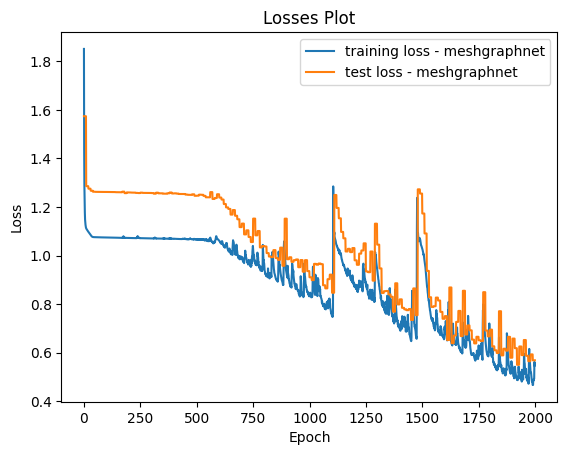

In [49]:
save_plots(args, losses, test_losses, velo_val_losses)

### Annimation

In [50]:
args.device= 'cpu'

In [72]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add an Axes to the current figure or retrieve an existing Axes.
    
    This is a wrapper of `.Figure.add_subplot` which provides additional
    behavior when working with the implicit API (see the notes section).
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(**kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
          *index* position on a grid with *nrows* rows and *ncols* columns.
          *index* starts at 1 in the upper left corner and increases to the
          right. *index* can also be a two-tuple specifying the (*first*,
          *last*) indices (1-based, and including *last*) of the subplo

In [87]:
help(ax.triplot)

Help on method triplot in module matplotlib.tri.triplot:

triplot(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Draw an unstructured triangular grid as lines and/or markers.
    
    Call signatures::
    
      triplot(triangulation, ...)
      triplot(x, y, [triangles], *, [mask=mask], ...)
    
    The triangular grid can be specified either by passing a `.Triangulation`
    object as the first parameter, or by passing the points *x*, *y* and
    optionally the *triangles* and a *mask*. If neither of *triangulation* or
    *triangles* are given, the triangulation is calculated on the fly.
    
    Parameters
    ----------
    triangulation : `.Triangulation`
        An already created triangular grid.
    x, y, triangles, mask
        Parameters defining the triangular grid. See `.Triangulation`.
        This is mutually exclusive with specifying *triangulation*.
    other_parameters
        All other args and kwargs are forwarded to `~.Axes.plot`.
 

In [88]:
help(ax.plot)

Help on method plot in module matplotlib.axes._axes:

plot(*args, scalex=True, scaley=True, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the ap

In [136]:
from matplotlib import tri as mtri
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

zoom_level = 0.04
def make_animation(gs, pred, evl, path, name , skip = 2, save_anim = True, plot_variables = False):
    '''
    input gs is a dataloader and each entry contains attributes of many timesteps.

    '''
    print('Generating velocity fields...')
    fig, axes = plt.subplots(3, 1, figsize=(16, 16))
    num_steps = len(gs) # for a single trajectory
    num_frames = num_steps // skip
    print(num_steps)
    
    
    
    x_min, x_max = torch.min(gs[0].mesh_pos[:, 0]).cpu(),torch.max(gs[0].mesh_pos[:, 0]).cpu()
    y_min, y_max = torch.min(gs[0].mesh_pos[:, 1]).cpu(), torch.max(gs[0].mesh_pos[:, 1]).cpu()
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    x_range, y_range = (x_max - x_min) / 2, (y_max - y_min) / 2
    zoomed_x_lim = (x_center+0.4 - zoom_level * x_range, x_center+0.4 + zoom_level * x_range)
    zoomed_y_lim = (y_center - zoom_level * y_range, y_center + zoom_level * y_range)

    
    def animate(num):
        step = (num*skip) % num_steps
        traj = 0

        bb_min = gs[0].x[:, 0:2].min().cpu() # first two columns are velocity
        bb_max = gs[0].x[:, 0:2].max().cpu() # use max and min velocity of gs dataset at the first step for both 
                                          # gs and prediction plots
            
#         print(bb_min,bb_max)
        bb_min_evl = evl[0].x[:, 0:2].min().cpu()  # first two columns are velocity
        bb_max_evl = evl[0].x[:, 0:2].max().cpu()  # use max and min velocity of gs dataset at the first step for both 
                                          # gs and prediction plots
        count = 0

        
        for ax in axes:
            ax.cla()
            ax.set_axis_off()
            
            pos = gs[step].mesh_pos 
            faces = gs[step].cells
            

            
            if (count == 0):
                # ground truth
                velocity = gs[step].x[:, 0:2]
                title = 'Ground truth:'
            elif (count == 1):
                velocity = pred[step].x[:, 0:2]
                title = 'Prediction:'
            else: 
                velocity = evl[step].x[:, 0:2]
                title = 'Error: (Prediction - Ground truth)'
                

            triang = mtri.Triangulation(pos[:, 0].cpu(), pos[:, 1].cpu(), faces.cpu())
            
            ax.set_xlim(zoomed_x_lim)
            ax.set_ylim(zoomed_y_lim)
            ax.triplot(triang)
            if (count <= 1):
                # absolute values
                
                mesh_plot = ax.tripcolor(triang, velocity[:, 0].cpu(), vmin= 120, vmax=bb_max,  shading='flat' ) # x-velocity
                ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
            else:
                # error: (pred - gs)/gs
                mesh_plot = ax.tripcolor(triang, velocity[:, 0].cpu(), vmin= bb_min_evl, vmax=bb_max_evl, shading='flat') # x-velocity
                ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
                #ax.triplot(triang, lw=0.5, color='0.5')

            ax.set_title('{} Trajectory {} Step {}'.format(title, traj, step), fontsize = '20')
            #ax.color

            #if (count == 0):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=1)
            clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
            clb.ax.tick_params(labelsize=20) 
            
            clb.ax.set_title('                          x velocity (m/s)',
                             fontdict = {'fontsize': 20})
            count += 1
        return fig,

    # Save animation for visualization
    if not os.path.exists(path):
        os.makedirs(path)
    
    if (save_anim):
        gs_anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000)
        writergif = animation.PillowWriter(fps=10) 
        anim_path = os.path.join(path, '{}_anim.gif'.format(name))
        gs_anim.save( anim_path, writer=writergif)
        
        plt.tight_layout()
        plt.show(block=True)
    else:
        pass

def visualize(loader, best_model, file_dir, args, gif_name, stats_list,delta_t = metadata['dt'], skip = 1):

    best_model.eval()
    device = args.device
    viz_data = {}
    gs_data = {}
    eval_data = {}
    viz_data_loader = copy.deepcopy(loader)
    gs_data_loader = copy.deepcopy(loader)
    eval_data_loader = copy.deepcopy(loader)
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
            std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    for data, viz_data, gs_data, eval_data in zip(loader, viz_data_loader,
                                                  gs_data_loader, eval_data_loader):
        data=data.to(args.device) 
        viz_data = data.to(args.device)
        with torch.no_grad():
            pred = best_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge).to('cpu')
            # pred gives the learnt accelaration between two timsteps
            # next_vel = curr_vel + pred * delta_t  
            viz_data.x[:, 0:2] = data.x[:, 0:2].to('cpu') + pred[:].to('cpu')* delta_t
            gs_data.x[:, 0:2] = data.x[:, 0:2].to('cpu') + data.y.to('cpu')* delta_t
            # gs_data - viz_data = error_data
            eval_data.x[:, 0:2] = (viz_data.x[:, 0:2].to('cpu') - gs_data.x[:, 0:2].to('cpu'))
  
#     print(viz_data_loader)
    make_animation(gs_data_loader, viz_data_loader, eval_data_loader, file_dir, gif_name, skip, True, False)

    return eval_data_loader

In [152]:

dataset = torch.load(file_path)[1202:1800]
# stats_list = get_stats(dataset[150:300])

In [145]:
len(dataset[0:50])

0

In [148]:
len(dataset[2:20])

18

In [153]:
stats_list = get_stats(dataset[0:150])

Generating velocity fields...
150


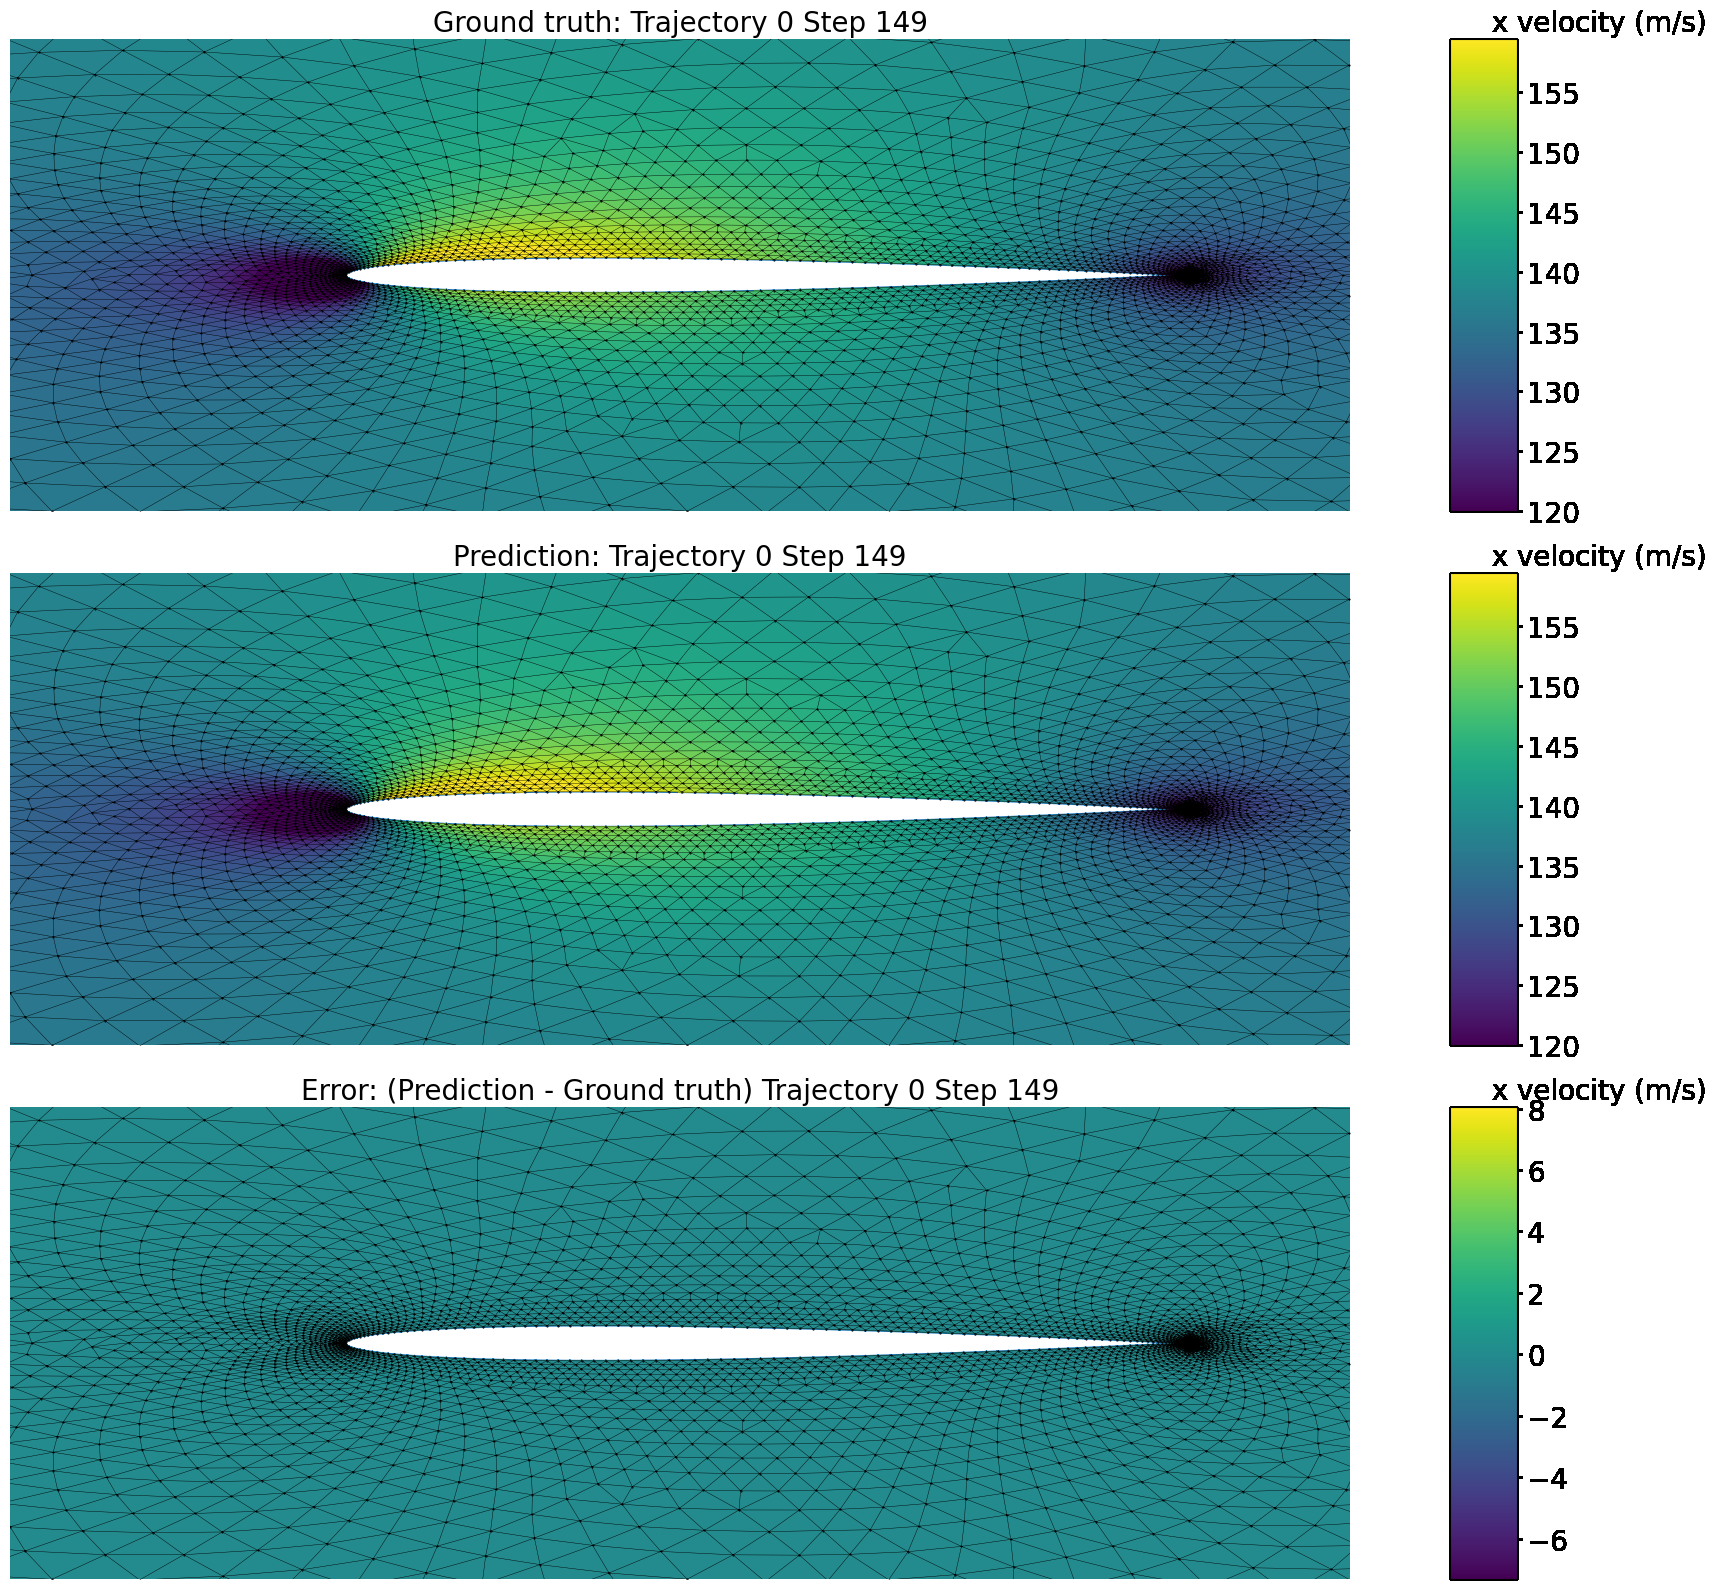

In [154]:
# visualize predicted velocities
animation_name = 'x_velocity_airfoil6'
args.postprocess_dir = postprocess_dir

eval_data_loader = visualize(dataset[0:150], best_model.to(args.device), args.postprocess_dir, args, animation_name, stats_list, 
           delta_t = metadata['dt'], skip = 1)

In [55]:
data = dataset[0].cuda()

In [45]:
dataset[2].y,dataset[3].y

(tensor([[4621.6201,  660.1286],
         [5039.5586,  717.8068],
         [5324.2495,  765.4572],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]], device='cuda:0'),
 tensor([[-101.4709,   -9.2125],
         [-103.3020,  -14.8773],
         [-113.4872,  -16.3412],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]], device='cuda:0'))

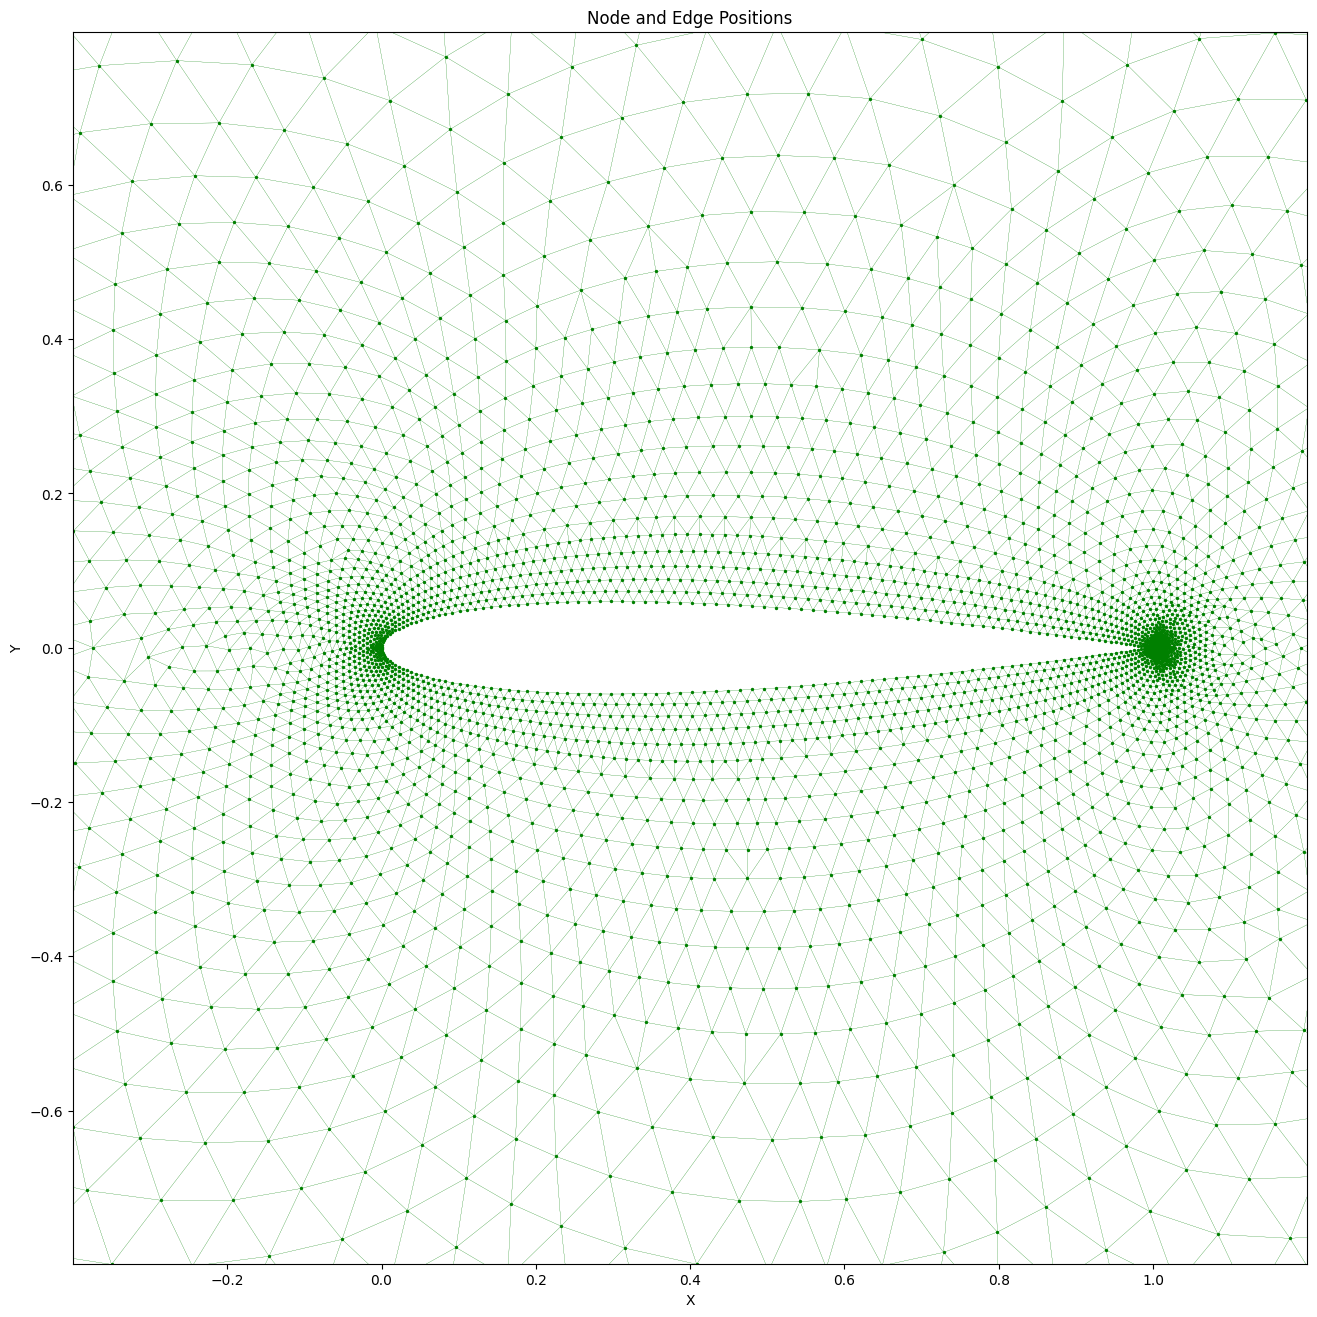

In [75]:
import torch
import torch_geometric
import matplotlib.pyplot as plt

# Example data with node features, 2D position attributes, and edge indices
# x = torch.tensor([[0.0, 0.0], [1.0, 1.0], [2.0, 2.0], [3.0, 3.0]], dtype=torch.float)
# y = torch.tensor([0, 1, 0, 1], dtype=torch.long)
# edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)
# data = torch_geometric.data.Data(x=x, y=y, edge_index=edge_index)
# print(data)

data = dataset[0].cpu()

# Plotting the nodes and edges
# Plotting the nodes and edges

zoom_level = 0.04

# Calculate the zoomed limits
x_min, x_max = torch.min(data.mesh_pos[:, 0]), torch.max(data.mesh_pos[:, 0])
y_min, y_max = torch.min(data.mesh_pos[:, 1]), torch.max(data.mesh_pos[:, 1])
x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
x_range, y_range = (x_max - x_min) / 2, (y_max - y_min) / 2
zoomed_x_lim = (x_center+0.4 - zoom_level * x_range, x_center+0.4 + zoom_level * x_range)
zoomed_y_lim = (y_center - zoom_level * y_range, y_center + zoom_level * y_range)


# %matplotlib notebook
fig, ax = plt.subplots(figsize=(40, 16))

# ax.set_aspect('equal')

# Plot nodes
ax.scatter(data.mesh_pos[:, 0], data.mesh_pos[:, 1], color='green', s=2)

# Plot edges
edges = data.edge_index.t().tolist()
for edge in edges:
    ax.plot([data.mesh_pos[edge[0], 0], data.mesh_pos[edge[1], 0]],
            [data.mesh_pos[edge[0], 1], data.mesh_pos[edge[1], 1]], color='green',linewidth=0.1)

ax.set_xlim(zoomed_x_lim)
ax.set_ylim(zoomed_y_lim)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Node and Edge Positions')

plt.show()




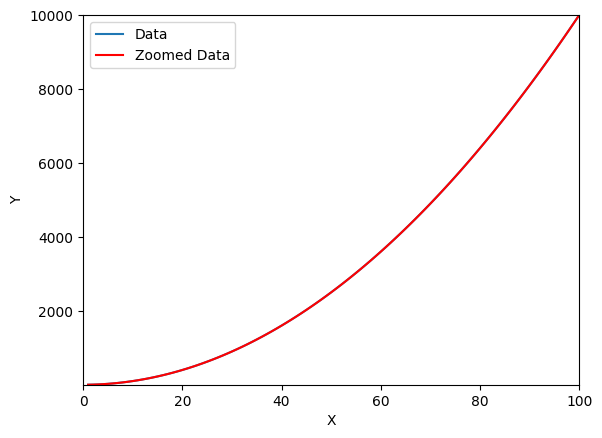

In [24]:
import matplotlib.pyplot as plt

# Generate some data
x = range(1, 101)
y = [val ** 2 for val in x]

# Plot the entire graph
plt.plot(x, y, label='Data')

# Set the limits for the zoomed region
zoom_start = 0
zoom_end = 100
zoomed_x_range = x[zoom_start:zoom_end]
zoomed_y_range = y[zoom_start:zoom_end]

# Plot the zoomed region
plt.plot(zoomed_x_range, zoomed_y_range, 'r', label='Zoomed Data')

# Set the limits for the x-axis and y-axis
plt.xlim(0, 100)
plt.ylim(min(zoomed_y_range), max(zoomed_y_range))

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Display the plot
plt.show()